# Прогнозирование цены биткоина

Обучающие данные - это ежедневные данные о цене биткоина за предыдущие полтора года.

Тестовые данные - 7 дней после окончания обучающих данных.

Установим библиотеку CatBoost

Отключим вывод предупреждений

In [1]:
import warnings
warnings.filterwarnings('ignore')

Импортируем необходимые библиотеки

In [2]:
# библиотеки для обработки и анализа структурированных данных
import pandas as pd
import numpy as np

# библиотеки визуализации
import matplotlib.pyplot as plt
import seaborn as sns

# библиотека статистических моделей
from statsmodels.tsa.seasonal import seasonal_decompose

# библиотека для машинного обучения на основе градиентного бустинга
from catboost import CatBoostRegressor

# библиотека моделей для машинного обучения
from sklearn.metrics import mean_absolute_error

Настройки визуализации

In [3]:
sns.set_theme()

FONT_SMALL_SIZE = 10
FONT_MEDIUM_SIZE = 12
FONT_BIGGER_SIZE = 15

plt.rc('font', size=FONT_SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=FONT_MEDIUM_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=FONT_MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=FONT_SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=FONT_SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=FONT_SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=FONT_BIGGER_SIZE)  # fontsize of the figure title
plt.rc('lines', linewidth=1)                  # line width
plt.rc('figure', figsize=(12, 4))             # size of the figure

## Формирование датасета

*последние 7 строк для теста содержат значения, скопированные с предыдущего дня*

Сформируем рабочий датасет

In [5]:
file_path = r'D:\__projects__\diploma\portfolios-optimization\data\BTCUSDT_hourly_data.csv'

df = pd.read_csv(
    file_path,
    parse_dates=['Open time'], 
    index_col='Open time'   
)

data = df.copy()

print('Total length:', len(data))

data = data.sort_index()

columns_to_keep_and_rename = {
    'Open': 'Open',
    'High': 'High',
    'Low': 'Low',
    'Close': 'Price',
    'Volume': 'Vol.' 
}

data = data[list(columns_to_keep_and_rename.keys())]
data = data.rename(columns=columns_to_keep_and_rename)

data['Change %'] = data['Price'].pct_change() * 100
data['Change %'] = data['Change %'].map('{:.2f}%'.format)

display(data.head())

print("\nТипы данных в колонках:")
print(data.dtypes)

# И информацию о датафрейме
print("\nИнформация о датафрейме:")
data.info()

Total length: 38153


,Open,High,Low,Price,Vol.,Change %
Open time,,,,,,
2021-01-01 00:00:00,28923.63,29031.34,28690.17,28995.13,2311.811445,nan%
2021-01-01 01:00:00,28995.13,29470.00,28960.35,29409.99,5403.068471,1.43%
2021-01-01 02:00:00,29410.00,29465.26,29120.03,29194.65,2384.231560,-0.73%
2021-01-01 03:00:00,29195.25,29367.00,29150.02,29278.40,1461.345077,0.29%
2021-01-01 04:00:00,29278.41,29395.00,29029.40,29220.31,2038.046803,-0.20%



Типы данных в колонках:
Open        float64
High        float64
Low         float64
Price       float64
Vol.        float64
Change %     object
dtype: object

Информация о датафрейме:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 38153 entries, 2021-01-01 00:00:00 to 2025-05-10 05:00:00
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Open      38153 non-null  float64
 1   High      38153 non-null  float64
 2   Low       38153 non-null  float64
 3   Price     38153 non-null  float64
 4   Vol.      38153 non-null  float64
 5   Change %  38153 non-null  object 
dtypes: float64(5), object(1)
memory usage: 2.0+ MB


Преобразуем значения столбцов в нужный формат

In [6]:
data['Change %'] = data['Change %'].apply(lambda x: float(x.replace('%', '')))

# Удаляем колонку 'Vol.', если она больше не нужна.
data = data.drop('Vol.', axis=1)

# Для проверки можно вывести типы данных и первые строки
print("\nТипы данных после изменений во второй ячейке:")
print(data.dtypes)
print("\nПервые 5 строк после изменений во второй ячейке:")
from IPython.display import display # Убедись, что display импортирован, если запускаешь в Jupyter
display(data.head())


Типы данных после изменений во второй ячейке:
Open        float64
High        float64
Low         float64
Price       float64
Change %    float64
dtype: object

Первые 5 строк после изменений во второй ячейке:


,Open,High,Low,Price,Change %
Open time,,,,,
2021-01-01 00:00:00,28923.63,29031.34,28690.17,28995.13,NaN
2021-01-01 01:00:00,28995.13,29470.00,28960.35,29409.99,1.43
2021-01-01 02:00:00,29410.00,29465.26,29120.03,29194.65,-0.73
2021-01-01 03:00:00,29195.25,29367.00,29150.02,29278.40,0.29
2021-01-01 04:00:00,29278.41,29395.00,29029.40,29220.31,-0.20


In [7]:
import pandas as pd
import json # Для обработки JSON-подобных строк

# Загрузка новостного датасета
news_file_path = r'D:\__projects__\diploma\portfolios-optimization\notebooks\news_data\btc\combined_btc_news.csv'
try:
    news_df = pd.read_csv(news_file_path)
except FileNotFoundError:
    print(f"Файл новостей не найден: {news_file_path}")
    # Реши, как обрабатывать эту ситуацию: остановить выполнение или продолжить без новостей
    news_df = pd.DataFrame() # Пустой DataFrame, чтобы код ниже не падал сразу

if not news_df.empty:
    # Преобразуем 'date_published' в datetime
    news_df['date_published'] = pd.to_datetime(news_df['date_published'])
    
    # Установим 'date_published' как индекс
    news_df.set_index('date_published', inplace=True)
    
    # Отсортируем по индексу (важно для дальнейших операций resample/rolling)
    news_df.sort_index(inplace=True)

    print("Новостной датасет загружен и базово обработан:")
    display(news_df.head(2))
    print(news_df.info())
else:
    print("Новостной датасет пуст или не загружен.")

Новостной датасет загружен и базово обработан:


,title,url,authors,summary,banner_image,source,category_within_source,source_domain,topics,overall_sentiment_score,overall_sentiment_label,ticker_sentiment
date_published,,,,,,,,,,,,
2022-03-01 12:58:36,Geopolitical Risk Returns for Global Markets,https://www.nytimes.com/2022/03/01/business/de...,[],Investors are weighing the implications of Rus...,https://static01.nyt.com/images/2022/03/01/mul...,New York Times,Dealbook,www.nytimes.com,"[{'topic': 'Economy - Monetary', 'relevance_sc...",-0.138797,Neutral,"[{'ticker': 'NFLX', 'relevance_score': '0.0189..."
2022-03-02 02:32:56,"Asian shares slip, oil surges again as Russia ...",https://www.moneycontrol.com/news/business/mar...,[],"As global sanctions against Moscow tighten, th...",https://images.moneycontrol.com/static-mcnews/...,Money Control,Markets,www.moneycontrol.com,"[{'topic': 'Energy & Transportation', 'relevan...",-0.031243,Neutral,"[{'ticker': 'EQNR', 'relevance_score': '0.0639..."


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 63355 entries, 2022-03-01 12:58:36 to 2025-05-02 05:57:38
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   title                    63355 non-null  object 
 1   url                      63355 non-null  object 
 2   authors                  63355 non-null  object 
 3   summary                  63353 non-null  object 
 4   banner_image             60670 non-null  object 
 5   source                   63355 non-null  object 
 6   category_within_source   27173 non-null  object 
 7   source_domain            63355 non-null  object 
 8   topics                   63355 non-null  object 
 9   overall_sentiment_score  63355 non-null  float64
 10  overall_sentiment_label  63355 non-null  object 
 11  ticker_sentiment         63355 non-null  object 
dtypes: float64(1), object(11)
memory usage: 6.3+ MB
None


In [8]:
def extract_btc_sentiment(ticker_sentiment_str):
    if pd.isna(ticker_sentiment_str):
        return None
    try:
        # Строка может быть обернута в одинарные кавычки, json.loads ожидает двойные
        # Также уберем возможные проблемы с None/True/False, если они не стандартные JSON
        processed_str = ticker_sentiment_str.replace("'", '"')
        # json.loads может не справиться с некоторыми форматами, eval более гибкий, но менее безопасный
        # Если уверены в источнике, можно использовать eval, но с осторожностью.
        # Для AlphaVantage, если это действительно список словарей, json.loads должен работать
        # после замены кавычек.
        
        # Более безопасный способ, если json.loads не работает напрямую
        # из-за формата, похожего на Python-список, а не строгий JSON:
        import ast
        tickers_list = ast.literal_eval(ticker_sentiment_str) # Используем ast.literal_eval для безопасности
        
        for ticker_info in tickers_list:
            if ticker_info.get('ticker') == 'CRYPTO:BTC':
                return float(ticker_info.get('ticker_sentiment_score', 0.0)) # Возвращаем 0.0 если нет score
        return None # BTC не найден в списке
    except (SyntaxError, ValueError, TypeError) as e:
        # print(f"Ошибка парсинга ticker_sentiment: {e} для строки: {ticker_sentiment_str[:100]}")
        return None # В случае ошибки парсинга

if not news_df.empty:
    news_df['btc_specific_sentiment'] = news_df['ticker_sentiment'].apply(extract_btc_sentiment)
    print("\nНовостной датасет с извлеченным BTC сентиментом:")
    display(news_df[['overall_sentiment_score', 'btc_specific_sentiment']].head())
    print(f"Количество новостей с BTC сентиментом: {news_df['btc_specific_sentiment'].notna().sum()} из {len(news_df)}")


Новостной датасет с извлеченным BTC сентиментом:


,overall_sentiment_score,btc_specific_sentiment
date_published,,
2022-03-01 12:58:36,-0.138797,-0.118125
2022-03-02 02:32:56,-0.031243,0.006883
2022-03-02 08:00:00,-0.174572,-0.009523
2022-03-02 10:00:25,-0.036470,0.001776
2022-03-02 11:00:26,0.034280,-0.052478


Количество новостей с BTC сентиментом: 63355 из 63355


In [9]:
if not news_df.empty:
    # Выбираем нужные числовые колонки для агрегации
    cols_to_aggregate = ['overall_sentiment_score', 'btc_specific_sentiment']
    
    # Создаем признак "количество новостей"
    news_df['news_count'] = 1 
    
    # Агрегируем до часовой частоты
    # .resample('H') - группирует по часам
    # .agg() - применяет функции агрегации
    hourly_news_aggregated = news_df.resample('H').agg(
        avg_overall_sentiment=('overall_sentiment_score', 'mean'),
        avg_btc_specific_sentiment=('btc_specific_sentiment', 'mean'),
        sum_news_count=('news_count', 'sum')
        # Можно добавить другие агрегации, например, min, max, std для сентимента
    )
    
    # Заполним NaN, которые появятся в часах без новостей.
    # Можно заполнить нулями (означает отсутствие новостей / нейтральный сентимент)
    # или использовать ffill/bfill, если это имеет смысл.
    hourly_news_aggregated.fillna(0, inplace=True) # Заполняем нулями, т.к. нет новостей = нет влияния/нейтрально
                                                 # Для sum_news_count 0 - логично.
                                                 # Для avg_sentiment 0 может означать нейтрально.

    print("\nАгрегированные часовые новостные данные:")
    display(hourly_news_aggregated.head())
else:
    hourly_news_aggregated = pd.DataFrame() # Пустой, если новостей не было


Агрегированные часовые новостные данные:


,avg_overall_sentiment,avg_btc_specific_sentiment,sum_news_count
date_published,,,
2022-03-01 12:00:00,-0.138797,-0.118125,1
2022-03-01 13:00:00,0.000000,0.000000,0
2022-03-01 14:00:00,0.000000,0.000000,0
2022-03-01 15:00:00,0.000000,0.000000,0
2022-03-01 16:00:00,0.000000,0.000000,0


In [10]:
# Убедимся, что индекс 'data' тоже DatetimeIndex
if not isinstance(data.index, pd.DatetimeIndex):
    data.index = pd.to_datetime(data.index)

if not hourly_news_aggregated.empty:
    # Объединяем, используя левое соединение, чтобы сохранить все строки из 'data'
    data_with_news = data.merge(hourly_news_aggregated, left_index=True, right_index=True, how='left')
    
    # После merge, для часов в 'data', где не было соответствующих новостей в 'hourly_news_aggregated',
    # появятся NaN. Заполним их нулями (или другим подходящим значением).
    news_cols_in_merged = list(hourly_news_aggregated.columns)
    data_with_news[news_cols_in_merged] = data_with_news[news_cols_in_merged].fillna(0)
    
    print("\nФинальный датасет 'data_with_news' (первые строки):")
    display(data_with_news.head())
    print("\nХвостовые строки, чтобы проверить заполнение NaN:")
    display(data_with_news.tail())
    print(data_with_news.info())
else:
    print("Новостные данные не были добавлены, так как 'hourly_news_aggregated' пуст.")
    data_with_news = data.copy() # Работаем с исходными данными, если новостей нет

# Теперь data_with_news содержит исходные данные BTC и добавленные часовые новостные признаки.
# Этот data_with_news можно использовать для дальнейшей предобработки и обучения модели.


Финальный датасет 'data_with_news' (первые строки):


,Open,High,Low,Price,Change %,avg_overall_sentiment,avg_btc_specific_sentiment,sum_news_count
2021-01-01 00:00:00,28923.63,29031.34,28690.17,28995.13,NaN,0.0,0.0,0.0
2021-01-01 01:00:00,28995.13,29470.00,28960.35,29409.99,1.43,0.0,0.0,0.0
2021-01-01 02:00:00,29410.00,29465.26,29120.03,29194.65,-0.73,0.0,0.0,0.0
2021-01-01 03:00:00,29195.25,29367.00,29150.02,29278.40,0.29,0.0,0.0,0.0
2021-01-01 04:00:00,29278.41,29395.00,29029.40,29220.31,-0.20,0.0,0.0,0.0



Хвостовые строки, чтобы проверить заполнение NaN:


,Open,High,Low,Price,Change %,avg_overall_sentiment,avg_btc_specific_sentiment,sum_news_count
2025-05-10 01:00:00,102865.70,103119.99,102865.70,102987.50,0.12,0.0,0.0,0.0
2025-05-10 02:00:00,102987.50,103265.82,102956.96,103147.96,0.16,0.0,0.0,0.0
2025-05-10 03:00:00,103147.95,103233.48,102972.17,103226.24,0.08,0.0,0.0,0.0
2025-05-10 04:00:00,103226.25,103226.25,103034.50,103152.48,-0.07,0.0,0.0,0.0
2025-05-10 05:00:00,103152.48,103300.96,103088.99,103230.03,0.08,0.0,0.0,0.0


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 38153 entries, 2021-01-01 00:00:00 to 2025-05-10 05:00:00
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Open                        38153 non-null  float64
 1   High                        38153 non-null  float64
 2   Low                         38153 non-null  float64
 3   Price                       38153 non-null  float64
 4   Change %                    38152 non-null  float64
 5   avg_overall_sentiment       38153 non-null  float64
 6   avg_btc_specific_sentiment  38153 non-null  float64
 7   sum_news_count              38153 non-null  float64
dtypes: float64(8)
memory usage: 2.6 MB
None


In [11]:
data = data_with_news.copy()

In [12]:
data

,Open,High,Low,Price,Change %,avg_overall_sentiment,avg_btc_specific_sentiment,sum_news_count
2021-01-01 00:00:00,28923.63,29031.34,28690.17,28995.13,NaN,0.0,0.0,0.0
2021-01-01 01:00:00,28995.13,29470.00,28960.35,29409.99,1.43,0.0,0.0,0.0
2021-01-01 02:00:00,29410.00,29465.26,29120.03,29194.65,-0.73,0.0,0.0,0.0
2021-01-01 03:00:00,29195.25,29367.00,29150.02,29278.40,0.29,0.0,0.0,0.0
2021-01-01 04:00:00,29278.41,29395.00,29029.40,29220.31,-0.20,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
2025-05-10 01:00:00,102865.70,103119.99,102865.70,102987.50,0.12,0.0,0.0,0.0
2025-05-10 02:00:00,102987.50,103265.82,102956.96,103147.96,0.16,0.0,0.0,0.0
2025-05-10 03:00:00,103147.95,103233.48,102972.17,103226.24,0.08,0.0,0.0,0.0
2025-05-10 04:00:00,103226.25,103226.25,103034.50,103152.48,-0.07,0.0,0.0,0.0


Установим константы

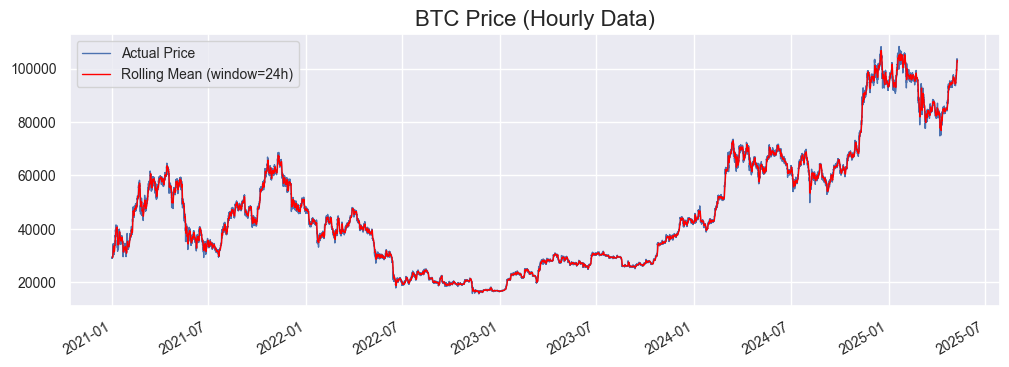

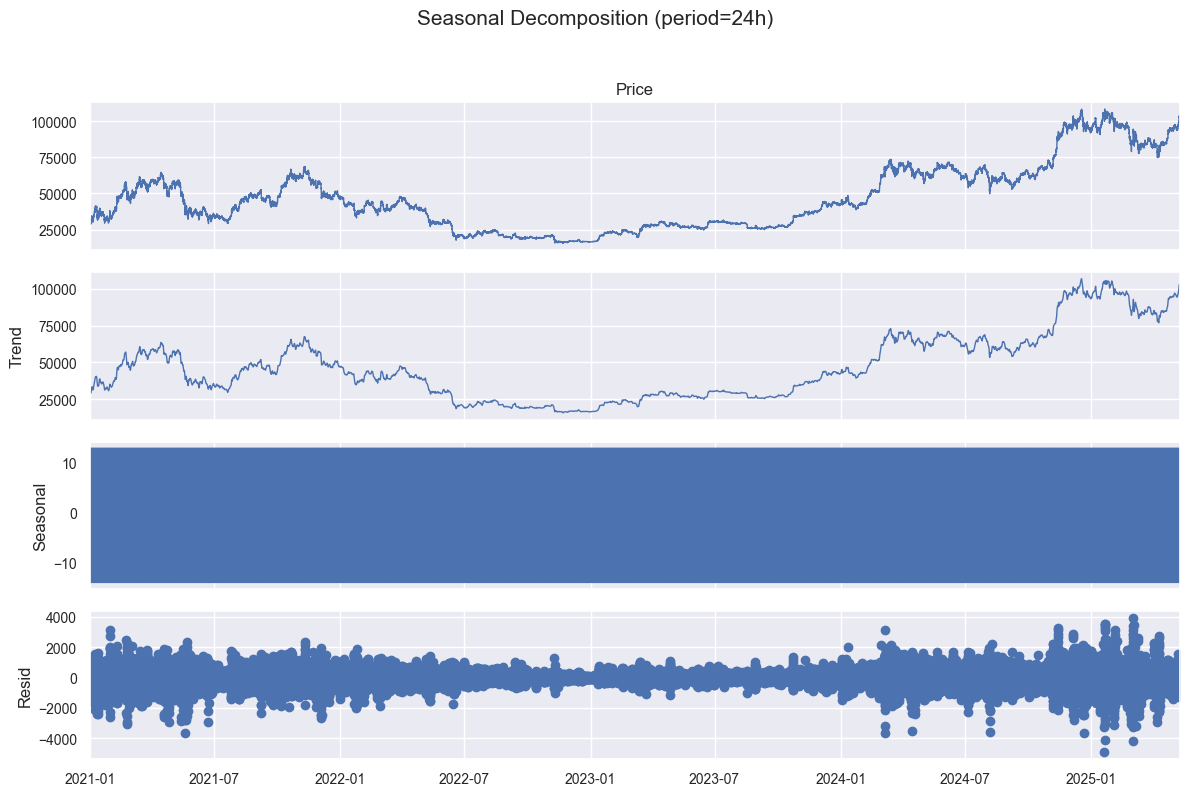

Размер обучающей выборки (data_train): 37985 наблюдений
Размер тестовой выборки (data_test): 168 наблюдений (7 дней)


In [13]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import pandas as pd # Убедись, что pandas импортирован, если он используется для data

# Предполагаем, что 'data' и 'TARGET' уже определены из предыдущих ячеек
TARGET = 'Price' # уже должно быть определено

# --- Корректировки для часовых данных и 7-дневного прогноза ---
HOURS_IN_DAY = 24
DAYS_FOR_TEST = 7
TEST_SIZE = DAYS_FOR_TEST * HOURS_IN_DAY # 7 дней * 24 часа = 168 часов

# --- Параметры, которые были в твоем коде ---
RANDOM_SEED = 0 # параметр рандомизации
FOLDS_N = 10 # количество фолдов

# Обучающая выборка (все данные, кроме последних TEST_SIZE часов)
data_train = data[:-TEST_SIZE] # Переименовал в data_train для ясности
# Тестовая выборка (последние TEST_SIZE часов)
data_test = data[-TEST_SIZE:]

# --- Визуализация ---
# Предположим, FONT_BIGGER_SIZE определен где-то ранее,
# если нет, замени на число или удали параметр fontsize
FONT_BIGGER_SIZE = 16 # Пример значения, если не определено

plt.rc('figure', figsize=(12, 4))
plt.title(f'BTC {TARGET} (Hourly Data)', fontsize=FONT_BIGGER_SIZE)
data[TARGET].plot(label='Actual Price')

# Скользящее среднее:
# window=60 (2.5 дня) было в оригинале.
# Предлагаю рассмотреть window=24 (дневное) или window=168 (недельное) для часовых данных.
# Оставим 60, если это специфический выбор, но укажем альтернативы.
rolling_window_hourly = 24 * 1 # Например, за 1 день (24 часа). Можно изменить на 60, если это важно.
# rolling_window_hourly = 60 # Твой оригинальный выбор
# rolling_window_hourly = 24*7 # Недельное сглаживание

r = data[TARGET].rolling(window=rolling_window_hourly)
rolling_mean = r.mean()
rolling_mean.plot(color='red', label=f'Rolling Mean (window={rolling_window_hourly}h)')
plt.legend()
plt.show()

# Сезонная декомпозиция:
# period=60 (2.5 дня) был в оригинале.
# Для часовых данных более типичны period=24 (дневная сезонность) или period=168 (недельная).
# Рекомендую начать с дневной сезонности.
decomposition_period_hourly = 24 # Дневная сезонность (24 часа)
# decomposition_period_hourly = 24*7 # Недельная сезонность (168 часов)
# decomposition_period_hourly = 60 # Твой оригинальный выбор

# Убедимся, что в данных достаточно периодов для декомпозиции
if len(data[TARGET]) >= 2 * decomposition_period_hourly:
    sd = seasonal_decompose(data[TARGET], period=decomposition_period_hourly, model='additive')
    plt.rc('figure', figsize=(12, 8)) # Увеличил немного высоту для лучшей читаемости 3х графиков
    sd.plot()
    plt.suptitle(f'Seasonal Decomposition (period={decomposition_period_hourly}h)', y=0.99) # Добавил общий заголовок
    plt.tight_layout(rect=[0, 0, 1, 0.96]) # Чтобы suptitle не накладывался
else:
    print(f"Недостаточно данных для сезонной декомпозиции с периодом {decomposition_period_hourly}.")
    print(f"Требуется как минимум {2 * decomposition_period_hourly} точек, в наличии {len(data[TARGET])}.")

plt.show()

print(f"Размер обучающей выборки (data_train): {len(data_train)} наблюдений")
print(f"Размер тестовой выборки (data_test): {len(data_test)} наблюдений ({DAYS_FOR_TEST} дней)")

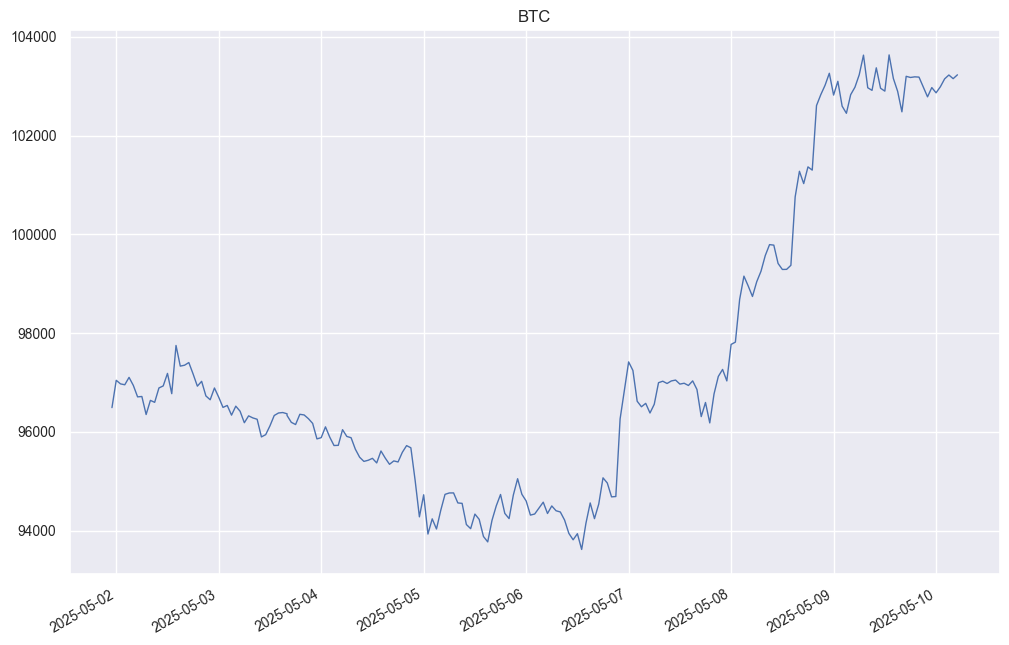

In [14]:
data[-200:][TARGET].plot()
plt.title('BTC')
plt.show()

## Функции подготовки данных и оптимизации модели

In [15]:
import pandas as pd
import numpy as np

# TARGET должна быть определена глобально, например:
# TARGET = 'Price'

# Функция code_mean остается без изменений, она универсальна
def code_mean(data_subset, cat_feature, real_feature):
    """Рассчитывает среднее значение real_feature для каждой категории cat_feature."""
    return dict(data_subset.groupby(cat_feature)[real_feature].mean())

def preprocess_data_hourly_no_leak(data_input: pd.DataFrame,
                                   target_col_name: str,
                                   lags_to_create: list = None,
                                   test_size_hours: int = 7*24):
    """
    Предобработка данных для часовых временных рядов с акцентом на предотвращение утечек.

    Args:
        data_input (pd.DataFrame): Входной DataFrame с DatetimeIndex.
        target_col_name (str): Название целевой колонки.
        lags_to_create (list, optional): Список часов для создания лаговых признаков.
                                         Пример: [1, 2, 24, 168].
                                         Если None, используются дефолтные лаги.
        test_size_hours (int): Размер тестовой выборки в часах.

    Returns:
        tuple: X_train, X_test, y_train, y_test
    """
    if not isinstance(data_input.index, pd.DatetimeIndex):
        raise ValueError("Индекс входных данных должен быть pd.DatetimeIndex.")

    data = data_input.copy()

    if lags_to_create is None:
        lags_to_create = [1, 2, 3, 6, 12, 24, 24*2, 24*3, 24*7] # Дефолтные лаги

    # 1. Создаем лаговые признаки на всем датасете
    for lag in lags_to_create:
        data[f"{target_col_name}_lag_{lag}h"] = data[target_col_name].shift(lag)

    # 2. Создаем временные признаки на всем датасете
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    data['dayofmonth'] = data.index.day
    data['month'] = data.index.month
    # data['weekofyear'] = data.index.isocalendar().week.astype(int) # Раскомментируй, если нужно

    # 3. Удаляем строки с NaN, появившиеся из-за shift() (лагов)
    # Это важно сделать до вычисления средних и разделения,
    # чтобы индексы были консистентными.
    data = data.dropna()
    
    if data.empty:
        raise ValueError("После создания лагов и удаления NaN не осталось данных. "
                         "Проверьте размер исходных данных и значения лагов.")

    # 4. Определяем индекс разделения на train/test ПОСЛЕ dropna
    # test_size_hours теперь относится к количеству последних строк в ОБРАБОТАННОМ data
    if test_size_hours < 1: # Если передана доля (менее вероятно здесь, но для полноты)
        # Это будет доля от УЖЕ обработанных данных
        num_test_samples = int(len(data) * test_size_hours)
    else:
        num_test_samples = test_size_hours
    
    if num_test_samples >= len(data):
        print(f"Предупреждение: test_size_hours ({num_test_samples}) >= длина обработанных данных ({len(data)}). "
              f"Вся доступная выборка будет использована как обучающая, тестовая будет пустой.")
        split_idx_pos = len(data) # Тестовая выборка будет пустой
    elif num_test_samples <= 0:
        print(f"Предупреждение: test_size_hours ({num_test_samples}) <= 0. "
              f"Вся доступная выборка будет использована как обучающая, тестовая будет пустой.")
        split_idx_pos = len(data) # Тестовая выборка будет пустой
    else:
        split_idx_pos = len(data) - num_test_samples


    train_df = data.iloc[:split_idx_pos].copy() # Явное копирование для избежания SettingWithCopyWarning
    test_df = data.iloc[split_idx_pos:].copy()   # Явное копирование

    # 5. Кодирование средним: вычисляем средние ТОЛЬКО на train_df, применяем к train_df и test_df
    features_for_mean_encoding = ['hour', 'dayofweek', 'dayofmonth', 'month']
    # Если добавляли 'weekofyear', добавьте и его сюда
    
    # Словарь для хранения вычисленных средних (чтобы применить те же к тесту)
    calculated_means = {}

    for feat_cat in features_for_mean_encoding:
        if feat_cat in train_df.columns: # Убедимся, что колонка существует
            # Вычисляем средние на обучающей выборке
            means = code_mean(train_df, feat_cat, target_col_name)
            calculated_means[feat_cat] = means
            
            # Глобальное среднее по трейну для этой категории для заполнения пропусков
            global_mean_target_train_for_feat = train_df[target_col_name].mean() # Это общее среднее, не по категории
                                                                           # Лучше использовать среднее по категории или общее среднее
            if pd.isna(global_mean_target_train_for_feat) and not train_df.empty : # Если трейн не пуст, но среднее NaN (все target NaN)
                 global_mean_target_train_for_feat = 0 # Запасной вариант
            elif train_df.empty:
                 global_mean_target_train_for_feat = 0 # Если трейн пуст


            # Применяем к обучающей выборке
            train_df[f'{feat_cat}_avg_{target_col_name}'] = train_df[feat_cat].map(means)
            train_df[f'{feat_cat}_avg_{target_col_name}'].fillna(global_mean_target_train_for_feat, inplace=True)
            train_df.drop(feat_cat, axis=1, inplace=True)

            # Применяем к тестовой выборке, используя средние, посчитанные на ТРЕЙНЕ
            if feat_cat in test_df.columns:
                test_df[f'{feat_cat}_avg_{target_col_name}'] = test_df[feat_cat].map(means) # Используем те же `means`
                test_df[f'{feat_cat}_avg_{target_col_name}'].fillna(global_mean_target_train_for_feat, inplace=True) # Заполняем тем же глобальным средним из трейна
                test_df.drop(feat_cat, axis=1, inplace=True)
        else:
            print(f"Предупреждение: Категориальный признак '{feat_cat}' не найден в train_df для кодирования средним.")


    # 6. Формируем X_train, y_train, X_test, y_test
    # Убедимся, что целевая колонка есть перед тем как ее удалять из X
    if target_col_name in train_df.columns:
        X_train = train_df.drop(target_col_name, axis=1)
        y_train = train_df[target_col_name]
    else: # Если вдруг целевая колонка пропала (не должно случиться)
        X_train = train_df.copy()
        y_train = pd.Series(index=train_df.index, dtype=float) # Пустая серия
        print(f"ПРЕДУПРЕЖДЕНИЕ: Целевая колонка '{target_col_name}' не найдена в train_df.")

    if target_col_name in test_df.columns:
        X_test = test_df.drop(target_col_name, axis=1)
        y_test = test_df[target_col_name]
    else:
        X_test = test_df.copy()
        y_test = pd.Series(index=test_df.index, dtype=float)
        print(f"ПРЕДУПРЕЖДЕНИЕ: Целевая колонка '{target_col_name}' не найдена в test_df.")


    print(f"Размер X_train: {X_train.shape}, y_train: {y_train.shape}")
    print(f"Размер X_test: {X_test.shape}, y_test: {y_test.shape}")
    
    if X_test.empty or y_test.empty:
        # Это может произойти, если test_size_hours слишком большой или данных мало
        print("ПРЕДУПРЕЖДЕНИЕ: Тестовая выборка пуста! Проверьте test_size_hours и длину данных после создания лагов.")

    return X_train, X_test, y_train, y_test

In [16]:
TARGET = 'Price' # Убедись, что TARGET определена

# Определяем, какие лаги мы хотим создать (в часах)
custom_lags = [1, 2, 3, 6, 12, 23, 24, 25, 47, 48, 49, 167, 168, 169] # (24*7 = 168)

# Размер тестовой выборки: 7 дней * 24 часа
hours_for_test_set = 7 * 24

try:
    X_train, X_test, y_train, y_test = preprocess_data_hourly_no_leak(
        data_input=data, # Твой исходный DataFrame (копия будет создана внутри)
        target_col_name=TARGET,
        lags_to_create=custom_lags,
        test_size_hours=hours_for_test_set
    )

    print("\nПример X_train:")
    if not X_train.empty: display(X_train.head())
    print("\nПример y_train:")
    if not y_train.empty: display(y_train.head())
    print("\nПример X_test:")
    if not X_test.empty: display(X_test.head())
    print("\nПример y_test:")
    if not y_test.empty: display(y_test.head())

except ValueError as e:
    print(f"Ошибка при предобработке данных: {e}")
except Exception as e:
    print(f"Непредвиденная ошибка: {e}")

Размер X_train: (37816, 25), y_train: (37816,)
Размер X_test: (168, 25), y_test: (168,)

Пример X_train:


,Open,High,Low,Change %,avg_overall_sentiment,avg_btc_specific_sentiment,sum_news_count,Price_lag_1h,Price_lag_2h,Price_lag_3h,...,Price_lag_47h,Price_lag_48h,Price_lag_49h,Price_lag_167h,Price_lag_168h,Price_lag_169h,hour_avg_Price,dayofweek_avg_Price,dayofmonth_avg_Price,month_avg_Price
2021-01-08 01:00:00,38793.24,39000.00,37800.00,-0.29,0.0,0.0,0.0,38793.23,39432.28,39665.92,...,33873.30,33811.28,33918.01,29194.65,29409.99,28995.13,46452.645276,46487.172673,45951.241684,48445.295562
2021-01-08 02:00:00,38681.38,38692.83,36500.00,-3.88,0.0,0.0,0.0,38681.37,38793.23,39432.28,...,34117.59,33873.30,33811.28,29278.40,29194.65,29409.99,46438.065565,46487.172673,45951.241684,48445.295562
2021-01-08 03:00:00,37181.74,38460.13,37068.40,3.13,0.0,0.0,0.0,37181.74,38681.37,38793.23,...,35325.91,34117.59,33873.30,29220.31,29278.40,29194.65,46432.569359,46487.172673,45951.241684,48445.295562
2021-01-08 04:00:00,38347.11,38949.97,38155.61,0.84,0.0,0.0,0.0,38347.10,37181.74,38681.37,...,34978.91,35325.91,34117.59,29187.01,29220.31,29278.40,46438.028737,46487.172673,45951.241684,48445.295562
2021-01-08 05:00:00,38668.92,38700.00,37895.00,-1.79,0.0,0.0,0.0,38668.92,38347.10,37181.74,...,35125.51,34978.91,35325.91,29174.35,29187.01,29220.31,46443.234990,46487.172673,45951.241684,48445.295562



Пример y_train:


2021-01-08 01:00:00    38681.37
2021-01-08 02:00:00    37181.74
2021-01-08 03:00:00    38347.10
2021-01-08 04:00:00    38668.92
2021-01-08 05:00:00    37975.25
Name: Price, dtype: float64


Пример X_test:


,Open,High,Low,Change %,avg_overall_sentiment,avg_btc_specific_sentiment,sum_news_count,Price_lag_1h,Price_lag_2h,Price_lag_3h,...,Price_lag_47h,Price_lag_48h,Price_lag_49h,Price_lag_167h,Price_lag_168h,Price_lag_169h,hour_avg_Price,dayofweek_avg_Price,dayofmonth_avg_Price,month_avg_Price
2025-05-03 07:00:00,96183.50,96391.70,96157.10,0.14,0.0,0.0,0.0,96183.50,96417.14,96519.05,...,95210.16,95025.84,94888.85,94318.04,94570.31,94630.42,46420.933139,46397.712703,46228.534468,43813.02577
2025-05-03 08:00:00,96322.68,96421.91,96150.00,-0.04,0.0,0.0,0.0,96322.68,96183.50,96417.14,...,95520.99,95210.16,95025.84,94277.65,94318.04,94570.31,46433.509111,46397.712703,46228.534468,43813.02577
2025-05-03 09:00:00,96281.00,96396.23,96173.00,-0.03,0.0,0.0,0.0,96281.00,96322.68,96183.50,...,96169.01,95520.99,95210.16,94209.03,94277.65,94318.04,46436.445806,46397.712703,46228.534468,43813.02577
2025-05-03 10:00:00,96254.02,96254.02,95852.29,-0.37,0.0,0.0,0.0,96254.01,96281.00,96322.68,...,96180.01,96169.01,95520.99,94144.06,94209.03,94277.65,46443.961992,46397.712703,46228.534468,43813.02577
2025-05-03 11:00:00,95896.49,96083.53,95865.00,0.05,0.0,0.0,0.0,95896.50,96254.01,96281.00,...,96373.20,96180.01,96169.01,94245.90,94144.06,94209.03,46445.567798,46397.712703,46228.534468,43813.02577



Пример y_test:


2025-05-03 07:00:00    96322.68
2025-05-03 08:00:00    96281.00
2025-05-03 09:00:00    96254.01
2025-05-03 10:00:00    95896.50
2025-05-03 11:00:00    95942.02
Name: Price, dtype: float64

Функция кросс-валидации

In [17]:
import numpy as np
from sklearn.metrics import mean_absolute_error
# Предполагается, что model, TARGET, preprocess_data_hourly_no_leak уже определены
# и pandas (pd) импортирован.

# Глобальные переменные, которые должны быть определены до вызова cross_validation:
# TARGET = 'Price' # Имя целевой колонки
# model = lgb.LGBMRegressor(...) # или другая модель
# VALIDATION_FOLD_SIZE_HOURS = 7 * 24 # Размер каждого валидационного фолда в часах

def generate_lags(lag_start, lag_end):
    """Генерирует список лагов от lag_start до lag_end-1."""
    if lag_start >= lag_end:
        # Возвращаем хотя бы один осмысленный лаг или пустой список, если это предпочтительнее
        # В данном случае, если start >= end, это может быть ошибкой в параметрах,
        # но для совместимости с range, вернем пустой список, что приведет к ошибке дальше,
        # или можно вернуть [lag_start] если это логично.
        # Для примера, вернем хотя бы один лаг, если lag_start > 0.
        return [lag_start] if lag_start > 0 else [1] # Возвращаем [1] как дефолтный минимальный лаг
    return list(range(lag_start, lag_end))


def cross_validation_hourly(
    params_to_optimize, # Параметры, которые оптимизируются (например, (lag_s, lag_e) или другие гиперпараметры модели)
    full_data_for_cv: pd.DataFrame, # Весь датасет, доступный для кросс-валидации
    target_col_name: str,
    model_instance, # Экземпляр модели для обучения
    validation_fold_size_hours: int, # Размер каждого валидационного фолда в часах
    num_folds: int = 5,
    # Дополнительные параметры для preprocess_data_hourly_no_leak, если они тоже оптимизируются
    # или фиксированы, но отличаются от дефолтных.
    # Для примера, если оптимизируем только лаги:
    fixed_lags_list: list = None # Если лаги фиксированы и не оптимизируются через params_to_optimize
):
    """
    Выполняет кросс-валидацию для временных рядов с использованием скользящего окна.

    Args:
        params_to_optimize: Кортеж или список оптимизируемых параметров.
                            В данном примере предполагается (lag_start, lag_end).
        full_data_for_cv (pd.DataFrame): Полный DataFrame для кросс-валидации.
        target_col_name (str): Имя целевой колонки.
        model_instance: Экземпляр модели (например, LGBMRegressor).
        validation_fold_size_hours (int): Размер каждого валидационного фолда в часах.
        num_folds (int): Количество фолдов (сдвигов окна).
        fixed_lags_list (list, optional): Если передано, используется этот список лагов
                                         вместо генерации из lag_start, lag_end.

    Returns:
        float: Среднее значение MAE по всем фолдам.
    """

    # Пример распаковки параметров, если они передаются через params_to_optimize
    # Если оптимизируются другие параметры, эту часть нужно изменить
    if fixed_lags_list is None:
        if not (isinstance(params_to_optimize, (list, tuple)) and len(params_to_optimize) == 2):
            raise ValueError("params_to_optimize должен быть кортежем/списком из двух элементов (lag_start, lag_end), "
                             "если fixed_lags_list не предоставлен.")
        lag_s, lag_e = map(int, params_to_optimize) # Убедимся, что это целые числа
        if lag_s <= 0 or lag_e <= lag_s: # Проверка корректности лагов
            print(f"Некорректные параметры лагов: lag_start={lag_s}, lag_end={lag_e}. Возвращаем большое значение MAE.")
            return float('inf') # Штраф за плохие параметры
        lags_for_preprocessing = generate_lags(lag_s, lag_e)
        if not lags_for_preprocessing:
             print(f"Список лагов пуст для lag_start={lag_s}, lag_end={lag_e}. Возвращаем большое значение MAE.")
             return float('inf')
    else:
        lags_for_preprocessing = fixed_lags_list


    scores = []

    # Определяем максимальное количество данных, которое будет использовано в последнем фолде
    # Это полный датасет минус (num_folds - 1) * validation_fold_size_hours на обучение
    # и еще validation_fold_size_hours на последнюю валидацию.
    # Минимальная длина данных для одного фолда: max(lags_for_preprocessing) + validation_fold_size_hours + немного на обучение
    min_data_len_for_fold = (max(lags_for_preprocessing) if lags_for_preprocessing else 0) + validation_fold_size_hours + 1 # +1 для хотя бы одной строки обучения

    for i in range(num_folds):
        # Определяем конец текущего среза данных для этого фолда
        # Начинаем с полного датасета и с каждым фолдом "укорачиваем" его с конца
        # для имитации поступления новых данных в прошлом.
        end_index_for_current_fold_data = len(full_data_for_cv) - i * validation_fold_size_hours
        
        # Данные, доступные для текущего фолда (обучение + валидация этого фолда)
        current_fold_data = full_data_for_cv.iloc[:end_index_for_current_fold_data]

        if len(current_fold_data) < min_data_len_for_fold:
            print(f"Фолд {i+1}/{num_folds}: Недостаточно данных ({len(current_fold_data)}) для создания обучающей и "
                  f"валидационной выборок с лагами до {max(lags_for_preprocessing) if lags_for_preprocessing else 0} "
                  f"и размером валидации {validation_fold_size_hours}. Пропуск фолда.")
            continue # Пропускаем этот фолд, если данных слишком мало

        print(f"\nФолд {i+1}/{num_folds}:")
        print(f"  Данные для фолда: первые {len(current_fold_data)} строк исходного датасета (до индекса {current_fold_data.index[-1] if not current_fold_data.empty else 'N/A'})")
        print(f"  Используемые лаги: {lags_for_preprocessing}")
        print(f"  Размер валидационного набора в этом фолде: {validation_fold_size_hours} часов")

        try:
            X_train, X_valid, y_train, y_valid = preprocess_data_hourly_no_leak(
                data_input=current_fold_data,
                target_col_name=target_col_name,
                lags_to_create=lags_for_preprocessing,
                test_size_hours=validation_fold_size_hours # test_size здесь - это размер валидационного фолда
            )

            if X_train.empty or y_train.empty:
                print(f"  Фолд {i+1}/{num_folds}: Обучающая выборка пуста после предобработки. Пропуск фолда.")
                continue
            if X_valid.empty or y_valid.empty:
                print(f"  Фолд {i+1}/{num_folds}: Валидационная выборка пуста после предобработки. Пропуск фолда.")
                # Это может случиться, если validation_fold_size_hours слишком велик для оставшихся данных после создания лагов
                continue

            # Обучаем модель
            # Для моделей типа LightGBM, XGBoost, можно добавить early_stopping_rounds, verbose и т.д.
            model_instance.fit(X_train, y_train,
                               eval_set=[(X_valid, y_valid)],
                               # early_stopping_rounds=10, # Раскомментируй, если модель поддерживает
                               verbose=False) # Уменьшаем вывод во время CV

            y_pred = model_instance.predict(X_valid)
            mae = mean_absolute_error(y_valid, y_pred)
            scores.append(mae)
            print(f"  Фолд {i+1}/{num_folds}: MAE = {mae:.4f}")

        except ValueError as e:
            print(f"  Фолд {i+1}/{num_folds}: Ошибка при обработке данных или обучении модели: {e}. Пропуск фолда.")
            # Можно добавить очень большую ошибку в scores, чтобы оштрафовать такие параметры
            # scores.append(float('inf'))
            continue
        except Exception as e_general:
            print(f"  Фолд {i+1}/{num_folds}: Непредвиденная ошибка: {e_general}. Пропуск фолда.")
            continue


    if not scores:
        print("Кросс-валидация не дала ни одного результата (все фолды пропущены). "
              "Проверьте параметры, размер данных и validation_fold_size_hours.")
        return float('inf') # Возвращаем "бесконечность" если нет валидных скоров

    cv_score = np.mean(np.array(scores))
    print(f"\nСреднее MAE по {len(scores)} успешным фолдам: {cv_score:.4f}")
    return cv_score

Функция поиска оптимальных параметров модели

In [18]:
import numpy as np
# Предполагается, что cross_validation_hourly, TARGET, model_instance,
# VALIDATION_FOLD_SIZE_HOURS, NUM_CV_FOLDS определены.

def model_optimize_lags(
    full_dataset: pd.DataFrame,      # Полный датасет для оптимизации
    target_col: str,                 # Имя целевой колонки
    model_to_use,                    # Экземпляр модели
    validation_fold_hours: int,      # Размер валидационного фолда в часах
    cv_folds_count: int,             # Количество фолдов в CV
    lag_params_ranges: tuple,        # Кортеж диапазонов для lag_start и lag_end
                                     # ((start_min, start_max, start_step), (end_min, end_max, end_step))
    verbose: bool = False
):
    """
    Оптимизирует параметры lag_start и lag_end для модели временных рядов
    с использованием сеточного поиска и кросс-валидации.

    Args:
        full_dataset (pd.DataFrame): Полный DataFrame для использования в CV.
        target_col (str): Имя целевой колонки.
        model_to_use: Экземпляр модели для обучения.
        validation_fold_hours (int): Размер валидационного фолда в часах для CV.
        cv_folds_count (int): Количество фолдов для CV.
        lag_params_ranges (tuple): ((start_min, start_max, start_step), (end_min, end_max, end_step))
                                   Определяет сетку для перебора lag_start и lag_end.
                                   Например: ((1, 10, 1), (11, 30, 2))
                                   lag_start будет от 1 до 9 с шагом 1.
                                   lag_end будет от 11 до 29 с шагом 2. (Верхняя граница не включается в range)
        verbose (bool): Если True, выводит прогресс.

    Returns:
        tuple: (best_mae, best_lags, lag_params_avg_mae, lag_params_grid_mae)
               best_mae: Лучшее среднее MAE, достигнутое на CV.
               best_lags: Кортеж (best_lag_start, best_lag_end).
               lag_params_avg_mae: Словарь со средними MAE для каждого значения lag_start и lag_end.
               lag_params_grid_mae: Словарь (сетка) со значениями MAE для каждой комбинации (lag_end, lag_start).
    """
    best_lags = (0, 0) # (lag_start, lag_end)
    best_mae = float('inf') # Инициализируем лучшую MAE "бесконечностью"

    # Статистика для усреднения MAE по каждому значению параметра
    lag_params_avg_mae_raw = {
        'start': {}, # {lag_start_value: [mae1, mae2, ...]}
        'end': {}    # {lag_end_value: [mae1, mae2, ...]}
    }
    # Сетка всех MAE для каждой комбинации (для тепловой карты, например)
    lag_params_grid_mae = {} # {lag_end_value: {lag_start_value: mae}}

    start_range_def, end_range_def = lag_params_ranges

    # Итерация по lag_end
    # range(min, max, step) - max не включается. Чтобы включить, нужно max + 1 или max + step
    for lag_e_candidate in range(end_range_def[0], end_range_def[1] + 1, end_range_def[2]):
        # Инициализируем запись в сетке для текущего lag_e_candidate
        if lag_e_candidate not in lag_params_grid_mae:
            lag_params_grid_mae[lag_e_candidate] = {}

        # Итерация по lag_start
        for lag_s_candidate in range(start_range_def[0], start_range_def[1] + 1, start_range_def[2]):
            
            # lag_start должен быть меньше lag_end
            if lag_s_candidate >= lag_e_candidate:
                if verbose:
                    print(f"Пропуск: lag_start ({lag_s_candidate}) >= lag_end ({lag_e_candidate})")
                lag_params_grid_mae[lag_e_candidate][lag_s_candidate] = float('nan') # Отмечаем невалидную комбинацию
                continue

            current_lags_to_optimize = (lag_s_candidate, lag_e_candidate)
            
            if verbose:
                print(f"Тестирование лагов: start={lag_s_candidate}, end={lag_e_candidate}")

            # Выполняем кросс-валидацию
            current_mae = cross_validation_hourly(
                params_to_optimize=current_lags_to_optimize, # (lag_start, lag_end)
                full_data_for_cv=full_dataset,
                target_col_name=target_col,
                model_instance=model_to_use, # Передаем тот же экземпляр, предполагая, что его состояние сбрасывается или не влияет
                validation_fold_size_hours=validation_fold_hours,
                num_folds=cv_folds_count
                # fixed_lags_list=None, т.к. мы генерируем лаги из lag_s_candidate, lag_e_candidate
            )

            # Обновляем лучшую MAE и лучшие параметры
            if current_mae < best_mae:
                best_mae = current_mae
                best_lags = current_lags_to_optimize
                if verbose:
                    print(f"  Новая лучшая MAE: {best_mae:.4f} для лагов {best_lags}")

            # Сохраняем MAE для текущей комбинации в сетке
            lag_params_grid_mae[lag_e_candidate][lag_s_candidate] = current_mae

            # Собираем MAE для усреднения по каждому параметру
            # Для lag_start
            if lag_s_candidate not in lag_params_avg_mae_raw['start']:
                lag_params_avg_mae_raw['start'][lag_s_candidate] = []
            lag_params_avg_mae_raw['start'][lag_s_candidate].append(current_mae)

            # Для lag_end
            if lag_e_candidate not in lag_params_avg_mae_raw['end']:
                lag_params_avg_mae_raw['end'][lag_e_candidate] = []
            lag_params_avg_mae_raw['end'][lag_e_candidate].append(current_mae)

            if verbose:
                print(f"  Лаги ({lag_s_candidate}-{lag_e_candidate}): MAE = {current_mae:.4f}")
    
    # Вычисляем среднее значение MAE для каждого варианта параметра
    lag_params_avg_mae_final = {'start': {}, 'end': {}}
    for param_type, values_dict in lag_params_avg_mae_raw.items():
        for param_value, mae_list in values_dict.items():
            if mae_list: # Если список не пуст
                 # Отфильтруем inf значения, если они попали из cross_validation_hourly
                valid_mae_list = [m for m in mae_list if m != float('inf') and not np.isnan(m)]
                if valid_mae_list:
                    lag_params_avg_mae_final[param_type][param_value] = np.mean(valid_mae_list)
                else:
                    lag_params_avg_mae_final[param_type][param_value] = float('inf') # или np.nan
            else: # Если список пуст (не должно быть, если цикл прошел)
                lag_params_avg_mae_final[param_type][param_value] = float('inf') # или np.nan


    print(f"\nОптимизация лагов завершена.")
    print(f"Лучшее MAE: {best_mae:.4f}")
    print(f"Лучшие лаги (start, end): {best_lags}")

    return best_mae, best_lags, lag_params_avg_mae_final, lag_params_grid_mae

## Оптимизация параметров модели

Установим общие параметры модели

In [19]:
from catboost import CatBoostRegressor
import numpy as np # для np.inf, np.isnan если они могут появиться
import pandas as pd # на случай если data_valid это DataFrame

# Предполагается, что TARGET, VALIDATION_FOLD_SIZE_HOURS, NUM_CV_FOLDS,
# model_optimize_lags, cross_validation_hourly определены ранее.
# RANDOM_SEED также должен быть определен.

# --- Определение глобальных переменных (если они еще не определены) ---
RANDOM_SEED = 42 # Пример
TARGET = 'Price'    # Пример
VALIDATION_FOLD_SIZE_HOURS = 24 * 7 # Пример: 7 дней
NUM_CV_FOLDS = 3 # Пример: 3 фолда для скорости

# --- Создание экземпляра модели CatBoost ---
# Убедимся, что используем правильные имена параметров для CatBoost
# 'random_seed' или 'random_state'. 'loss_function' можно указать явно (MAE, RMSE и т.д.)
# 'eval_metric' также важно указать, если хотим видеть его во время verbose обучения.
# 'logging_level': 'Silent' (аналог verbose=False), 'Verbose', 'Info', 'Debug'
catboost_model_params = {
    'n_estimators': 900,
    'random_state': RANDOM_SEED, # или 'random_seed': RANDOM_SEED
    'logging_level': 'Silent',   # Отключает вывод CatBoost во время fit
    'loss_function': 'MAE',      # Явно указываем MAE, если это наша основная метрика
    'eval_metric': 'MAE'         # Метрика для eval_set
}
model_for_opt = CatBoostRegressor(**catboost_model_params)

# --- Определение данных для оптимизации ---
# data_valid должна быть определена ранее, это DataFrame с историческими данными
# Например:
# data_valid = data[:-TEST_SIZE_FINAL_MODEL] # если есть финальный тестовый набор
# или data_valid = data.copy() если весь data используется для CV

# Для примера, создадим data_valid, если его нет
if 'data_valid' not in locals() or not isinstance(data_valid, pd.DataFrame) or data_valid.empty:
    print("Предупреждение: 'data_valid' не определен или пуст. Создаю пример DataFrame.")
    rng_opt = pd.date_range(start='2022-01-01', periods=500, freq='H') # меньше данных для скорости примера
    data_valid = pd.DataFrame(index=rng_opt, data={TARGET: np.random.rand(500) * 100 + 20000})


# --- Определение диапазонов для оптимизации лагов ---
# Формат: ((start_min, start_max, start_step), (end_min, end_max, end_step))
# start_max и end_max будут ВКЛЮЧЕНЫ в перебор в model_optimize_lags
# Твой формат: [[7, 10, 1], [15, 35, 5]]
# lag_start: от 7 до 10 включительно, с шагом 1  (7, 8, 9, 10)
# lag_end: от 15 до 35 включительно, с шагом 5 (15, 20, 25, 30, 35)
lag_ranges_for_optimization = (
    (7, 10, 1),   # (min_start_lag, max_start_lag, step_start_lag)
    (15, 35, 5)   # (min_end_lag, max_end_lag, step_end_lag)
)

print("Начало оптимизации параметров лагов...")
# (выполнение может занять время в зависимости от размера данных и диапазонов)

best_mae, best_lag_params_tuple, lag_avg_mae_statistics, lag_grid_mae_values = model_optimize_lags(
    full_dataset=data_valid,
    target_col=TARGET,
    model_to_use=model_for_opt, # Передаем наш экземпляр CatBoost
    validation_fold_hours=VALIDATION_FOLD_SIZE_HOURS,
    cv_folds_count=NUM_CV_FOLDS,
    lag_params_ranges=lag_ranges_for_optimization,
    verbose=True # Включим вывод для отслеживания прогресса
)

print("\n--- Результаты оптимизации лагов ---")
print(f"Лучшая MAE по кросс-валидации: {best_mae:.4f}")

# Лучшие параметры (пара, давшая наименьший MAE напрямую)
best_lag_start_from_opt, best_lag_end_from_opt = best_lag_params_tuple
print(f"Лучшие параметры лагов (start, end) из оптимизации: ({best_lag_start_from_opt}, {best_lag_end_from_opt})")

# "Оптимальные" параметры, найденные по минимальному среднему MAE для каждого параметра отдельно
# (могут не совпадать с best_lag_params_tuple, так как это усредненные по одному измерению)

# Убедимся, что словари не пустые перед поиском min
if lag_avg_mae_statistics['start']:
    # Фильтруем np.inf и np.nan перед поиском минимума
    valid_start_stats = {k: v for k, v in lag_avg_mae_statistics['start'].items() if v != float('inf') and not np.isnan(v)}
    if valid_start_stats:
        individual_opt_lag_start = int(min(valid_start_stats, key=valid_start_stats.get))
        print(f"Индивидуально оптимальный lag_start (по среднему MAE): {individual_opt_lag_start} (MAE: {valid_start_stats[individual_opt_lag_start]:.4f})")
    else:
        individual_opt_lag_start = None
        print("Не удалось определить индивидуально оптимальный lag_start (все MAE были inf/nan).")
else:
    individual_opt_lag_start = None
    print("Статистика для lag_start пуста.")


if lag_avg_mae_statistics['end']:
    valid_end_stats = {k: v for k, v in lag_avg_mae_statistics['end'].items() if v != float('inf') and not np.isnan(v)}
    if valid_end_stats:
        individual_opt_lag_end = int(min(valid_end_stats, key=valid_end_stats.get))
        print(f"Индивидуально оптимальный lag_end (по среднему MAE): {individual_opt_lag_end} (MAE: {valid_end_stats[individual_opt_lag_end]:.4f})")
    else:
        individual_opt_lag_end = None
        print("Не удалось определить индивидуально оптимальный lag_end (все MAE были inf/nan).")
else:
    individual_opt_lag_end = None
    print("Статистика для lag_end пуста.")

# Вы можете выбрать, какие параметры использовать дальше:
# 1. best_lag_start_from_opt, best_lag_end_from_opt (наилучшая пара)
# 2. individual_opt_lag_start, individual_opt_lag_end (лучшие по отдельности, их комбинация не обязательно лучшая)

# Для дальнейшего использования обычно берут лучшую пару:
final_lag_start = best_lag_start_from_opt
final_lag_end = best_lag_end_from_opt
print(f"\nВыбранные параметры для дальнейшего использования: lag_start={final_lag_start}, lag_end={final_lag_end}")

# Можно также вывести сетку MAE для анализа, если нужно
# print("\nСетка MAE (lag_end: {lag_start: MAE}):")
# for e_lag, start_dict in lag_grid_mae_values.items():
#    print(f"  lag_end = {e_lag}:")
#    for s_lag, mae_val in start_dict.items():
#        if not np.isnan(mae_val): # Не выводим NaN (пропущенные из-за s_lag >= e_lag)
#            print(f"    lag_start = {s_lag}: MAE = {mae_val:.4f}")

Предупреждение: 'data_valid' не определен или пуст. Создаю пример DataFrame.
Начало оптимизации параметров лагов...
Тестирование лагов: start=7, end=15

Фолд 1/3:
  Данные для фолда: первые 500 строк исходного датасета (до индекса 2022-01-21 19:00:00)
  Используемые лаги: [7, 8, 9, 10, 11, 12, 13, 14]
  Размер валидационного набора в этом фолде: 168 часов
Размер X_train: (318, 12), y_train: (318,)
Размер X_test: (168, 12), y_test: (168,)
  Фолд 1/3: MAE = 25.6397

Фолд 2/3:
  Данные для фолда: первые 332 строк исходного датасета (до индекса 2022-01-14 19:00:00)
  Используемые лаги: [7, 8, 9, 10, 11, 12, 13, 14]
  Размер валидационного набора в этом фолде: 168 часов
Размер X_train: (150, 12), y_train: (150,)
Размер X_test: (168, 12), y_test: (168,)
  Фолд 2/3: MAE = 25.3574
Фолд 3/3: Недостаточно данных (164) для создания обучающей и валидационной выборок с лагами до 14 и размером валидации 168. Пропуск фолда.

Среднее MAE по 2 успешным фолдам: 25.4986
  Новая лучшая MAE: 25.4986 для ла

Выведем диаграмму метрики для всех сочетаний параметров, а также среднюю величину метрики для отдельных значений подбираемых параметров

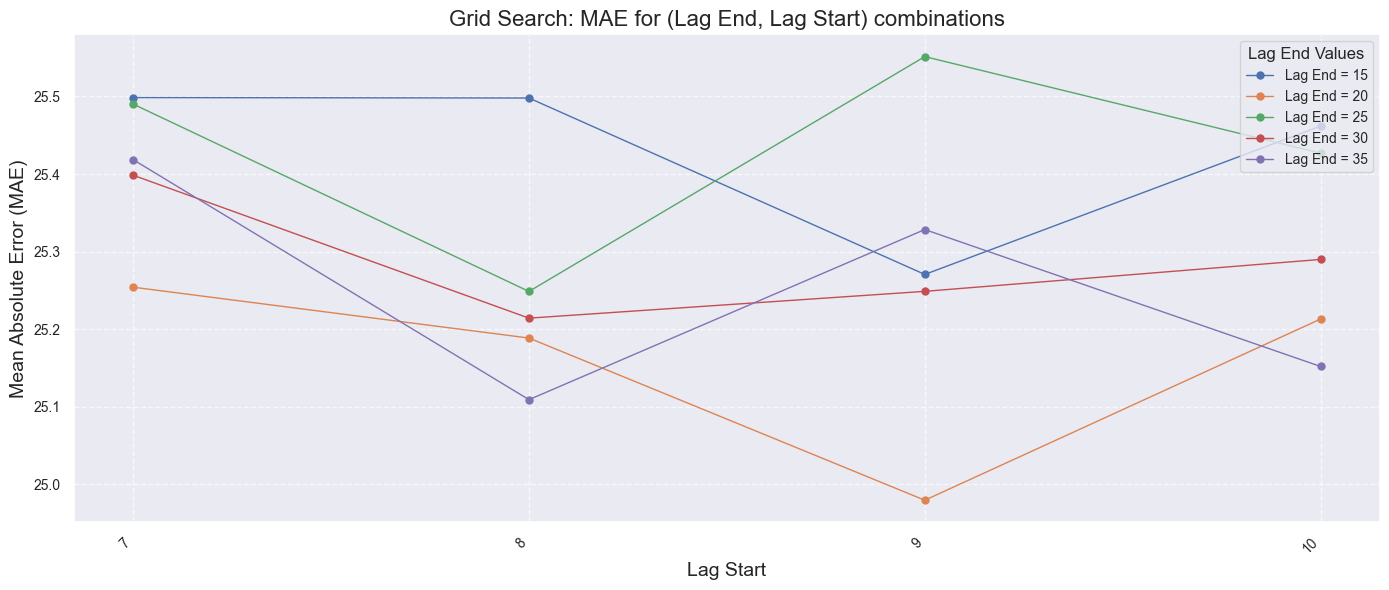

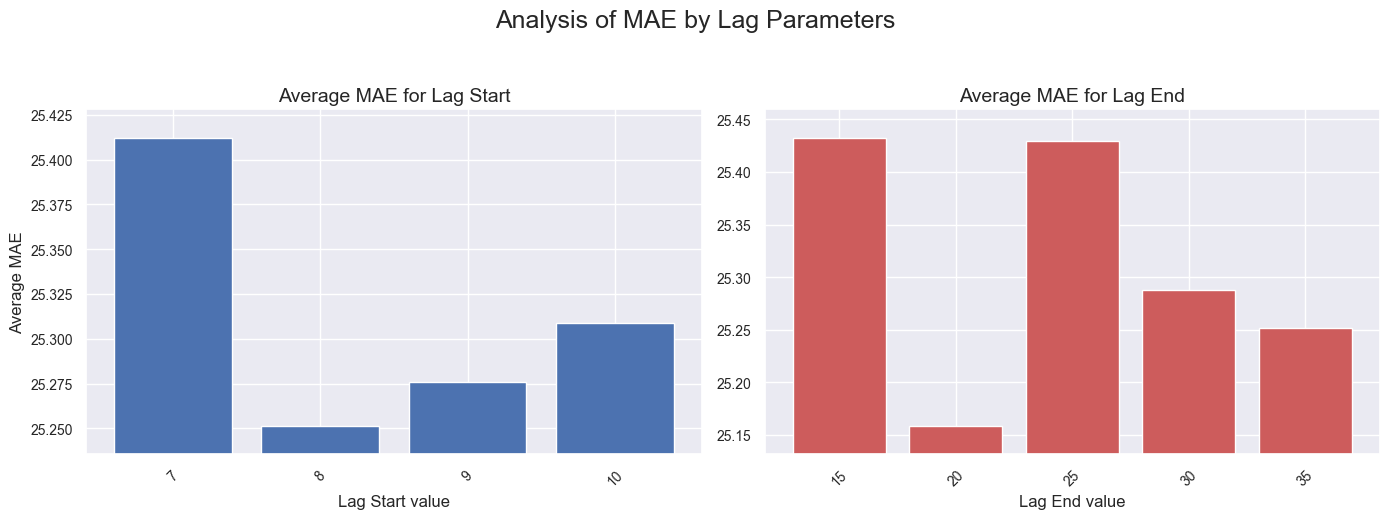

In [20]:
import matplotlib.pyplot as plt
import numpy as np # Для обработки NaN, если потребуется

# Предполагается, что lag_grid_mae_values и lag_avg_mae_statistics
# были получены из model_optimize_lags и доступны.

# --- График 1: Сетка параметров (Parameters grid) ---
plt.figure(figsize=(14, 6)) # Немного увеличил размер для лучшей читаемости
plt.title('Grid Search: MAE for (Lag End, Lag Start) combinations', fontsize=16)

# Сортируем ключи lag_end для более упорядоченного графика и легенды
sorted_lag_end_keys = sorted(lag_grid_mae_values.keys())

# Найдем все уникальные значения lag_start для корректных xticks
all_lag_start_keys = set()
for lag_end_key in sorted_lag_end_keys:
    if lag_grid_mae_values[lag_end_key]: # Проверяем, что словарь не пуст
        all_lag_start_keys.update(lag_grid_mae_values[lag_end_key].keys())
sorted_all_lag_start_keys = sorted(list(all_lag_start_keys))

# Построение линий для каждого lag_end
for lag_end_key in sorted_lag_end_keys:
    lag_start_to_mae_map = lag_grid_mae_values[lag_end_key]
    if not lag_start_to_mae_map: # Пропускаем, если для этого lag_end нет данных
        continue

    # Готовим данные для plot: сортируем по lag_start
    # и обрабатываем NaN (если они есть как float('nan'))
    plot_data_x = []
    plot_data_y = []
    
    temp_plot_data = sorted(lag_start_to_mae_map.items()) # [(lag_start, mae), ...]
    
    for lag_start, mae in temp_plot_data:
        plot_data_x.append(lag_start)
        plot_data_y.append(mae) # matplotlib.plot сам обработает np.nan, пропуская точку

    plt.plot(plot_data_x, plot_data_y, 'o-', label=f'Lag End = {lag_end_key}', markersize=5)

if sorted_all_lag_start_keys: # Если есть хоть какие-то данные
    plt.xticks(sorted_all_lag_start_keys, rotation=45, ha="right")
plt.xlabel('Lag Start', fontsize=14)
plt.ylabel('Mean Absolute Error (MAE)', fontsize=14)
plt.legend(loc='upper right', title='Lag End Values')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout() # Для лучшего расположения элементов
plt.show()


# --- График 2: Средние MAE для каждого значения параметра ---
fig, ax = plt.subplots(1, 2, figsize=(14, 5)) # Немного увеличил размер

# График для lag_start
start_stats = lag_avg_mae_statistics.get('start', {})
if start_stats:
    # Фильтруем NaN и inf перед построением, чтобы избежать ошибок и пустых баров
    valid_start_stats = {k: v for k, v in start_stats.items() if v != float('inf') and not np.isnan(v)}
    if valid_start_stats:
        sorted_start_keys = sorted(valid_start_stats.keys())
        start_values = [valid_start_stats[k] for k in sorted_start_keys]

        ax[0].bar([str(k) for k in sorted_start_keys], start_values) # Используем str(k) для меток, если ключи числовые
        # ax[0].set_xticks([str(k) for k in sorted_start_keys]) # Не нужно, если метки уже строки
        ax[0].set_title('Average MAE for Lag Start', fontsize=14)
        ax[0].set_xlabel('Lag Start value', fontsize=12)
        ax[0].set_ylabel('Average MAE', fontsize=12)
        ax[0].tick_params(axis='x', rotation=45)
        
        # Динамический ylim, если не хотим фиксированный
        if start_values:
            min_val_s = min(start_values)
            max_val_s = max(start_values)
            padding_s = (max_val_s - min_val_s) * 0.1 # 10% от диапазона
            ax[0].set_ylim([min_val_s - padding_s if min_val_s > padding_s else 0 , max_val_s + padding_s]) # Убедимся что не уходим в минус
    else:
        ax[0].text(0.5, 0.5, 'No valid data for Lag Start stats', ha='center', va='center')
        ax[0].set_title('Average MAE for Lag Start', fontsize=14)
else:
    ax[0].text(0.5, 0.5, 'No data for Lag Start stats', ha='center', va='center')
    ax[0].set_title('Average MAE for Lag Start', fontsize=14)


# График для lag_end
end_stats = lag_avg_mae_statistics.get('end', {})
if end_stats:
    valid_end_stats = {k: v for k, v in end_stats.items() if v != float('inf') and not np.isnan(v)}
    if valid_end_stats:
        sorted_end_keys = sorted(valid_end_stats.keys())
        end_values = [valid_end_stats[k] for k in sorted_end_keys]

        ax[1].bar([str(k) for k in sorted_end_keys], end_values, color='indianred') # Изменил цвет для разнообразия
        # ax[1].set_xticks([str(k) for k in sorted_end_keys])
        ax[1].set_title('Average MAE for Lag End', fontsize=14)
        ax[1].set_xlabel('Lag End value', fontsize=12)
        # ax[1].set_ylabel('Average MAE') # Ось Y общая, можно не дублировать
        ax[1].tick_params(axis='x', rotation=45)

        if end_values:
            min_val_e = min(end_values)
            max_val_e = max(end_values)
            padding_e = (max_val_e - min_val_e) * 0.1
            ax[1].set_ylim([min_val_e - padding_e if min_val_e > padding_e else 0, max_val_e + padding_e])
    else:
        ax[1].text(0.5, 0.5, 'No valid data for Lag End stats', ha='center', va='center')
        ax[1].set_title('Average MAE for Lag End', fontsize=14)
else:
    ax[1].text(0.5, 0.5, 'No data for Lag End stats', ha='center', va='center')
    ax[1].set_title('Average MAE for Lag End', fontsize=14)

fig.suptitle('Analysis of MAE by Lag Parameters', fontsize=18, y=1.03)
plt.tight_layout(rect=[0, 0, 1, 0.98]) # Оставляем место для suptitle
plt.show()

### Перебор оптимальных сочетаний параметров

Рассчитаем и сохраним прогнозы модели на тестовых данных, перебирая ряд параметров с фиксированием значения оптимального параметра

In [21]:
import pandas as pd
import numpy as np
# Предполагается, что:
# - TARGET определен (например, 'Price')
# - model_for_opt - это ваш настроенный экземпляр CatBoostRegressor
# - individual_opt_lag_start и individual_opt_lag_end определены из предыдущего шага
# - preprocess_data_hourly_no_leak определена
# - data - это ваш ПОЛНЫЙ DataFrame с данными (включая период для финального теста)
# - generate_lags определена (возьмем ее из предыдущего кода)

# --- Вспомогательная функция (если не определена в этой ячейке) ---
def generate_lags(lag_start, lag_end):
    """Генерирует список лагов от lag_start до lag_end-1."""
    if lag_start >= lag_end:
       return [lag_start] if lag_start > 0 else [1]
    return list(range(lag_start, lag_end))

# --- Параметры ---
# Размер финального тестового набора, на котором делаем эти прогнозы
FINAL_TEST_SIZE_HOURS = 24 * 7 # Пример: 7 дней

# --- Проверка наличия оптимальных параметров ---
if 'individual_opt_lag_start' not in locals() or individual_opt_lag_start is None:
    print("Ошибка: individual_opt_lag_start не определен. Запустите предыдущую ячейку.")
    exit() # или присвоить значение по умолчанию, если это допустимо

if 'individual_opt_lag_end' not in locals() or individual_opt_lag_end is None:
     print("Ошибка: individual_opt_lag_end не определен. Запустите предыдущую ячейку.")
     exit() # или присвоить значение по умолчанию


print(f"--- Генерация прогнозов с фиксированным lag_start = {individual_opt_lag_start} ---")
# ряд для оптимального значения lag_start_opt
# Используем тот же диапазон, что и в оригинальном коде
for lag_end_candidate in range(15, 40, 5): # 15, 20, 25, 30, 35

    if individual_opt_lag_start >= lag_end_candidate:
         print(f"Пропуск: lag_start ({individual_opt_lag_start}) >= lag_end ({lag_end_candidate})")
         continue

    print(f"  Обработка для lag_end = {lag_end_candidate}...")
    try:
        lags_list = generate_lags(individual_opt_lag_start, lag_end_candidate)
        X_train, X_test, y_train, y_test = preprocess_data_hourly_no_leak(
            data_input=data, # Используем полный набор данных
            target_col_name=TARGET,
            lags_to_create=lags_list,
            test_size_hours=FINAL_TEST_SIZE_HOURS # Размер финального теста
        )

        if X_test.empty or y_test.empty:
             print(f"  Предупреждение: Тестовая выборка пуста для lag_end={lag_end_candidate}. Пропуск.")
             continue

        # Обучаем модель на данных до финального теста
        model_for_opt.fit(X_train, y_train)
        preds = model_for_opt.predict(X_test)

        # Создаем результат с правильным DatetimeIndex
        X_result = pd.DataFrame(data=preds, index=y_test.index, columns=[TARGET])

        # Сохраним прогноз в файл
        filename = f'prediction_catboost_start_{individual_opt_lag_start}-end_{lag_end_candidate}.csv'
        X_result.to_csv(filename)
        print(f"  Прогноз сохранен в {filename}")

    except Exception as e:
         print(f"  Ошибка при обработке lag_end={lag_end_candidate}: {e}")


print(f"\n--- Генерация прогнозов с фиксированным lag_end = {individual_opt_lag_end} ---")
# ряд для оптимального значения lag_end_opt
# Используем тот же диапазон, что и в оригинальном коде
for lag_start_candidate in range(7, 11, 1): # 7, 8, 9, 10

    if lag_start_candidate >= individual_opt_lag_end:
         print(f"Пропуск: lag_start ({lag_start_candidate}) >= lag_end ({individual_opt_lag_end})")
         continue

    print(f"  Обработка для lag_start = {lag_start_candidate}...")
    try:
        lags_list = generate_lags(lag_start_candidate, individual_opt_lag_end)
        X_train, X_test, y_train, y_test = preprocess_data_hourly_no_leak(
            data_input=data, # Используем полный набор данных
            target_col_name=TARGET,
            lags_to_create=lags_list,
            test_size_hours=FINAL_TEST_SIZE_HOURS # Размер финального теста
        )

        if X_test.empty or y_test.empty:
             print(f"  Предупреждение: Тестовая выборка пуста для lag_start={lag_start_candidate}. Пропуск.")
             continue

        # Обучаем модель на данных до финального теста
        model_for_opt.fit(X_train, y_train)
        preds = model_for_opt.predict(X_test)

        # Создаем результат с правильным DatetimeIndex
        X_result = pd.DataFrame(data=preds, index=y_test.index, columns=[TARGET])

        # сохраним прогноз в файл
        filename = f'prediction_catboost_start_{lag_start_candidate}-end_{individual_opt_lag_end}.csv'
        X_result.to_csv(filename)
        print(f"  Прогноз сохранен в {filename}")

    except Exception as e:
        print(f"  Ошибка при обработке lag_start={lag_start_candidate}: {e}")

print("\nГенерация прогнозов завершена.")

--- Генерация прогнозов с фиксированным lag_start = 8 ---
  Обработка для lag_end = 15...
Размер X_train: (37971, 18), y_train: (37971,)
Размер X_test: (168, 18), y_test: (168,)
  Прогноз сохранен в prediction_catboost_start_8-end_15.csv
  Обработка для lag_end = 20...
Размер X_train: (37966, 23), y_train: (37966,)
Размер X_test: (168, 23), y_test: (168,)
  Прогноз сохранен в prediction_catboost_start_8-end_20.csv
  Обработка для lag_end = 25...
Размер X_train: (37961, 28), y_train: (37961,)
Размер X_test: (168, 28), y_test: (168,)
  Прогноз сохранен в prediction_catboost_start_8-end_25.csv
  Обработка для lag_end = 30...
Размер X_train: (37956, 33), y_train: (37956,)
Размер X_test: (168, 33), y_test: (168,)
  Прогноз сохранен в prediction_catboost_start_8-end_30.csv
  Обработка для lag_end = 35...
Размер X_train: (37951, 38), y_train: (37951,)
Размер X_test: (168, 38), y_test: (168,)
  Прогноз сохранен в prediction_catboost_start_8-end_35.csv

--- Генерация прогнозов с фиксированным l

## Оптимальный вариант (результат на kaggle: **212.58**)

In [22]:
lag_start = 10
lag_end = 35

### Обучение модели и прогнозирование

Рассчитаем прогноз модели с лучшими подобранными параметрами на тестовых данных

In [23]:
import pandas as pd
# Предполагается, что:
# - TARGET определен (например, 'Price')
# - preprocess_data_hourly_no_leak определена
# - data - это ваш ПОЛНЫЙ DataFrame с данными (включая период для финального теста)
# - generate_lags определена (возьмем ее из предыдущего кода)
# - lag_start_win и lag_end_win определены как 10 и 35 соответственно

# --- Вспомогательная функция (если не определена в этой ячейке) ---
def generate_lags(lag_start, lag_end):
    """Генерирует список лагов от lag_start до lag_end-1."""
    if lag_start >= lag_end:
       # Возвращаем хотя бы один осмысленный лаг или пустой список, если это предпочтительнее
       # В данном случае, если start >= end, это может быть ошибкой в параметрах,
       # но для совместимости с range, вернем пустой список, что приведет к ошибке дальше,
       # или можно вернуть [lag_start] если это логично.
       # Для примера, вернем хотя бы один лаг, если lag_start > 0.
        return [lag_start] if lag_start > 0 else [1] # Возвращаем [1] как дефолтный минимальный лаг
    return list(range(lag_start, lag_end))


# --- Параметры ---
# Победившие параметры лагов из предыдущего шага
lag_start_win = 10
lag_end_win = 35

# Размер финального тестового набора, который был отложен
FINAL_TEST_SIZE_HOURS = 24 * 7 # Убедись, что это то же значение, что и ранее

# Глобальная переменная (если не определена)
TARGET = 'Price'

# Генерируем список лагов на основе победивших параметров
final_lags_list = generate_lags(lag_start_win, lag_end_win)

print(f"Использование выбранных лагов: start={lag_start_win}, end={lag_end_win}")
print(f"  Список лагов для предобработки: {final_lags_list[:3]}...{final_lags_list[-3:]} (всего {len(final_lags_list)})")
print(f"Размер финального тестового набора: {FINAL_TEST_SIZE_HOURS} часов")


# --- Предобработка данных для финального теста ---
try:
    X_train, X_test, y_train, y_test = preprocess_data_hourly_no_leak(
        data_input=data, # Используем полный набор данных
        target_col_name=TARGET,
        lags_to_create=final_lags_list, # Передаем список лагов
        test_size_hours=FINAL_TEST_SIZE_HOURS # Размер финального теста
    )

    print('\nTrain length:', len(y_train))
    print('Test length:', len(y_test))

    print("\nПервые 5 строк X_test:")
    # Используем display() если в Jupyter/IPython, иначе print()
    try:
        from IPython.display import display
        display(X_test.head())
    except ImportError:
        print(X_test.head())
        
    # Проверим также размерности
    print(f"\nРазмерности: X_train={X_train.shape}, y_train={y_train.shape}, X_test={X_test.shape}, y_test={y_test.shape}")
    
    if X_test.empty or y_test.empty:
         print("\nПРЕДУПРЕЖДЕНИЕ: Финальная тестовая выборка пуста после предобработки!")


except Exception as e:
    print(f"\nОшибка при финальной предобработке данных: {e}")

Использование выбранных лагов: start=10, end=35
  Список лагов для предобработки: [10, 11, 12]...[32, 33, 34] (всего 25)
Размер финального тестового набора: 168 часов
Размер X_train: (37951, 36), y_train: (37951,)
Размер X_test: (168, 36), y_test: (168,)

Train length: 37951
Test length: 168

Первые 5 строк X_test:


,Open,High,Low,Change %,avg_overall_sentiment,avg_btc_specific_sentiment,sum_news_count,Price_lag_10h,Price_lag_11h,Price_lag_12h,...,Price_lag_29h,Price_lag_30h,Price_lag_31h,Price_lag_32h,Price_lag_33h,Price_lag_34h,hour_avg_Price,dayofweek_avg_Price,dayofmonth_avg_Price,month_avg_Price
2025-05-03 07:00:00,96183.50,96391.70,96157.10,0.14,0.0,0.0,0.0,96726.08,97022.31,96924.23,...,96952.58,96970.40,97042.97,96489.91,96372.33,96464.55,46380.889145,46359.529539,45983.847402,43813.02577
2025-05-03 08:00:00,96322.68,96421.91,96150.00,-0.04,0.0,0.0,0.0,96649.01,96726.08,97022.31,...,97102.32,96952.58,96970.40,97042.97,96489.91,96372.33,46393.793411,46359.529539,45983.847402,43813.02577
2025-05-03 09:00:00,96281.00,96396.23,96173.00,-0.03,0.0,0.0,0.0,96887.14,96649.01,96726.08,...,96939.86,97102.32,96952.58,96970.40,97042.97,96489.91,46395.983295,46359.529539,45983.847402,43813.02577
2025-05-03 10:00:00,96254.02,96254.02,95852.29,-0.37,0.0,0.0,0.0,96700.45,96887.14,96649.01,...,96707.54,96939.86,97102.32,96952.58,96970.40,97042.97,46392.112762,46359.529539,45983.847402,43813.02577
2025-05-03 11:00:00,95896.49,96083.53,95865.00,0.05,0.0,0.0,0.0,96493.94,96700.45,96887.14,...,96715.00,96707.54,96939.86,97102.32,96952.58,96970.40,46395.476435,46359.529539,45983.847402,43813.02577



Размерности: X_train=(37951, 36), y_train=(37951,), X_test=(168, 36), y_test=(168,)


Обучение финальной модели на X_train...
Получение предсказаний на X_test...


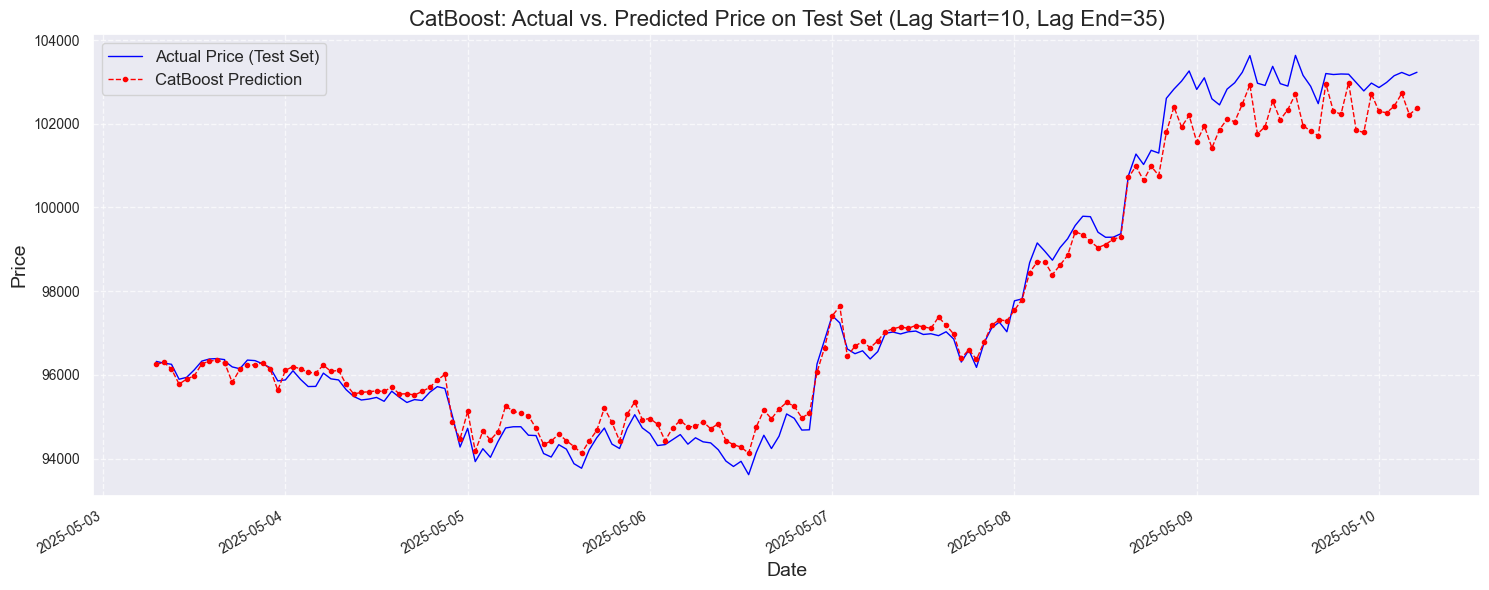


Метрики на финальном тестовом наборе:
  MAE: 364.7408
  RMSE: 472.9946


In [24]:
import matplotlib.pyplot as plt
import pandas as pd # Для создания DataFrame для графика

# Предполагается, что:
# - model_for_opt (экземпляр CatBoostRegressor) определен и настроен
# - X_train, y_train, X_test, y_test получены из предыдущей ячейки
# - TARGET определен

# --- Обучение финальной модели и предсказание ---
# Убедимся, что X_train и X_test не пусты, прежде чем обучать и предсказывать
if 'X_train' in locals() and not X_train.empty and 'X_test' in locals() and not X_test.empty:
    print("Обучение финальной модели на X_train...")
    try:
        # Используем модель, которая была настроена (например, model_for_opt)
        # Если вы хотите, чтобы модель обучалась с выводом, измените 'logging_level' в ее параметрах
        model_for_opt.fit(X_train, y_train)
        
        print("Получение предсказаний на X_test...")
        final_predictions = model_for_opt.predict(X_test)

        # --- Визуализация предсказаний ---
        plt.figure(figsize=(15, 6)) # Немного увеличим размер для наглядности

        # Для корректного отображения на временной оси, создадим Pandas Series
        # с предсказаниями и временным индексом из y_test
        predictions_series = pd.Series(final_predictions, index=y_test.index, name='Prediction')
        
        # Отобразим реальные значения y_test для сравнения
        y_test.plot(label='Actual Price (Test Set)', color='blue', linestyle='-')
        
        # Отобразим предсказания
        predictions_series.plot(label='CatBoost Prediction', color='red', linestyle='--', marker='o', markersize=3)
        
        plt.title(f"CatBoost: Actual vs. Predicted Price on Test Set (Lag Start={lag_start_win}, Lag End={lag_end_win})", fontsize=16)
        plt.xlabel("Date", fontsize=14)
        plt.ylabel(TARGET, fontsize=14) # Используем имя целевой переменной
        plt.legend(fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

        # Дополнительно можно вывести метрики на тестовом наборе
        from sklearn.metrics import mean_absolute_error, mean_squared_error
        
        mae_final_test = mean_absolute_error(y_test, final_predictions)
        rmse_final_test = np.sqrt(mean_squared_error(y_test, final_predictions))
        
        print(f"\nМетрики на финальном тестовом наборе:")
        print(f"  MAE: {mae_final_test:.4f}")
        print(f"  RMSE: {rmse_final_test:.4f}")
        
        # Сравнение с MAE, полученной на кросс-валидации (если она доступна)
        if 'best_mae_opt' in locals(): # Предполагаем, что эта переменная есть из оптимизации
            print(f"  Для сравнения, лучшая MAE на кросс-валидации была: {best_mae_opt:.4f}")

    except Exception as e:
        print(f"Ошибка во время обучения или предсказания: {e}")

else:
    print("X_train или X_test не определены или пусты. Обучение и предсказание не выполнены.")

Выведем график значимости признаков

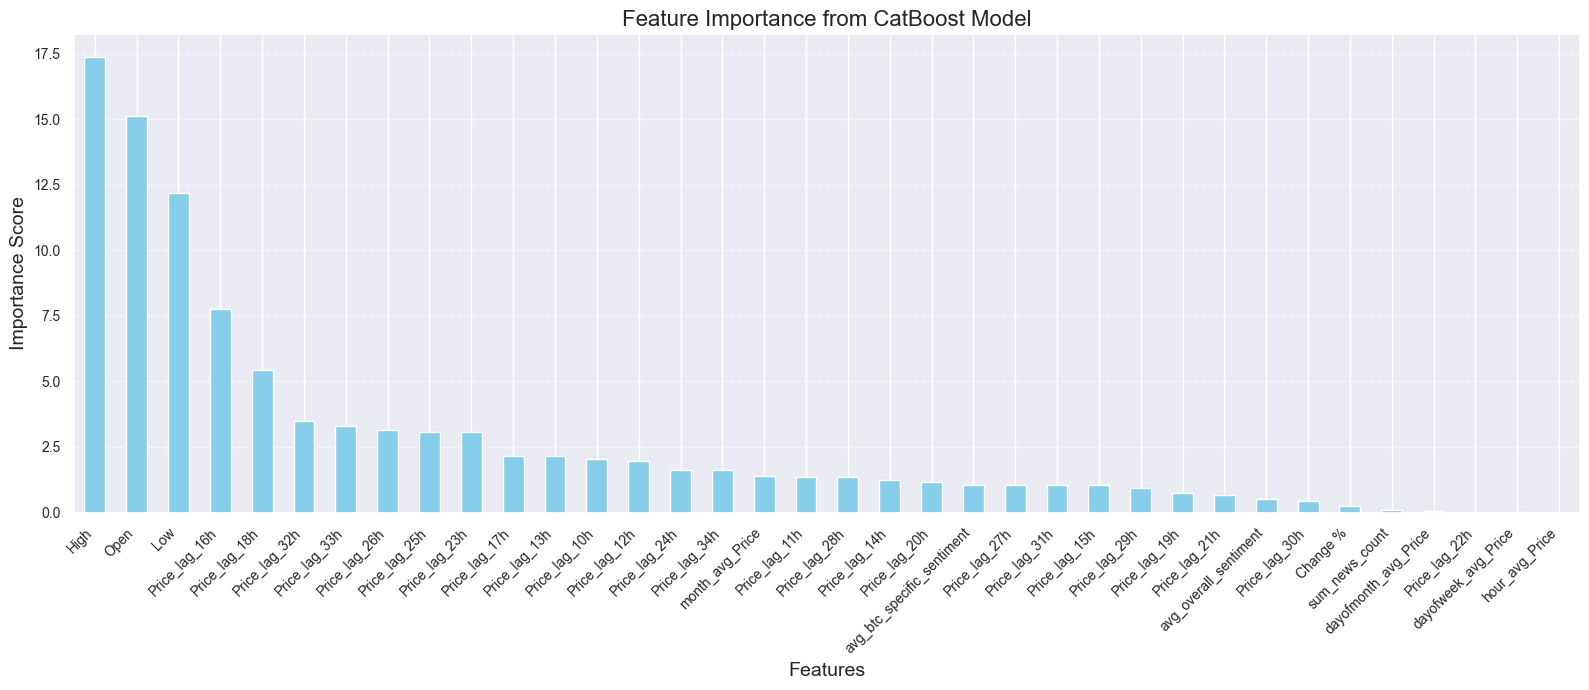


Топ-10 самых важных признаков:
High             17.364818
Open             15.140075
Low              12.185043
Price_lag_16h     7.769852
Price_lag_18h     5.417642
Price_lag_32h     3.495073
Price_lag_33h     3.314195
Price_lag_26h     3.152184
Price_lag_25h     3.088123
Price_lag_23h     3.058153
dtype: float64


In [25]:
import pandas as pd
import matplotlib.pyplot as plt

# Предполагается, что:
# - model_for_opt (экземпляр CatBoostRegressor) был обучен на X_train
# - X_train (или X_test, если их колонки идентичны и соответствуют тому, на чем обучалась модель) доступен
#   и содержит правильные имена колонок. Обычно лучше использовать X_train.columns,
#   так как модель обучалась именно на них.

# --- Получение и визуализация важности признаков ---
# Убедимся, что модель была обучена и X_train существует
if 'model_for_opt' in locals() and hasattr(model_for_opt, 'get_feature_importance') and \
   'X_train' in locals() and not X_train.empty: # Используем X_train.columns для большей корректности

    try:
        feature_importances = model_for_opt.get_feature_importance()
        
        # Создаем Pandas Series для удобства отображения
        # Важно использовать колонки из X_train, так как модель обучалась на них
        features_strength_series = pd.Series(feature_importances, index=X_train.columns)
        
        # Сортируем признаки по важности для лучшей визуализации
        features_strength_series_sorted = features_strength_series.sort_values(ascending=False)

        # --- Визуализация ---
        plt.figure(figsize=(16, 7)) # Можно настроить размер
        
        features_strength_series_sorted.plot.bar(color='skyblue')
        
        plt.title('Feature Importance from CatBoost Model', fontsize=16)
        plt.xlabel('Features', fontsize=14)
        # CatBoost get_feature_importance() по умолчанию возвращает проценты,
        # если PredictionValuesChange используется как тип важности.
        # Если используется другой тип, подпись оси Y может потребовать корректировки.
        # Для CatBoost по умолчанию (FeatureImportance), значения могут быть не в %,
        # а в абсолютных величинах вклада. Уточним это.
        # Для CatBoost, get_feature_importance() без параметров возвращает значения,
        # сумма которых не обязательно равна 100. Это скорее "сила" признака.
        plt.ylabel('Importance Score', fontsize=14) # Более общее название
        plt.xticks(rotation=45, ha="right", fontsize=10) # Поворот меток для длинных имен
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

        print("\nТоп-10 самых важных признаков:")
        print(features_strength_series_sorted.head(10))

    except Exception as e:
        print(f"Ошибка при получении или отображении важности признаков: {e}")
else:
    print("Модель не обучена или X_train не доступен для получения имен признаков.")

Сохраним результаты в файл

In [26]:
import pandas as pd

# Предполагается, что:
# - final_predictions (или preds) - массив NumPy с предсказаниями для X_test, полученный ранее
# - y_test - Pandas Series с фактическими значениями и DatetimeIndex для тестового периода
# - TARGET - имя целевой колонки (например, 'Price')
# - lag_start_win и lag_end_win - выбранные оптимальные параметры лагов (например, 10 и 35)

# --- Формирование и сохранение DataFrame с предсказаниями ---

# Используем выбранные оптимальные параметры лагов для имени файла
# Если ты хочешь использовать другие переменные, замени их здесь
lag_start_for_filename = lag_start_win # Например, 10
lag_end_for_filename = lag_end_win     # Например, 35

# Убедимся, что final_predictions и y_test существуют и имеют совместимые размеры
if 'final_predictions' in locals() and 'y_test' in locals() and \
   len(final_predictions) == len(y_test):

    try:
        # Создаем DataFrame для результатов предсказаний.
        # Индекс берем из y_test (он уже содержит правильные даты).
        # Колонку называем именем нашей целевой переменной.
        results_df = pd.DataFrame(
            data=final_predictions,
            index=y_test.index, # Используем DatetimeIndex из y_test
            columns=[TARGET]    # Название колонки - имя целевой переменной
        )

        # Имя файла для сохранения
        output_filename = f'prediction_catboost_final_lags_{lag_start_for_filename}-{lag_end_for_filename}.csv'
        
        # Сохраняем DataFrame в CSV файл
        results_df.to_csv(output_filename)
        
        print(f"Файл с предсказаниями сохранен как: {output_filename}")
        print("Первые 5 строк сохраненного файла:")
        print(results_df.head())

    except Exception as e:
        print(f"Ошибка при формировании или сохранении файла с предсказаниями: {e}")

else:
    if 'final_predictions' not in locals():
        print("Переменная 'final_predictions' с предсказаниями не найдена.")
    elif 'y_test' not in locals():
        print("Переменная 'y_test' с фактическими значениями/индексом не найдена.")
    else:
        print(f"Размеры final_predictions ({len(final_predictions) if 'final_predictions' in locals() else 'N/A'}) "
              f"и y_test ({len(y_test) if 'y_test' in locals() else 'N/A'}) не совпадают.")
    print("Файл с предсказаниями не был сохранен.")

Файл с предсказаниями сохранен как: prediction_catboost_final_lags_10-35.csv
Первые 5 строк сохраненного файла:
                            Price
2025-05-03 07:00:00  96249.220150
2025-05-03 08:00:00  96302.038507
2025-05-03 09:00:00  96141.159827
2025-05-03 10:00:00  95781.354901
2025-05-03 11:00:00  95899.326377


In [27]:
results_df

,Price
2025-05-03 07:00:00,96249.220150
2025-05-03 08:00:00,96302.038507
2025-05-03 09:00:00,96141.159827
2025-05-03 10:00:00,95781.354901
2025-05-03 11:00:00,95899.326377
...,...
2025-05-10 01:00:00,102262.856650
2025-05-10 02:00:00,102418.038305
2025-05-10 03:00:00,102726.144539
2025-05-10 04:00:00,102218.368467


Предсказания из файла 'prediction_catboost_final_lags_10-35.csv' успешно загружены.


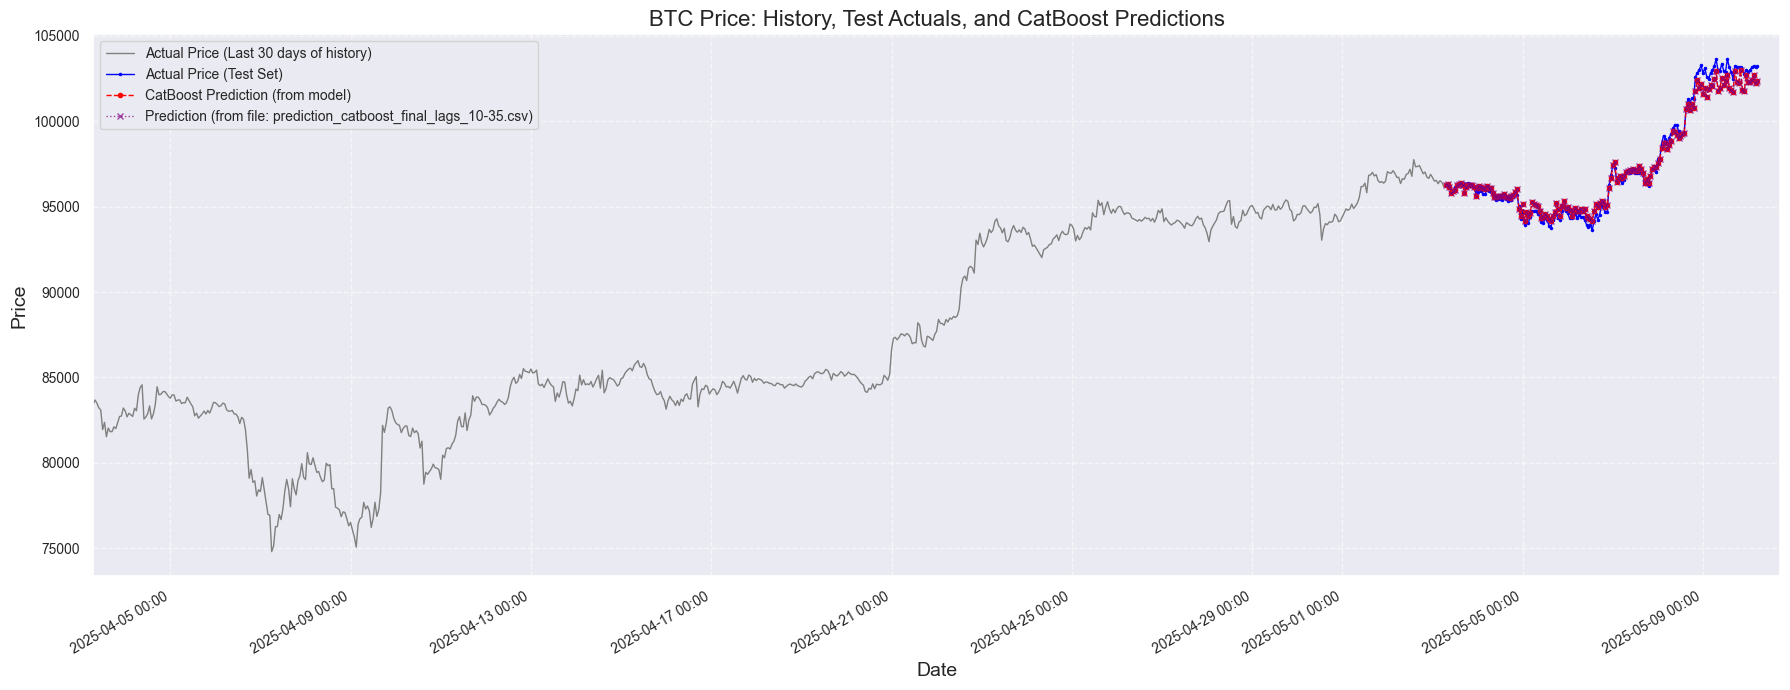

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates # Для форматирования дат на оси X

# --- Параметры и загрузка данных (убедись, что они актуальны) ---
TARGET = 'Price'
# Предполагаем, что 'data' - это полный DataFrame с исходными данными и DatetimeIndex
# 'y_test' - Series с фактическими значениями на тесте и DatetimeIndex
# 'final_predictions' - массив/Series предсказаний CatBoost на тесте

# Имя файла с предсказаниями CatBoost (сформированное ранее)
# Убедись, что lag_start_win и lag_end_win определены
if 'lag_start_win' not in locals() or 'lag_end_win' not in locals():
    print("Переменные lag_start_win и/или lag_end_win не определены. Использую значения по умолчанию (10, 35).")
    lag_start_win = 10 # Значение по умолчанию
    lag_end_win = 35   # Значение по умолчанию
    
catboost_prediction_filename = f'prediction_catboost_final_lags_{lag_start_win}-{lag_end_win}.csv'

# Загружаем предсказания из файла, если он существует
try:
    predictions_from_file_df = pd.read_csv(catboost_prediction_filename, index_col=0, parse_dates=True)
    # Убедимся, что индекс имеет правильную частоту, если это возможно (для консистентности с другими данными)
    if hasattr(predictions_from_file_df.index, 'asfreq') and hasattr(data.index, 'freq') and data.index.freq:
         try:
            predictions_from_file_df.index = predictions_from_file_df.index.asfreq(data.index.freq)
         except ValueError:
            print(f"Предупреждение: не удалось установить частоту {data.index.freq} для индекса файла {catboost_prediction_filename}")
    
    print(f"Предсказания из файла '{catboost_prediction_filename}' успешно загружены.")
    plot_file_predictions = True
except FileNotFoundError:
    print(f"Файл '{catboost_prediction_filename}' не найден. Предсказания из файла не будут отображены.")
    plot_file_predictions = False
except Exception as e:
    print(f"Ошибка при загрузке файла '{catboost_prediction_filename}': {e}")
    plot_file_predictions = False

# Убедимся, что y_test и final_predictions существуют
if 'y_test' not in locals() or not isinstance(y_test, pd.Series):
    print("Ошибка: y_test не определен или не является pd.Series. Невозможно построить график.")
    exit()
if 'final_predictions' not in locals() : # Проверяем только наличие, тип может быть np.array
    print("Ошибка: final_predictions не определены. Невозможно построить график.")
    exit()
if len(final_predictions) != len(y_test):
    print("Ошибка: Длины final_predictions и y_test не совпадают. Невозможно построить график.")
    exit()


# --- Определяем период для отображения ---
# Дата начала тестового периода
test_start_date = y_test.index.min()

# Дата начала для отображения исторических данных (например, 30 дней до начала теста)
history_display_days = 30
history_start_date = test_start_date - pd.Timedelta(days=history_display_days)

# Дата окончания тестового периода (для ограничения отображения)
test_end_date = y_test.index.max()

# Фильтруем исходные данные для отображения истории
history_data_to_plot = data[TARGET][(data.index >= history_start_date) & (data.index < test_start_date)]


# --- Построение графика ---
plt.figure(figsize=(18, 7))

# 1. Исторические данные (до тестового периода)
if not history_data_to_plot.empty:
    plt.plot(history_data_to_plot.index, history_data_to_plot.values, label=f'Actual Price (Last {history_display_days} days of history)', color='gray', linestyle='-')

# 2. Фактические данные на тестовом периоде
plt.plot(y_test.index, y_test.values, label='Actual Price (Test Set)', color='blue', linestyle='-', marker='.', markersize=3)

# 3. Предсказания CatBoost (из переменной final_predictions)
# Создаем Series с правильным индексом для удобства построения
catboost_predictions_series = pd.Series(final_predictions, index=y_test.index, name='CatBoost Live Prediction')
plt.plot(catboost_predictions_series.index, catboost_predictions_series.values, label='CatBoost Prediction (from model)', color='red', linestyle='--', marker='o', markersize=3)

# 4. Предсказания из файла (если загружены)
if plot_file_predictions:
    # Убедимся, что колонка с предсказаниями называется TARGET
    if TARGET in predictions_from_file_df.columns:
        plt.plot(predictions_from_file_df.index, predictions_from_file_df[TARGET], label=f'Prediction (from file: {catboost_prediction_filename})', color='purple', linestyle=':', marker='x', markersize=4, alpha=0.7)
    else:
        print(f"Предупреждение: Колонка '{TARGET}' не найдена в файле {catboost_prediction_filename}. Отображаю первую колонку.")
        plt.plot(predictions_from_file_df.index, predictions_from_file_df.iloc[:, 0], label=f'Prediction (from file, 1st col)', color='purple', linestyle=':', marker='x', markersize=4, alpha=0.7)


# Настройка графика
plt.title(f'BTC Price: History, Test Actuals, and CatBoost Predictions', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel(TARGET, fontsize=14)
plt.legend(fontsize=10, loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)

# Форматирование оси X для лучшей читаемости дат
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M')) # Формат даты и времени
ax.xaxis.set_major_locator(mdates.AutoDateLocator(minticks=5, maxticks=12)) # Автоматический выбор количества меток
plt.xticks(rotation=30, ha='right')

# Ограничим диапазон оси X, чтобы график не был слишком растянут, если история очень длинная
# и чтобы четко видеть переход от истории к тесту
overall_plot_start_date = history_start_date
overall_plot_end_date = test_end_date + pd.Timedelta(hours=12) # небольшой запас после теста
plt.xlim([overall_plot_start_date, overall_plot_end_date])


plt.tight_layout()
plt.show()

## Рекурсивный прогноз

Последняя известная дата в данных: 2025-05-10 05:00:00
Прогнозируем на 168 часов вперед...
Размер X_train: (38119, 32), y_train: (38119,)
Размер X_test: (1, 32), y_test: (1,)
KeyError на шаге 1 рекурсивного прогноза: "Отсутствуют колонки в X_future_step ПОСЛЕ добавления Change %: {'sum_news_count', 'avg_btc_specific_sentiment', 'avg_overall_sentiment'}."
Размер X_train: (38119, 32), y_train: (38119,)
Размер X_test: (1, 32), y_test: (1,)
KeyError на шаге 2 рекурсивного прогноза: "Отсутствуют колонки в X_future_step ПОСЛЕ добавления Change %: {'sum_news_count', 'avg_btc_specific_sentiment', 'avg_overall_sentiment'}."
Размер X_train: (38120, 32), y_train: (38120,)
Размер X_test: (1, 32), y_test: (1,)
KeyError на шаге 3 рекурсивного прогноза: "Отсутствуют колонки в X_future_step ПОСЛЕ добавления Change %: {'sum_news_count', 'avg_btc_specific_sentiment', 'avg_overall_sentiment'}."
Размер X_train: (38121, 32), y_train: (38121,)
Размер X_test: (1, 32), y_test: (1,)
KeyError на шаге 4 рекурсив

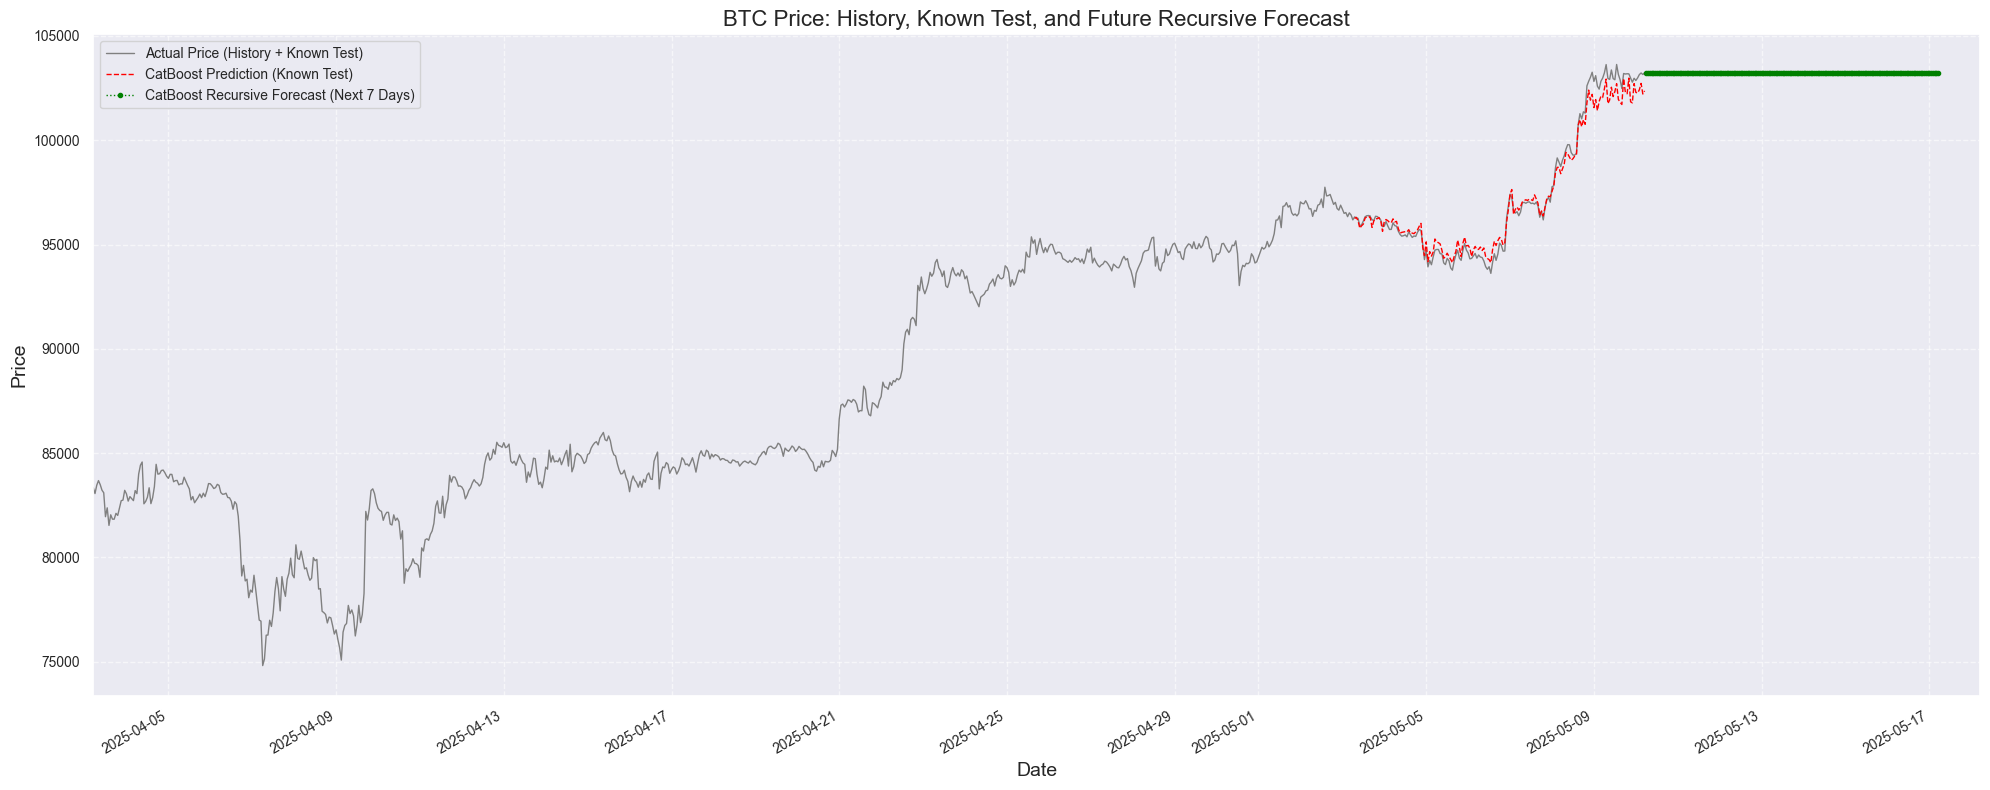

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# --- Предположения и параметры ---
# ... (все переменные как раньше) ...

# Убедимся, что все нужные переменные существуют
required_vars = ['TARGET', 'model_for_opt', 'X_train', 'y_test', 'final_predictions',
                 'lag_start_win', 'lag_end_win', 'generate_lags', 
                 'preprocess_data_hourly_no_leak', 'data']
for var_name in required_vars:
    if var_name not in locals():
        print(f"Ошибка: Переменная '{var_name}' не определена. Невозможно продолжить.")
        exit()

future_forecast_horizon_hours = 24 * 7
last_known_datetime = data.index[-1]

print(f"Последняя известная дата в данных: {last_known_datetime}")
print(f"Прогнозируем на {future_forecast_horizon_hours} часов вперед...")

future_recursive_preds_list = []
future_datetimes_list = []

rolling_data_df = data.copy() 
base_cols_to_fill = ['Open', 'High', 'Low']
for col in base_cols_to_fill:
    if col not in rolling_data_df.columns:
        rolling_data_df[col] = rolling_data_df[TARGET]

# --- Рекурсивное прогнозирование ---
current_future_datetime = last_known_datetime
for i in range(future_forecast_horizon_hours):
    current_future_datetime += pd.Timedelta(hours=1)
    future_datetimes_list.append(current_future_datetime)
    
    prev_target_val_for_ohl = rolling_data_df[TARGET].iloc[-1] # Цена предыдущего шага для OHL
    
    future_row_data = {col: prev_target_val_for_ohl for col in base_cols_to_fill}
    future_row_data[TARGET] = 0 # Фиктивное значение для TARGET
    future_row_df = pd.DataFrame(future_row_data, index=[current_future_datetime])
    temp_df_for_preprocess = pd.concat([rolling_data_df[base_cols_to_fill + [TARGET]], future_row_df])
    
    predicted_value = np.nan # Инициализируем на случай ошибки

    try:
        _, X_future_step, _, y_future_step_dummy = preprocess_data_hourly_no_leak( # y_future_step_dummy не используется
            data_input=temp_df_for_preprocess,
            target_col_name=TARGET,
            lags_to_create=generate_lags(lag_start_win, lag_end_win),
            test_size_hours=1
        )

        if X_future_step.empty:
            print(f"Шаг {i+1}: X_future_step пуст. Используем предыдущий прогноз или значение OHL.")
            predicted_value = future_recursive_preds_list[-1] if future_recursive_preds_list else prev_target_val_for_ohl
        else:
            # --- НАЧАЛО ИЗМЕНЕНИЙ ДЛЯ Change % ---
            # Рассчитываем 'Change %' для X_future_step
            # 'Change %' - это (текущая цена - предыдущая цена) / предыдущая цена * 100
            # "Текущая цена" для расчета Change % здесь будет prev_target_val_for_ohl,
            # так как X_future_step формируется ДО того, как мы узнаем `predicted_value`
            # Цена еще более предыдущего шага (для знаменателя)
            if len(rolling_data_df[TARGET]) >= 2:
                price_t_minus_1 = prev_target_val_for_ohl # Это цена в T (для X_future_step в T+1)
                price_t_minus_2 = rolling_data_df[TARGET].iloc[-2] # Это цена в T-1
                if price_t_minus_2 != 0: # Избегаем деления на ноль
                    change_percent = ((price_t_minus_1 - price_t_minus_2) / price_t_minus_2) * 100
                else:
                    change_percent = 0.0 # или np.nan
            else: # Для самого первого шага или если истории мало
                change_percent = 0.0 # или np.nan
            
            # Добавляем рассчитанный 'Change %' в X_future_step
            # Важно: X_future_step это DataFrame, присваиваем значение для его единственной строки
            X_future_step.loc[X_future_step.index[0], 'Change %'] = change_percent
            # --- КОНЕЦ ИЗМЕНЕНИЙ ДЛЯ Change % ---

            missing_cols = set(X_train.columns) - set(X_future_step.columns)
            if missing_cols:
                 # Если после добавления Change % все еще чего-то не хватает (не должно быть)
                raise KeyError(f"Отсутствуют колонки в X_future_step ПОСЛЕ добавления Change %: {missing_cols}.")
            
            X_future_step_aligned = X_future_step[X_train.columns]
            predicted_value = model_for_opt.predict(X_future_step_aligned)[0]
            
    except KeyError as ke:
        print(f"KeyError на шаге {i+1} рекурсивного прогноза: {ke}")
        # ... (остальная обработка KeyError) ...
        predicted_value = future_recursive_preds_list[-1] if future_recursive_preds_list else prev_target_val_for_ohl
    except Exception as e_pred_step:
        print(f"Общая ошибка на шаге {i+1} рекурсивного прогноза: {e_pred_step}")
        # ... (остальная обработка Exception) ...
        predicted_value = future_recursive_preds_list[-1] if future_recursive_preds_list else prev_target_val_for_ohl

    future_recursive_preds_list.append(predicted_value)
    
    new_ohlc_row_data = {col: predicted_value for col in base_cols_to_fill}
    new_ohlc_row_data[TARGET] = predicted_value
    # 'Change %' для rolling_data_df (если мы его там храним) тоже нужно обновить
    # Это будет ((predicted_value - prev_target_val_for_ohl) / prev_target_val_for_ohl) * 100
    if prev_target_val_for_ohl != 0:
        current_change_percent_for_storage = ((predicted_value - prev_target_val_for_ohl) / prev_target_val_for_ohl) * 100
    else:
        current_change_percent_for_storage = 0.0
    
    if 'Change %' in rolling_data_df.columns: # Если мы вообще храним Change % в rolling_data_df
        new_ohlc_row_data['Change %'] = current_change_percent_for_storage
    
    new_ohlc_row_df = pd.DataFrame(new_ohlc_row_data, index=[current_future_datetime])
    rolling_data_df = pd.concat([rolling_data_df, new_ohlc_row_df])
    rolling_data_df = rolling_data_df[~rolling_data_df.index.duplicated(keep='last')]

    if (i + 1) % 24 == 0:
        print(f"  Рекурсивный прогноз: шаг {i+1}/{future_forecast_horizon_hours} завершен. Предсказано: {predicted_value:.2f}")

future_recursive_predictions_series = pd.Series(future_recursive_preds_list, index=pd.DatetimeIndex(future_datetimes_list), name='CatBoost Recursive Future Forecast')

# --- Визуализация (код остается тем же) ---
# ... (код визуализации как в предыдущем ответе) ...
plt.figure(figsize=(20, 8))
history_plus_test_end_date = y_test.index.max() if 'y_test' in locals() and not y_test.empty else data.index.max()
history_plus_test_start_date = history_plus_test_end_date - pd.Timedelta(days=30 + 7)
data_to_plot_history = data[TARGET][(data.index >= history_plus_test_start_date) & (data.index <= history_plus_test_end_date)]
if not data_to_plot_history.empty:
    plt.plot(data_to_plot_history.index, data_to_plot_history.values, label=f'Actual Price (History + Known Test)', color='gray', linestyle='-')
if 'final_predictions' in locals() and 'y_test' in locals() and not y_test.empty and len(final_predictions) == len(y_test):
    known_test_predictions_series = pd.Series(final_predictions, index=y_test.index)
    plt.plot(known_test_predictions_series.index, known_test_predictions_series.values, label='CatBoost Prediction (Known Test)', color='red', linestyle='--')
if not future_recursive_predictions_series.empty:
    plt.plot(future_recursive_predictions_series.index, future_recursive_predictions_series.values, label=f'CatBoost Recursive Forecast (Next {future_forecast_horizon_hours/24:.0f} Days)', color='green', linestyle=':', marker='.')
plt.title(f'BTC Price: History, Known Test, and Future Recursive Forecast', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel(TARGET, fontsize=14)
plt.legend(fontsize=10, loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_locator(mdates.AutoDateLocator(minticks=8, maxticks=15))
plt.xticks(rotation=30, ha='right')
plot_overall_start = history_plus_test_start_date
plot_overall_end = future_recursive_predictions_series.index.max() + pd.Timedelta(days=1) if not future_recursive_predictions_series.empty else history_plus_test_end_date + pd.Timedelta(days=1)
plt.xlim([plot_overall_start, plot_overall_end])
plt.tight_layout()
plt.show()

## Для диплома


Эксперимент 1: Оценка качества прогнозов на различных горизонтах


--- Обработка горизонта: 1 дней (24 часов) ---
Горизонт 1 дней: MAE=2934.02, RMSE=3473.51, MAPE=3.06%
  Сохранена важность признаков для 1 дней.

--- Обработка горизонта: 2 дней (48 часов) ---
Горизонт 2 дней: MAE=4766.20, RMSE=5724.78, MAPE=4.96%

--- Обработка горизонта: 3 дней (72 часов) ---
Горизонт 3 дней: MAE=6056.62, RMSE=6695.75, MAPE=6.32%

--- Обработка горизонта: 4 дней (96 часов) ---
Горизонт 4 дней: MAE=6893.43, RMSE=7498.69, MAPE=7.20%

--- Обработка горизонта: 5 дней (120 часов) ---
Горизонт 5 дней: MAE=6164.12, RMSE=7995.69, MAPE=6.38%

--- Обработка горизонта: 6 дней (144 часов) ---
Горизонт 6 дней: MAE=5273.54, RMSE=7475.75, MAPE=5.43%

--- Обработка горизонта: 7 дней (168 часов) ---
Горизонт 7 дней: MAE=4498.25, RMSE=6641.98, MAPE=4.63%
  Сохранена важность признаков для 7 дней.

--- Обработка горизонта: 8 дней (192 часов) ---
Горизонт 8 дней: MAE=3630.30, RMSE=5464.03, MAPE=3.75%

--- Обработка гори

Горизонт (дни),MAE,RMSE,MAPE
1,2934.02,3473.51,3.06%
2,4766.20,5724.78,4.96%
3,6056.62,6695.75,6.32%
4,6893.43,7498.69,7.20%
5,6164.12,7995.69,6.38%
6,5273.54,7475.75,5.43%
7,4498.25,6641.98,4.63%
8,3630.30,5464.03,3.75%
9,4306.70,5311.36,4.51%
10,4577.91,5322.76,4.80%


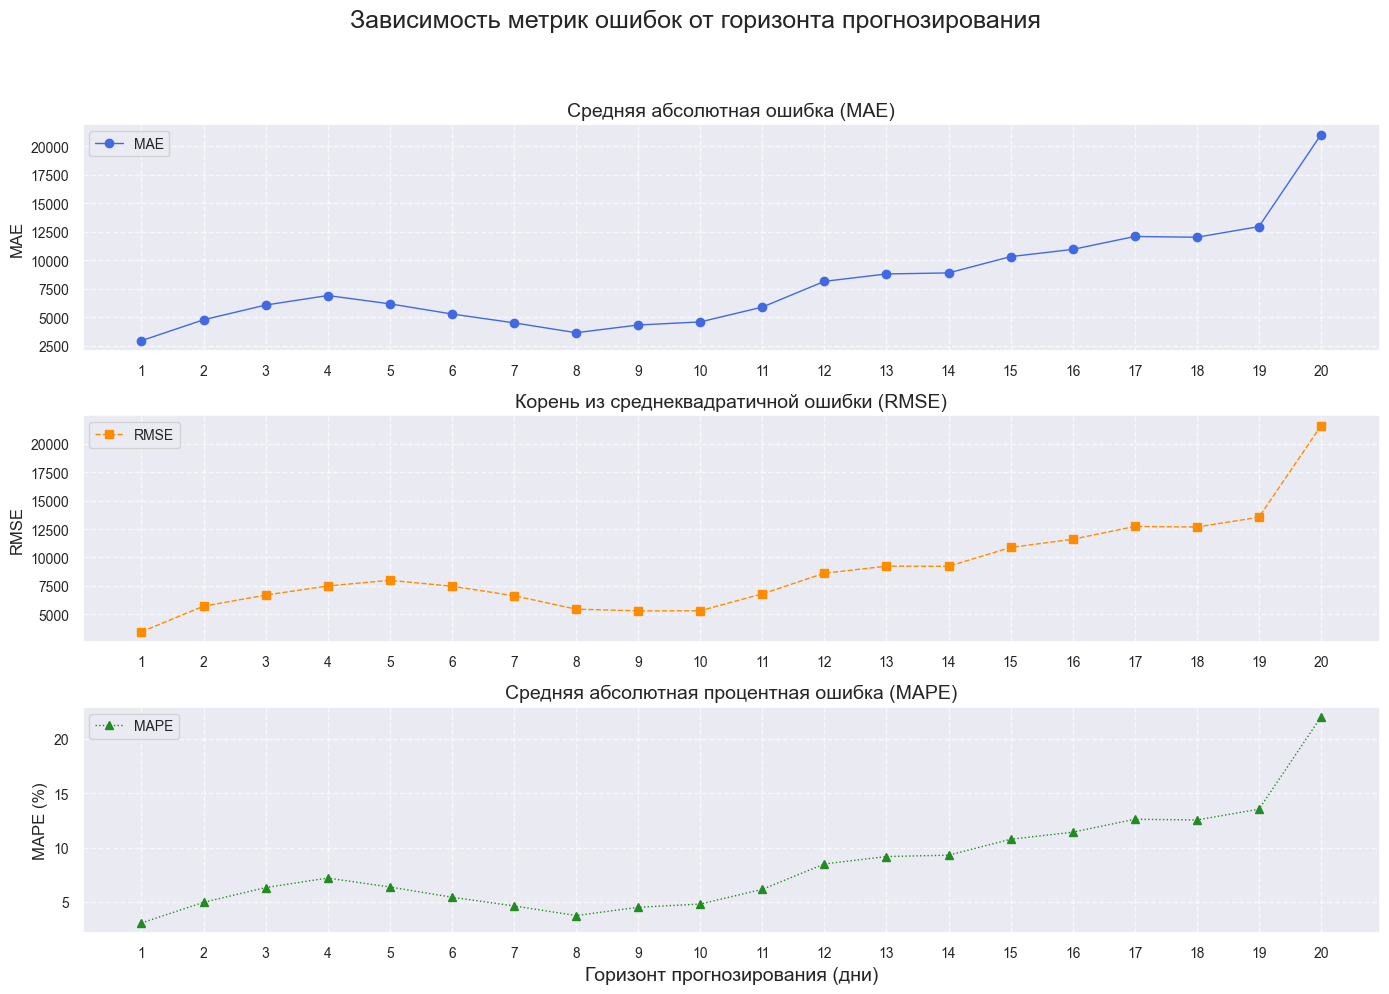


(Пример описания графика 1): На Рисунке [Номер рисунка] представлена зависимость метрик ошибок (MAE, RMSE, MAPE) от горизонта прогнозирования.
Анализируйте график согласно вашим ожиданиям и результатам.


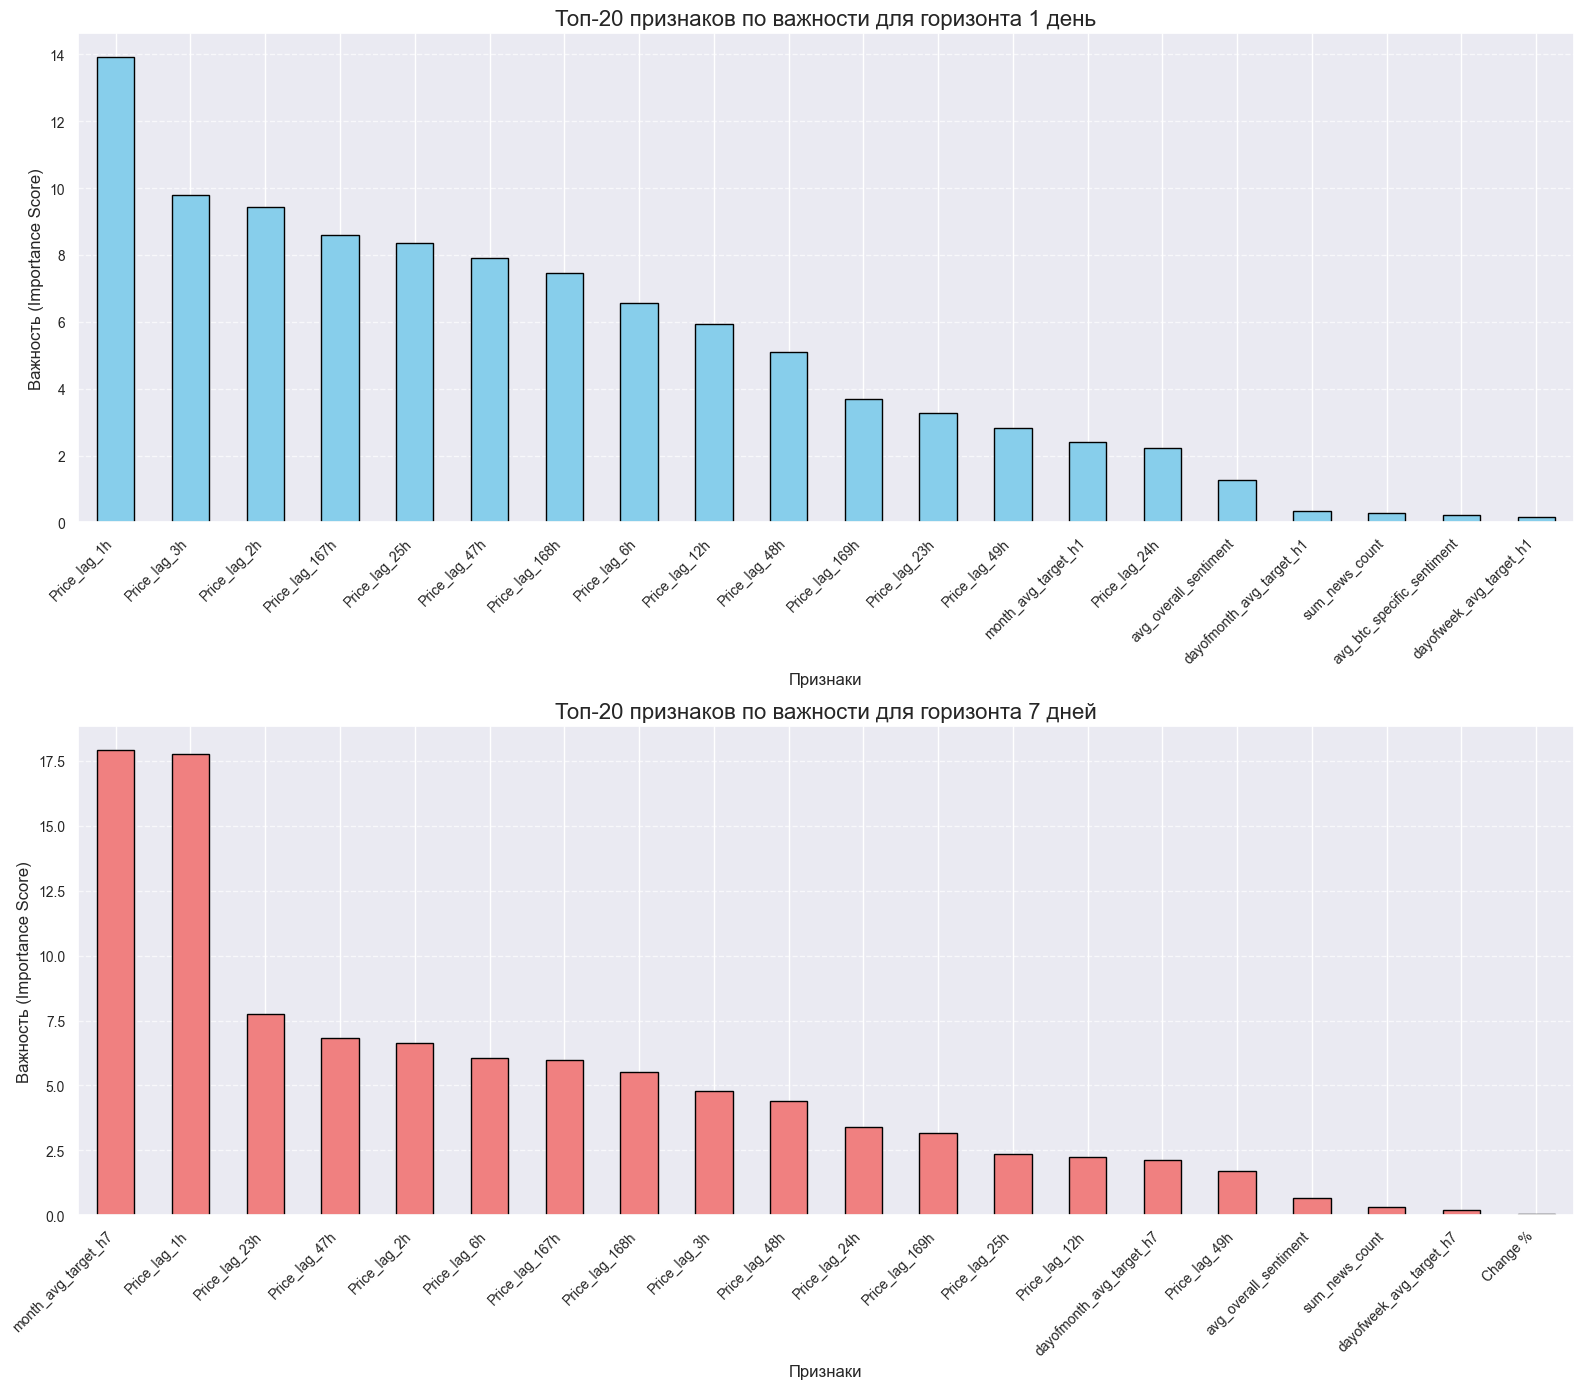


(Пример описания графика 2): На Рисунке [Номер рисунка] показана важность признаков для моделей с горизонтом 1 день и 7 дней.
Анализируйте графики согласно вашим ожиданиям и результатам.

Эксперимент 1 завершен.


In [40]:
# КОД ИЗ ПРЕДЫДУЩИХ ЯЧЕЕК НОУТБУКА ...
# ...
# plt.xlim([overall_plot_start_date, overall_plot_end_date])
# plt.tight_layout()
# plt.show()

# <<< ЗДЕСЬ НАЧАЛО ВАШЕЙ НОВОЙ ЯЧЕЙКИ ДЛЯ ЭКСПЕРИМЕНТА 1 >>>

print("\nЭксперимент 1: Оценка качества прогнозов на различных горизонтах")
print("=================================================================\n")

# --- 0. Необходимые импорты и функции (если что-то не импортировано глобально) ---
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from IPython.display import HTML, display # Для красивого вывода таблицы

# Убедимся, что TARGET, data, catboost_model_params определены из предыдущих ячеек
# TARGET = 'Price'
# catboost_model_params = { 'n_estimators': ..., ... }
# data - ваш основной DataFrame с ценами и признаками

# Функция для MAPE (если ее нет в вашем окружении)
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_mask = y_true != 0
    if np.sum(non_zero_mask) == 0: # Все y_true нули или пустой массив
        return np.nan if len(y_true) > 0 else 0.0
    return np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])) * 100

# Функция code_mean (если она не в глобальной области видимости или для ясности)
# def code_mean(data_subset, cat_feature, real_feature):
#     return dict(data_subset.groupby(cat_feature)[real_feature].mean())
# Она должна быть доступна из предыдущих ячеек.

# --- 1. Константы для эксперимента ---
# HORIZONS_DAYS = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20] # Оставим полный список для графика метрик
HORIZONS_DAYS_ALL = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
HORIZONS_HOURS_ALL = [h * 24 for h in HORIZONS_DAYS_ALL]

HORIZONS_FOR_FEATURE_IMPORTANCE = [1, 7] # Дни, для которых сохраняем важность признаков

if 'custom_lags' not in locals():
    print("Предупреждение: 'custom_lags' не найдены. Использую дефолтный набор лагов.")
    custom_lags = [1, 2, 3, 6, 12, 24, 24*2, 24*3, 24*7]
LAGS_CONFIG = custom_lags

EXPERIMENT_TEST_SIZE_HOURS = max(HORIZONS_DAYS_ALL) * 24 # Тест должен покрывать самый длинный горизонт из всех рассматриваемых

metrics_results_list = []
feature_importances_dict = {}

# --- 2. Основной цикл по горизонтам ---
for h_days, h_hours in zip(HORIZONS_DAYS_ALL, HORIZONS_HOURS_ALL): # Используем полный список для расчета всех метрик
    print(f"\n--- Обработка горизонта: {h_days} дней ({h_hours} часов) ---")

    data_for_horizon = data.copy()
    data_for_horizon['y_model_future'] = data_for_horizon[TARGET].shift(-h_hours)

    for lag in LAGS_CONFIG:
        data_for_horizon[f'{TARGET}_lag_{lag}h'] = data_for_horizon[TARGET].shift(lag)

    data_for_horizon['hour'] = data_for_horizon.index.hour
    data_for_horizon['dayofweek'] = data_for_horizon.index.dayofweek
    data_for_horizon['dayofmonth'] = data_for_horizon.index.day
    data_for_horizon['month'] = data_for_horizon.index.month
    
    news_cols = ['avg_overall_sentiment', 'avg_btc_specific_sentiment', 'sum_news_count', 'Change %']
    for nc in news_cols:
        if nc not in data_for_horizon.columns and nc in data.columns:
             data_for_horizon[nc] = data[nc]
        elif nc not in data_for_horizon.columns:
             data_for_horizon[nc] = 0

    data_for_horizon.dropna(inplace=True)

    if data_for_horizon.empty:
        print(f"Горизонт {h_days} дней: нет данных после создания признаков/цели. Пропуск.")
        metrics_results_list.append({'Горизонт (дни)': h_days, 'MAE': np.nan, 'RMSE': np.nan, 'MAPE': np.nan})
        continue

    y_full_h = data_for_horizon['y_model_future']
    cols_to_drop_from_X = [TARGET, 'y_model_future', 'Open', 'High', 'Low']
    cols_present_in_df = [col for col in cols_to_drop_from_X if col in data_for_horizon.columns]
    X_full_h = data_for_horizon.drop(columns=cols_present_in_df)

    if EXPERIMENT_TEST_SIZE_HOURS >= len(X_full_h):
        print(f"Горизонт {h_days} дней: EXPERIMENT_TEST_SIZE_HOURS ({EXPERIMENT_TEST_SIZE_HOURS}) "
              f">= длина обработанных данных ({len(X_full_h)}). Пропуск.")
        metrics_results_list.append({'Горизонт (дни)': h_days, 'MAE': np.nan, 'RMSE': np.nan, 'MAPE': np.nan})
        continue

    X_train_h_exp = X_full_h.iloc[:-EXPERIMENT_TEST_SIZE_HOURS]
    y_train_h_exp = y_full_h.iloc[:-EXPERIMENT_TEST_SIZE_HOURS]
    X_test_h_exp = X_full_h.iloc[-EXPERIMENT_TEST_SIZE_HOURS:]
    y_test_h_exp = y_full_h.iloc[-EXPERIMENT_TEST_SIZE_HOURS:]

    if X_train_h_exp.empty or X_test_h_exp.empty:
        print(f"Горизонт {h_days} дней: обучающая или тестовая выборка пусты. Пропуск.")
        metrics_results_list.append({'Горизонт (дни)': h_days, 'MAE': np.nan, 'RMSE': np.nan, 'MAPE': np.nan})
        continue

    features_for_mean_encoding_exp = ['hour', 'dayofweek', 'dayofmonth', 'month']
    X_train_h_encoded = X_train_h_exp.copy()
    X_test_h_encoded = X_test_h_exp.copy()
    
    train_df_for_encoding = X_train_h_exp.copy()
    train_df_for_encoding['__target_for_encoding__'] = y_train_h_exp
    global_mean_target_train_exp = y_train_h_exp.mean()

    for feat_cat in features_for_mean_encoding_exp:
        if feat_cat in X_train_h_encoded.columns:
            means = code_mean(train_df_for_encoding, feat_cat, '__target_for_encoding__')
            X_train_h_encoded[f'{feat_cat}_avg_target_h{h_days}'] = X_train_h_encoded[feat_cat].map(means).fillna(global_mean_target_train_exp)
            X_test_h_encoded[f'{feat_cat}_avg_target_h{h_days}'] = X_test_h_encoded[feat_cat].map(means).fillna(global_mean_target_train_exp)
            X_train_h_encoded.drop(feat_cat, axis=1, inplace=True)
            X_test_h_encoded.drop(feat_cat, axis=1, inplace=True)
        else:
            print(f"Предупреждение для горизонта {h_days}дн: признак '{feat_cat}' не найден для mean encoding.")

    train_cols = set(X_train_h_encoded.columns)
    test_cols = set(X_test_h_encoded.columns)
    if train_cols != test_cols:
        print(f"Несовпадение колонок для горизонта {h_days}дн! Выравнивание...")
        all_cols = list(train_cols) # Берем колонки из трейна как эталон
        X_test_h_aligned = pd.DataFrame(columns=all_cols, index=X_test_h_encoded.index)
        for col in all_cols:
            if col in X_test_h_encoded.columns:
                X_test_h_aligned[col] = X_test_h_encoded[col]
            else:
                X_test_h_aligned[col] = global_mean_target_train_exp # Заполняем недостающие
        X_test_h_encoded = X_test_h_aligned[all_cols] # Убеждаемся в порядке и наличии всех колонок

    model_exp = CatBoostRegressor(**catboost_model_params)
    model_exp.fit(X_train_h_encoded, y_train_h_exp, verbose=0)
    y_pred_h_exp = model_exp.predict(X_test_h_encoded)

    mae_exp = mean_absolute_error(y_test_h_exp, y_pred_h_exp)
    rmse_exp = np.sqrt(mean_squared_error(y_test_h_exp, y_pred_h_exp))
    mape_exp = mean_absolute_percentage_error(y_test_h_exp, y_pred_h_exp)

    metrics_results_list.append({
        'Горизонт (дни)': h_days,
        'MAE': mae_exp,
        'RMSE': rmse_exp,
        'MAPE': mape_exp
    })
    print(f"Горизонт {h_days} дней: MAE={mae_exp:.2f}, RMSE={rmse_exp:.2f}, MAPE={mape_exp:.2f}%")

    if h_days in HORIZONS_FOR_FEATURE_IMPORTANCE: # Используем новый список
        fi = pd.Series(model_exp.get_feature_importance(), index=X_train_h_encoded.columns)
        feature_importances_dict[f'{h_days}_days'] = fi.sort_values(ascending=False)
        print(f"  Сохранена важность признаков для {h_days} дней.")

In [46]:
# --- 3. Результаты и графики ---
metrics_df = pd.DataFrame(metrics_results_list)
print("\nСводная таблица метрик по горизонтам:")

# Стилизация таблицы: белый фон, черный текст, без "зебры"
styled_metrics_df = metrics_df.style.set_caption("Таблица 1. Метрики качества прогнозов на различных горизонтах") \
    .format({
        "MAE": "{:.2f}",
        "RMSE": "{:.2f}",
        "MAPE": "{:.2f}%"
    }) \
    .set_table_styles([
        # Стили для заголовков таблицы (th)
        {'selector': 'th', 'props': [
            ('background-color', '#E8E8E8'), # Светло-серый фон для заголовков (чуть темнее белого)
            ('color', 'black'),              # Черный текст заголовков
            ('font-weight', 'bold'),
            ('text-align', 'center'),
            ('border', '1px solid #B0B0B0')  # Границы для заголовков
        ]},
        # Стили для подписи таблицы (caption)
        {'selector': 'caption', 'props': [
            ('caption-side', 'top'),
            ('font-size', '1.1em'),
            ('font-weight', 'bold'),
            ('color', 'white'),              # Черный текст подписи
            ('margin-bottom', '10px')
        ]},
        # Стили для ячеек данных (td)
        {'selector': 'td', 'props': [
            ('background-color', 'white'),   # Белый фон для ячеек данных
            ('color', 'black'),              # Черный текст в ячейках
            ('text-align', 'center'),
            ('border', '1px solid #D0D0D0')  # Светло-серые границы для ячеек
        ]},
        # Убираем стиль для tr:nth-child(even) (чередование строк)
        # {'selector': 'tr:nth-child(even)', 'props': [('background-color', '#f9f9f9')]},
        # Стиль для строки при наведении (опционально, можно убрать, если не нужно)
        {'selector': 'tr:hover td', 'props': [ # Применяем стиль к td внутри tr:hover
            ('background-color', '#f0f0f0')    # Очень светло-серый фон при наведении
        ]}
    ]) \
    .set_properties(**{
        'border-collapse': 'collapse', # Чтобы границы не удваивались
        'border': '1px solid black',   # Общая черная рамка вокруг таблицы
        'width': 'auto',
        'margin': '0 auto',
        'font-family': 'Arial, sans-serif' # Опционально, можно задать шрифт
     }) \
    .hide(axis="index") # Скрываем стандартный индекс pandas

display(HTML(styled_metrics_df.to_html()))

# ... (остальной код для графиков)


Сводная таблица метрик по горизонтам:


Горизонт (дни),MAE,RMSE,MAPE
1,2934.02,3473.51,3.06%
2,4766.20,5724.78,4.96%
3,6056.62,6695.75,6.32%
4,6893.43,7498.69,7.20%
5,6164.12,7995.69,6.38%
6,5273.54,7475.75,5.43%
7,4498.25,6641.98,4.63%
8,3630.30,5464.03,3.75%
9,4306.70,5311.36,4.51%
10,4577.91,5322.76,4.80%



Эксперимент 2: Сравнение с наивным прогнозом (Baseline)

--- Baseline: Обработка горизонта: 1 дней (24 часов) ---
Baseline Горизонт 1 дней: MAE=1412.81, RMSE=1962.10, MAPE=1.49%
--- Baseline: Обработка горизонта: 2 дней (48 часов) ---
Baseline Горизонт 2 дней: MAE=2305.11, RMSE=3084.19, MAPE=2.41%
--- Baseline: Обработка горизонта: 3 дней (72 часов) ---
Baseline Горизонт 3 дней: MAE=2915.11, RMSE=3931.79, MAPE=3.05%
--- Baseline: Обработка горизонта: 4 дней (96 часов) ---
Baseline Горизонт 4 дней: MAE=3334.94, RMSE=4455.81, MAPE=3.50%
--- Baseline: Обработка горизонта: 5 дней (120 часов) ---
Baseline Горизонт 5 дней: MAE=3673.07, RMSE=4821.90, MAPE=3.87%
--- Baseline: Обработка горизонта: 6 дней (144 часов) ---
Baseline Горизонт 6 дней: MAE=4006.02, RMSE=5171.11, MAPE=4.22%
--- Baseline: Обработка горизонта: 7 дней (168 часов) ---
Baseline Горизонт 7 дней: MAE=4572.97, RMSE=5667.34, MAPE=4.82%
--- Baseline: Обработка горизонта: 8 дней (192 часов) ---
Baseline Горизонт 8 дней: MAE=5152

Горизонт (дни),MAE,RMSE,MAPE,MAE_baseline,RMSE_baseline,MAPE_baseline,MAE_Improvement (%),MAPE_Improvement (%)
1,2934.02,3473.51,3.06%,1412.81,1962.10,1.49%,-107.7%,-106.3%
2,4766.20,5724.78,4.96%,2305.11,3084.19,2.41%,-106.8%,-105.9%
3,6056.62,6695.75,6.32%,2915.11,3931.79,3.05%,-107.8%,-107.3%
4,6893.43,7498.69,7.20%,3334.94,4455.81,3.50%,-106.7%,-105.7%
5,6164.12,7995.69,6.38%,3673.07,4821.90,3.87%,-67.8%,-64.8%
6,5273.54,7475.75,5.43%,4006.02,5171.11,4.22%,-31.6%,-28.7%
7,4498.25,6641.98,4.63%,4572.97,5667.34,4.82%,1.6%,3.9%
8,3630.30,5464.03,3.75%,5152.09,6198.46,5.42%,29.5%,30.9%
9,4306.70,5311.36,4.51%,5807.05,6765.38,6.11%,25.8%,26.3%
10,4577.91,5322.76,4.80%,6529.00,7313.36,6.89%,29.9%,30.3%


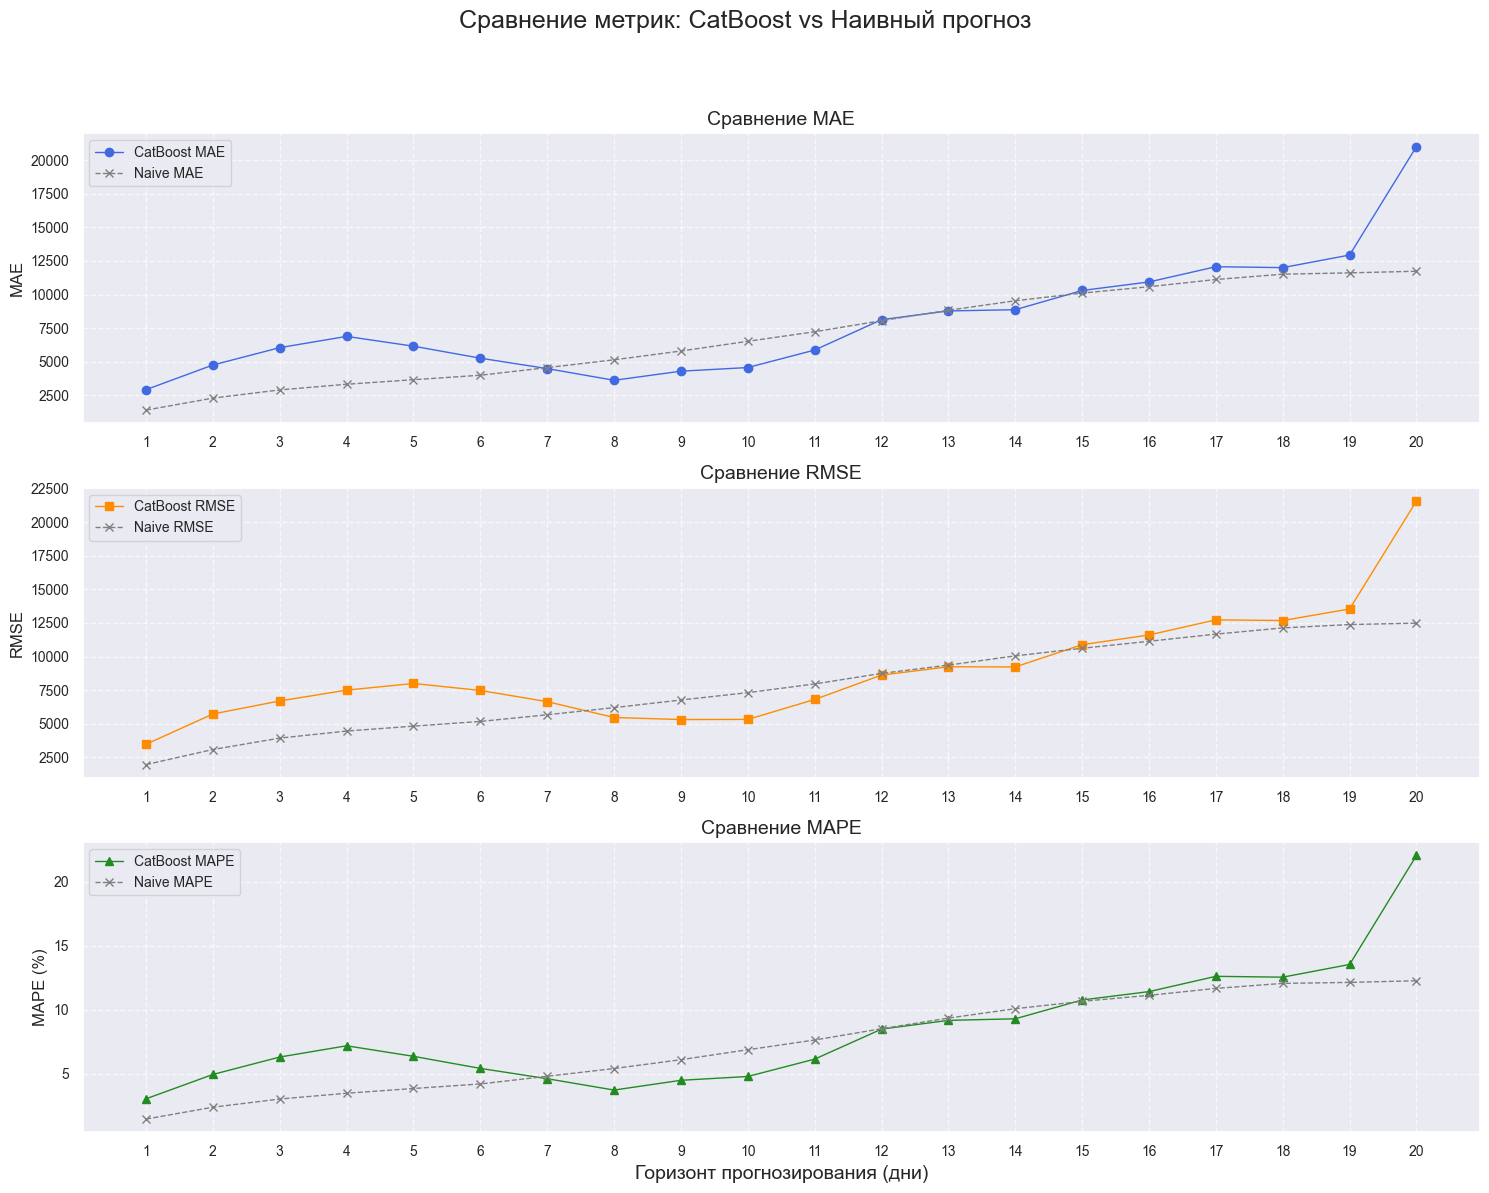

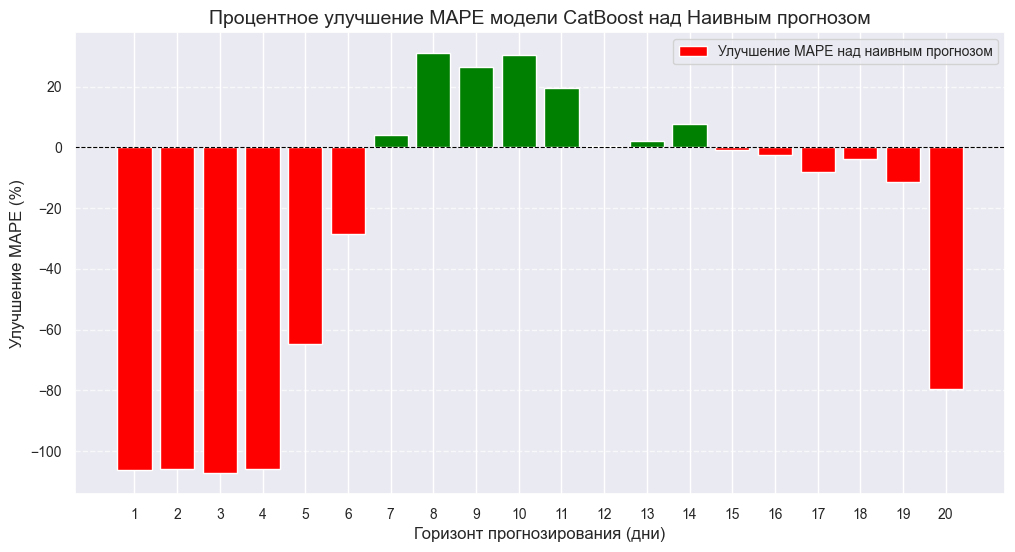


Эксперимент 2 завершен.


In [47]:
print("\nЭксперимент 2: Сравнение с наивным прогнозом (Baseline)")
print("=========================================================\n")

# --- 0. Необходимые импорты и предположения ---
# Предполагаем, что metrics_df (с результатами CatBoost) уже существует из предыдущей ячейки
# Также предполагаем, что TARGET, data, HORIZONS_DAYS_ALL, HORIZONS_HOURS_ALL,
# EXPERIMENT_TEST_SIZE_HOURS, mean_absolute_percentage_error определены.

if 'metrics_df' not in locals() or metrics_df.empty:
    print("Ошибка: DataFrame 'metrics_df' с результатами CatBoost не найден. "
          "Пожалуйста, запустите предыдущую ячейку 'Эксперимент 1'.")
    # Можно либо остановить выполнение, либо создать пустой DataFrame для бейзлайна,
    # но тогда сравнение будет неполным. Для ВКР лучше остановить.
    raise ValueError("metrics_df не определен. Запустите предыдущий эксперимент.")

baseline_metrics_list = []

# --- 1. Расчет метрик для наивного прогноза (Persistence Model) ---
for h_days, h_hours in zip(HORIZONS_DAYS_ALL, HORIZONS_HOURS_ALL):
    print(f"--- Baseline: Обработка горизонта: {h_days} дней ({h_hours} часов) ---")

    # 1.1 Подготовка данных аналогично "Эксперименту 1", чтобы тестовые выборки совпадали
    data_for_horizon_baseline = data.copy()
    # Целевая переменная - фактическое значение через h_hours
    data_for_horizon_baseline['y_true_future'] = data_for_horizon_baseline[TARGET].shift(-h_hours)
    
    # Наивный прогноз: значение в момент t предсказывает значение в момент t+h_hours
    # Однако, для корректного сравнения, мы должны взять значение TARGET в момент t
    # и использовать его как прогноз для y_true_future (которое соответствует моменту t+h_hours)
    # То есть, X на котором обучался CatBoost, содержит TARGET в момент t.
    # Наивный прогноз для y(t+h) будет y(t)
    data_for_horizon_baseline['y_pred_naive'] = data_for_horizon_baseline[TARGET] # Это y(t)

    # Важно! Чтобы X и y для наивного прогноза соответствовали тем же временным точкам,
    # что и в Эксперименте 1, нужно учесть сдвиги лагов, которые там были.
    # Самый простой способ обеспечить идентичность тестовых y_true:
    # повторить создание X и y из Эксперимента 1, но потом использовать TARGET как y_pred_naive.
    
    # Повторяем шаги создания признаков, чтобы получить те же строки после dropna
    # Лаги здесь нужны только для того, чтобы после dropna остались те же строки,
    # что и для теста CatBoost. Сами лаги в наивном прогнозе не используются.
    if 'LAGS_CONFIG' not in locals(): # Если вдруг LAGS_CONFIG не определен
        LAGS_CONFIG = [1, 24, 168] # Минимальный набор для примера

    for lag in LAGS_CONFIG:
        data_for_horizon_baseline[f'{TARGET}_lag_{lag}h_dummy'] = data_for_horizon_baseline[TARGET].shift(lag)
    # Временные признаки (тоже для консистентности dropna)
    data_for_horizon_baseline['hour_dummy'] = data_for_horizon_baseline.index.hour
    # и т.д. если другие признаки влияли на dropna в эксперименте 1

    # Удаляем NaN. Ключевой момент - y_true_future и y_pred_naive должны иметь значения
    # для тех же индексов, что и в y_test_h_exp из Эксперимента 1.
    data_for_horizon_baseline.dropna(subset=['y_true_future', 'y_pred_naive'] + \
                                            [f'{TARGET}_lag_{lag}h_dummy' for lag in LAGS_CONFIG] + \
                                            ['hour_dummy'], # и другие dummy признаки
                                     inplace=True)

    if data_for_horizon_baseline.empty:
        print(f"Baseline Горизонт {h_days} дней: нет данных после подготовки. Пропуск.")
        baseline_metrics_list.append({'Горизонт (дни)': h_days, 'MAE': np.nan, 'RMSE': np.nan, 'MAPE': np.nan})
        continue

    # 1.2 Выделение тестовой выборки для y_true и y_pred_naive
    # Размер тестовой выборки должен быть тем же, что и в Эксперименте 1
    if EXPERIMENT_TEST_SIZE_HOURS >= len(data_for_horizon_baseline):
        print(f"Baseline Горизонт {h_days} дней: EXPERIMENT_TEST_SIZE_HOURS ({EXPERIMENT_TEST_SIZE_HOURS}) "
              f">= длина обработанных данных ({len(data_for_horizon_baseline)}). Пропуск.")
        baseline_metrics_list.append({'Горизонт (дни)': h_days, 'MAE': np.nan, 'RMSE': np.nan, 'MAPE': np.nan})
        continue
        
    y_true_test_baseline = data_for_horizon_baseline['y_true_future'].iloc[-EXPERIMENT_TEST_SIZE_HOURS:]
    y_pred_test_naive = data_for_horizon_baseline['y_pred_naive'].iloc[-EXPERIMENT_TEST_SIZE_HOURS:] # Это прогноз y(t) для y(t+h)

    if y_true_test_baseline.empty:
        print(f"Baseline Горизонт {h_days} дней: тестовая выборка y_true пуста. Пропуск.")
        baseline_metrics_list.append({'Горизонт (дни)': h_days, 'MAE': np.nan, 'RMSE': np.nan, 'MAPE': np.nan})
        continue

    # 1.3 Расчет метрик для наивного прогноза
    mae_naive = mean_absolute_error(y_true_test_baseline, y_pred_test_naive)
    rmse_naive = np.sqrt(mean_squared_error(y_true_test_baseline, y_pred_test_naive))
    mape_naive = mean_absolute_percentage_error(y_true_test_baseline, y_pred_test_naive)

    baseline_metrics_list.append({
        'Горизонт (дни)': h_days,
        'MAE_baseline': mae_naive,
        'RMSE_baseline': rmse_naive,
        'MAPE_baseline': mape_naive
    })
    print(f"Baseline Горизонт {h_days} дней: MAE={mae_naive:.2f}, RMSE={rmse_naive:.2f}, MAPE={mape_naive:.2f}%")

baseline_metrics_df = pd.DataFrame(baseline_metrics_list)

# --- 2. Объединение и сравнение результатов ---
if not baseline_metrics_df.empty:
    comparison_df = pd.merge(metrics_df, baseline_metrics_df, on='Горизонт (дни)', how='left')
    
    # Расчет улучшения (например, для MAE). < 0 означает ухудшение.
    # (MAE_baseline - MAE_model) / MAE_baseline * 100%
    comparison_df['MAE_Improvement (%)'] = \
        (comparison_df['MAE_baseline'] - comparison_df['MAE']) / comparison_df['MAE_baseline'] * 100
    comparison_df['MAPE_Improvement (%)'] = \
        (comparison_df['MAPE_baseline'] - comparison_df['MAPE']) / comparison_df['MAPE_baseline'] * 100


    print("\nСравнительная таблица метрик: CatBoost vs Baseline")
    styled_comparison_df = comparison_df.style.set_caption("Таблица 2. Сравнение метрик CatBoost и Наивного прогноза") \
        .format({
            "MAE": "{:.2f}", "RMSE": "{:.2f}", "MAPE": "{:.2f}%",
            "MAE_baseline": "{:.2f}", "RMSE_baseline": "{:.2f}", "MAPE_baseline": "{:.2f}%",
            "MAE_Improvement (%)": "{:.1f}%", "MAPE_Improvement (%)": "{:.1f}%"
        }) \
        .set_table_styles([
            {'selector': 'th', 'props': [('background-color', '#E8E8E8'), ('color', 'black'), ('font-weight', 'bold'), ('text-align', 'center'), ('border', '1px solid #B0B0B0')]},
            {'selector': 'caption', 'props': [('caption-side', 'top'), ('font-size', '1.1em'), ('font-weight', 'bold'), ('color', 'black'), ('margin-bottom', '10px')]},
            {'selector': 'td', 'props': [('background-color', 'white'), ('color', 'black'), ('text-align', 'center'), ('border', '1px solid #D0D0D0')]},
            {'selector': 'tr:hover td', 'props': [('background-color', '#f0f0f0')]}
        ]) \
        .set_properties(**{'border-collapse': 'collapse', 'border': '1px solid black', 'width': 'auto', 'margin': '0 auto', 'font-family': 'Arial, sans-serif'}) \
        .hide(axis="index") \
        .background_gradient(subset=['MAE_Improvement (%)', 'MAPE_Improvement (%)'], cmap='RdYlGn', vmin=-100, vmax=100) # Подсветка улучшения

    display(HTML(styled_comparison_df.to_html()))

    # --- 3. Визуализация сравнения метрик ---
    plt.figure(figsize=(15, 12))
    plt.suptitle('Сравнение метрик: CatBoost vs Наивный прогноз', fontsize=18, y=0.99)
    horizons_for_xticks_comp = comparison_df['Горизонт (дни)'].tolist()

    # MAE Comparison
    plt.subplot(3, 1, 1)
    plt.plot(comparison_df['Горизонт (дни)'], comparison_df['MAE'], marker='o', linestyle='-', color='royalblue', label='CatBoost MAE')
    plt.plot(comparison_df['Горизонт (дни)'], comparison_df['MAE_baseline'], marker='x', linestyle='--', color='gray', label='Naive MAE')
    plt.ylabel('MAE', fontsize=12)
    plt.xticks(horizons_for_xticks_comp)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=10)
    plt.title('Сравнение MAE', fontsize=14)

    # RMSE Comparison
    plt.subplot(3, 1, 2)
    plt.plot(comparison_df['Горизонт (дни)'], comparison_df['RMSE'], marker='s', linestyle='-', color='darkorange', label='CatBoost RMSE')
    plt.plot(comparison_df['Горизонт (дни)'], comparison_df['RMSE_baseline'], marker='x', linestyle='--', color='gray', label='Naive RMSE')
    plt.ylabel('RMSE', fontsize=12)
    plt.xticks(horizons_for_xticks_comp)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=10)
    plt.title('Сравнение RMSE', fontsize=14)

    # MAPE Comparison
    plt.subplot(3, 1, 3)
    plt.plot(comparison_df['Горизонт (дни)'], comparison_df['MAPE'], marker='^', linestyle='-', color='forestgreen', label='CatBoost MAPE')
    plt.plot(comparison_df['Горизонт (дни)'], comparison_df['MAPE_baseline'], marker='x', linestyle='--', color='gray', label='Naive MAPE')
    plt.ylabel('MAPE (%)', fontsize=12)
    plt.xlabel('Горизонт прогнозирования (дни)', fontsize=14)
    plt.xticks(horizons_for_xticks_comp)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=10)
    plt.title('Сравнение MAPE', fontsize=14)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    # --- 4. Визуализация улучшения ---
    plt.figure(figsize=(12, 6))
    plt.bar(comparison_df['Горизонт (дни)'], comparison_df['MAPE_Improvement (%)'], 
            color=['green' if x > 0 else 'red' for x in comparison_df['MAPE_Improvement (%)']], 
            label='Улучшение MAPE над наивным прогнозом')
    plt.axhline(0, color='black', linewidth=0.8, linestyle='--') # Линия нуля
    plt.ylabel('Улучшение MAPE (%)', fontsize=12)
    plt.xlabel('Горизонт прогнозирования (дни)', fontsize=12)
    plt.xticks(horizons_for_xticks_comp)
    plt.title('Процентное улучшение MAPE модели CatBoost над Наивным прогнозом', fontsize=14)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend()
    plt.show()

else:
    print("Не удалось рассчитать метрики для baseline, сравнение невозможно.")

print("\n=========================================================")
print("Эксперимент 2 завершен.")

## Кросс валидация


Эксперимент 3: Оценка на различных горизонтах с использованием Кросс-Валидации Временных Рядов

Параметры Кросс-Валидации: Количество фолдов = 5, Размер валидации на фолд = 960 часов (40 дней)


--- КВ для Горизонта: 1 дней (24 часов) ---
  Фолд 1/5...
  Фолд 2/5...
  Фолд 3/5...
  Фолд 4/5...
  Фолд 5/5...
  Горизонт 1 дней (CV): CatBoost MAE=7474.51, MAPE=7.91%
  Горизонт 1 дней (CV): Baseline MAE=1750.00, MAPE=1.93%
  Горизонт 1 дней (CV): MAPE Improvement=-309.7%

--- КВ для Горизонта: 2 дней (48 часов) ---
  Фолд 1/5...
  Фолд 2/5...
  Фолд 3/5...
  Фолд 4/5...
  Фолд 5/5...
  Горизонт 2 дней (CV): CatBoost MAE=9193.05, MAPE=9.69%
  Горизонт 2 дней (CV): Baseline MAE=2436.86, MAPE=2.69%
  Горизонт 2 дней (CV): MAPE Improvement=-259.8%

--- КВ для Горизонта: 3 дней (72 часов) ---
  Фолд 1/5...
  Фолд 2/5...
  Фолд 3/5...
  Фолд 4/5...
  Фолд 5/5...
  Горизонт 3 дней (CV): CatBoost MAE=10035.81, MAPE=10.64%
  Горизонт 3 дней (CV): Baseline MAE=3000.61, MAPE=3.32%
  Горизонт 3 дней 

Горизонт (дни),MAE,RMSE,MAPE,MAE_baseline,RMSE_baseline,MAPE_baseline,MAE_Improvement (%),MAPE_Improvement (%)
1,7474.51,8925.79,7.91%,1750.00,2379.52,1.93%,-327.1%,-309.7%
2,9193.05,10848.87,9.69%,2436.86,3185.49,2.69%,-277.3%,-259.8%
3,10035.81,11666.44,10.64%,3000.61,3922.54,3.32%,-234.5%,-220.3%
4,10013.91,11909.76,10.59%,3380.65,4424.16,3.75%,-196.2%,-182.1%
5,11744.54,13678.10,12.43%,3760.08,4901.95,4.18%,-212.3%,-197.7%
6,11997.47,13939.84,12.71%,3998.47,5267.06,4.43%,-200.1%,-186.9%
7,12836.67,14942.83,13.68%,4249.39,5572.70,4.69%,-202.1%,-191.9%
8,11654.37,13590.64,12.43%,4548.07,5879.77,4.99%,-156.2%,-148.9%
9,11888.75,13803.11,12.66%,4825.84,6137.97,5.30%,-146.4%,-138.9%
10,14951.09,16776.55,15.72%,5079.25,6431.34,5.58%,-194.4%,-181.6%


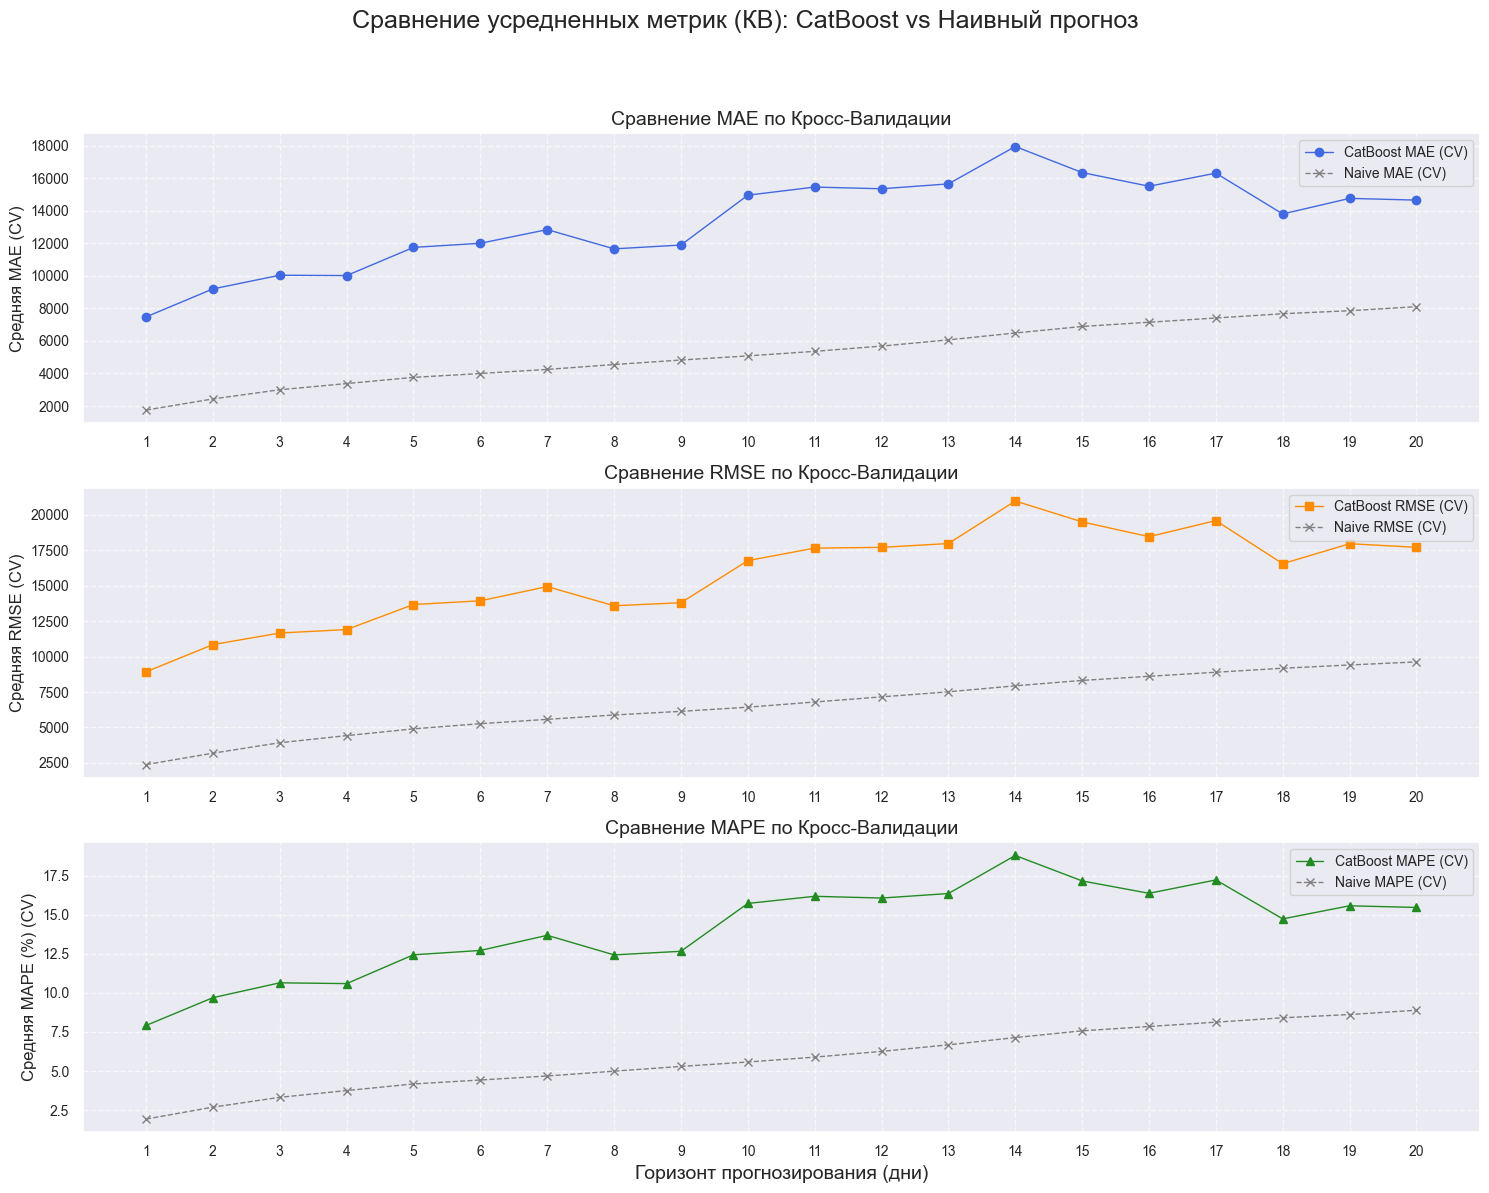

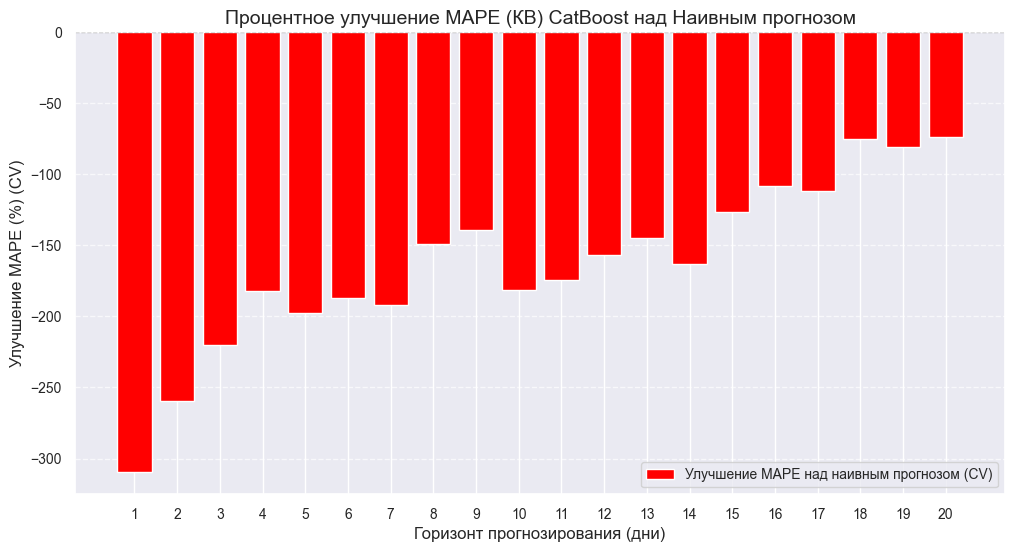


Эксперимент 3 завершен.


In [49]:
print("\nЭксперимент 3: Оценка на различных горизонтах с использованием Кросс-Валидации Временных Рядов")
print("==============================================================================================\n")

# --- 0. Необходимые импорты и функции ---
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from IPython.display import HTML, display
from sklearn.model_selection import TimeSeriesSplit # Можно использовать, но сделаем вручную для гибкости

# Предполагаем, что TARGET, data, catboost_model_params, LAGS_CONFIG,
# HORIZONS_DAYS_ALL, HORIZONS_HOURS_ALL, mean_absolute_percentage_error,
# code_mean, features_for_mean_encoding_exp определены.

# --- 1. Параметры для Кросс-Валидации ---
N_SPLITS = 5  # Количество фолдов (сплитов)
# Размер валидационного набора для каждого фолда.
# Должен быть достаточно большим. Например, столько же, сколько было в предыдущем тесте.
# Или, если данных много, можно взять больше, например, 30 дней.
# Убедимся, что он не меньше самого длинного горизонта.
MIN_VALIDATION_DAYS = max(HORIZONS_DAYS_ALL) # Как минимум, длина самого длинного горизонта
VALIDATION_SIZE_HOURS = MIN_VALIDATION_DAYS * 24 * 2 # Возьмем в 2 раза больше, чем самый длинный горизонт, для стабильности

print(f"Параметры Кросс-Валидации: Количество фолдов = {N_SPLITS}, Размер валидации на фолд = {VALIDATION_SIZE_HOURS} часов ({VALIDATION_SIZE_HOURS/24:.0f} дней)\n")

# Список для хранения усредненных метрик по всем фолдам для каждого горизонта
cv_metrics_summary_list = []

# --- 2. Основной цикл по ГОРИЗОНТАМ ---
for h_days, h_hours in zip(HORIZONS_DAYS_ALL, HORIZONS_HOURS_ALL):
    print(f"\n--- КВ для Горизонта: {h_days} дней ({h_hours} часов) ---")

    # Списки для хранения метрик по фолдам для ТЕКУЩЕГО горизонта
    fold_mae_catboost = []
    fold_rmse_catboost = []
    fold_mape_catboost = []
    fold_mae_baseline = []
    fold_rmse_baseline = []
    fold_mape_baseline = []

    # --- 3. Подготовка данных для текущего горизонта (один раз перед циклами по фолдам) ---
    # Эта часть аналогична Эксперименту 1, но на ВСЕХ данных (пока без разделения на train/test)
    data_h_cv = data.copy()
    data_h_cv['y_model_future'] = data_h_cv[TARGET].shift(-h_hours) # Целевая для CatBoost
    data_h_cv['y_pred_naive_target'] = data_h_cv[TARGET]          # То, что будет предсказанием для наивной модели

    for lag in LAGS_CONFIG:
        data_h_cv[f'{TARGET}_lag_{lag}h'] = data_h_cv[TARGET].shift(lag)
    
    # Временные и новостные признаки
    data_h_cv['hour'] = data_h_cv.index.hour
    data_h_cv['dayofweek'] = data_h_cv.index.dayofweek
    data_h_cv['dayofmonth'] = data_h_cv.index.day
    data_h_cv['month'] = data_h_cv.index.month
    news_cols = ['avg_overall_sentiment', 'avg_btc_specific_sentiment', 'sum_news_count', 'Change %']
    for nc in news_cols:
        if nc not in data_h_cv.columns and nc in data.columns: data_h_cv[nc] = data[nc]
        elif nc not in data_h_cv.columns: data_h_cv[nc] = 0
    
    # Колонки для удаления при формировании X
    cols_to_drop_from_X_cv = [TARGET, 'y_model_future', 'y_pred_naive_target', 'Open', 'High', 'Low']
    cols_present_in_df_cv = [col for col in cols_to_drop_from_X_cv if col in data_h_cv.columns]

    # Удаляем NaN ПОСЛЕ всех сдвигов и создания признаков
    # Важно: subset должен включать все колонки, которые могут привести к NaN (лаги и y_model_future)
    cols_for_dropna = ['y_model_future'] + [f'{TARGET}_lag_{lag}h' for lag in LAGS_CONFIG]
    data_h_cv.dropna(subset=cols_for_dropna, inplace=True)

    if len(data_h_cv) < N_SPLITS * VALIDATION_SIZE_HOURS + VALIDATION_SIZE_HOURS: # Примерная проверка на достаточность данных
        print(f"Недостаточно данных для {N_SPLITS} фолдов с валидацией {VALIDATION_SIZE_HOURS}ч для горизонта {h_days}дн. Пропуск горизонта.")
        cv_metrics_summary_list.append({
            'Горизонт (дни)': h_days, 'MAE': np.nan, 'RMSE': np.nan, 'MAPE': np.nan,
            'MAE_baseline': np.nan, 'RMSE_baseline': np.nan, 'MAPE_baseline': np.nan,
            'MAE_Improvement (%)': np.nan, 'MAPE_Improvement (%)': np.nan
        })
        continue

    # --- 4. Цикл по ФОЛДАМ Кросс-Валидации (Walk-Forward) ---
    # Определяем общий размер данных, доступных для КВ после подготовки
    n_samples_total_cv = len(data_h_cv)
    
    # Начальный размер обучающей выборки. Она будет расти.
    # Оставляем место для N_SPLITS валидационных наборов
    initial_train_size = n_samples_total_cv - (N_SPLITS * VALIDATION_SIZE_HOURS)

    if initial_train_size <= max(LAGS_CONFIG) + 10: # Убедимся, что начальный трейн достаточно большой
        print(f"Начальный размер обучающей выборки ({initial_train_size}) слишком мал для горизонта {h_days}дн. Пропуск.")
        # ... (добавить np.nan в cv_metrics_summary_list и continue) ...
        cv_metrics_summary_list.append({
            'Горизонт (дни)': h_days, 'MAE': np.nan, 'RMSE': np.nan, 'MAPE': np.nan,
            'MAE_baseline': np.nan, 'RMSE_baseline': np.nan, 'MAPE_baseline': np.nan,
            'MAE_Improvement (%)': np.nan, 'MAPE_Improvement (%)': np.nan
        })
        continue

    for i_split in range(N_SPLITS):
        print(f"  Фолд {i_split + 1}/{N_SPLITS}...")

        # Определяем границы для текущего фолда (расширяющееся окно)
        train_end_idx = initial_train_size + i_split * VALIDATION_SIZE_HOURS
        validation_end_idx = train_end_idx + VALIDATION_SIZE_HOURS

        if validation_end_idx > n_samples_total_cv : # Если вышли за пределы данных
             print(f"    Фолд {i_split + 1}: выход за пределы данных. Пропуск фолда.")
             continue


        current_train_df = data_h_cv.iloc[:train_end_idx]
        current_validation_df = data_h_cv.iloc[train_end_idx:validation_end_idx]

        if current_train_df.empty or current_validation_df.empty:
            print(f"    Фолд {i_split + 1}: обучающая или валидационная выборка пусты. Пропуск фолда.")
            continue
        
        # --- 4.1 Подготовка X, y для текущего фолда ---
        y_train_fold = current_train_df['y_model_future']
        X_train_fold_raw = current_train_df.drop(columns=cols_present_in_df_cv)
        
        y_validation_fold_true = current_validation_df['y_model_future'] # Фактические значения для CatBoost и Baseline
        X_validation_fold_raw = current_validation_df.drop(columns=cols_present_in_df_cv)
        
        y_validation_fold_naive_pred = current_validation_df['y_pred_naive_target'] # Наивный прогноз для валидации

        # --- 4.2 Кодирование категориальных признаков (обучаем на current_train_df, применяем к обоим) ---
        X_train_fold_encoded = X_train_fold_raw.copy()
        X_validation_fold_encoded = X_validation_fold_raw.copy()
        
        train_df_for_encoding_fold = X_train_fold_raw.copy()
        train_df_for_encoding_fold['__target_for_encoding__'] = y_train_fold
        global_mean_target_train_fold = y_train_fold.mean()

        for feat_cat in features_for_mean_encoding_exp: # features_for_mean_encoding_exp должно быть определено
            if feat_cat in X_train_fold_encoded.columns:
                means_fold = code_mean(train_df_for_encoding_fold, feat_cat, '__target_for_encoding__')
                X_train_fold_encoded[f'{feat_cat}_avg_target_cv'] = X_train_fold_encoded[feat_cat].map(means_fold).fillna(global_mean_target_train_fold)
                X_validation_fold_encoded[f'{feat_cat}_avg_target_cv'] = X_validation_fold_encoded[feat_cat].map(means_fold).fillna(global_mean_target_train_fold)
                X_train_fold_encoded.drop(feat_cat, axis=1, inplace=True)
                X_validation_fold_encoded.drop(feat_cat, axis=1, inplace=True)

        # Выравнивание колонок X_validation_fold_encoded по X_train_fold_encoded
        train_cols_f = set(X_train_fold_encoded.columns)
        valid_cols_f = set(X_validation_fold_encoded.columns)
        if train_cols_f != valid_cols_f:
            # print(f"    Фолд {i_split + 1}: Несовпадение колонок! Выравнивание...")
            all_cols_f = list(train_cols_f)
            X_validation_fold_aligned = pd.DataFrame(columns=all_cols_f, index=X_validation_fold_encoded.index)
            for col in all_cols_f:
                if col in X_validation_fold_encoded.columns:
                    X_validation_fold_aligned[col] = X_validation_fold_encoded[col]
                else:
                    X_validation_fold_aligned[col] = global_mean_target_train_fold
            X_validation_fold_encoded = X_validation_fold_aligned[all_cols_f]
            if X_validation_fold_encoded.isnull().any().any(): # Проверка на NaN после выравнивания
                 X_validation_fold_encoded.fillna(global_mean_target_train_fold, inplace=True) # Дополнительное заполнение NaN


        # --- 4.3 Обучение и предсказание CatBoost ---
        model_cv = CatBoostRegressor(**catboost_model_params)
        try:
            model_cv.fit(X_train_fold_encoded, y_train_fold, verbose=0)
            y_validation_pred_catboost = model_cv.predict(X_validation_fold_encoded)
            
            fold_mae_catboost.append(mean_absolute_error(y_validation_fold_true, y_validation_pred_catboost))
            fold_rmse_catboost.append(np.sqrt(mean_squared_error(y_validation_fold_true, y_validation_pred_catboost)))
            fold_mape_catboost.append(mean_absolute_percentage_error(y_validation_fold_true, y_validation_pred_catboost))
        except Exception as e:
            print(f"    Ошибка на фолде {i_split+1} для CatBoost: {e}. Метрики будут NaN.")
            fold_mae_catboost.append(np.nan)
            fold_rmse_catboost.append(np.nan)
            fold_mape_catboost.append(np.nan)


        # --- 4.4 Расчет метрик для Baseline на этом фолде ---
        fold_mae_baseline.append(mean_absolute_error(y_validation_fold_true, y_validation_fold_naive_pred))
        fold_rmse_baseline.append(np.sqrt(mean_squared_error(y_validation_fold_true, y_validation_fold_naive_pred)))
        fold_mape_baseline.append(mean_absolute_percentage_error(y_validation_fold_true, y_validation_fold_naive_pred))
        
    # --- 5. Усреднение метрик по всем фолдам для текущего горизонта ---
    avg_mae_cb = np.nanmean(fold_mae_catboost)
    avg_rmse_cb = np.nanmean(fold_rmse_catboost)
    avg_mape_cb = np.nanmean(fold_mape_catboost)
    avg_mae_bl = np.nanmean(fold_mae_baseline)
    avg_rmse_bl = np.nanmean(fold_rmse_baseline)
    avg_mape_bl = np.nanmean(fold_mape_baseline)

    mae_improvement_cv = (avg_mae_bl - avg_mae_cb) / avg_mae_bl * 100 if avg_mae_bl != 0 and not np.isnan(avg_mae_bl) else np.nan
    mape_improvement_cv = (avg_mape_bl - avg_mape_cb) / avg_mape_bl * 100 if avg_mape_bl != 0 and not np.isnan(avg_mape_bl) else np.nan
    
    print(f"  Горизонт {h_days} дней (CV): CatBoost MAE={avg_mae_cb:.2f}, MAPE={avg_mape_cb:.2f}%")
    print(f"  Горизонт {h_days} дней (CV): Baseline MAE={avg_mae_bl:.2f}, MAPE={avg_mape_bl:.2f}%")
    print(f"  Горизонт {h_days} дней (CV): MAPE Improvement={mape_improvement_cv:.1f}%")


    cv_metrics_summary_list.append({
        'Горизонт (дни)': h_days,
        'MAE': avg_mae_cb, 'RMSE': avg_rmse_cb, 'MAPE': avg_mape_cb,
        'MAE_baseline': avg_mae_bl, 'RMSE_baseline': avg_rmse_bl, 'MAPE_baseline': avg_mape_bl,
        'MAE_Improvement (%)': mae_improvement_cv, 'MAPE_Improvement (%)': mape_improvement_cv
    })

# --- 6. Вывод итоговой таблицы и графиков по результатам КВ ---
cv_summary_df = pd.DataFrame(cv_metrics_summary_list)
print("\nСводная таблица метрик по результатам Кросс-Валидации:")

styled_cv_summary_df = cv_summary_df.style.set_caption("Таблица 3. Усредненные метрики (Кросс-Валидация) CatBoost vs Наивный прогноз") \
    .format({
        "MAE": "{:.2f}", "RMSE": "{:.2f}", "MAPE": "{:.2f}%",
        "MAE_baseline": "{:.2f}", "RMSE_baseline": "{:.2f}", "MAPE_baseline": "{:.2f}%",
        "MAE_Improvement (%)": "{:.1f}%", "MAPE_Improvement (%)": "{:.1f}%"
    }) \
    .set_table_styles([
        {'selector': 'th', 'props': [('background-color', '#E8E8E8'), ('color', 'black'), ('font-weight', 'bold'), ('text-align', 'center'), ('border', '1px solid #B0B0B0')]},
        {'selector': 'caption', 'props': [('caption-side', 'top'), ('font-size', '1.1em'), ('font-weight', 'bold'), ('color', 'black'), ('margin-bottom', '10px')]},
        {'selector': 'td', 'props': [('background-color', 'white'), ('color', 'black'), ('text-align', 'center'), ('border', '1px solid #D0D0D0')]},
        {'selector': 'tr:hover td', 'props': [('background-color', '#f0f0f0')]}
    ]) \
    .set_properties(**{'border-collapse': 'collapse', 'border': '1px solid black', 'width': 'auto', 'margin': '0 auto', 'font-family': 'Arial, sans-serif'}) \
    .hide(axis="index") \
    .background_gradient(subset=['MAE_Improvement (%)', 'MAPE_Improvement (%)'], cmap='RdYlGn', vmin=-100, vmax=100)

display(HTML(styled_cv_summary_df.to_html()))

# Графики (аналогично Эксперименту 2, но с данными из cv_summary_df)
if not cv_summary_df.empty:
    plt.figure(figsize=(15, 12))
    plt.suptitle('Сравнение усредненных метрик (КВ): CatBoost vs Наивный прогноз', fontsize=18, y=0.99)
    horizons_for_xticks_cv = cv_summary_df['Горизонт (дни)'].dropna().tolist() # Убираем NaN если были пропуски

    # MAE
    plt.subplot(3, 1, 1)
    plt.plot(cv_summary_df['Горизонт (дни)'], cv_summary_df['MAE'], marker='o', linestyle='-', color='royalblue', label='CatBoost MAE (CV)')
    plt.plot(cv_summary_df['Горизонт (дни)'], cv_summary_df['MAE_baseline'], marker='x', linestyle='--', color='gray', label='Naive MAE (CV)')
    plt.ylabel('Средняя MAE (CV)', fontsize=12)
    if horizons_for_xticks_cv: plt.xticks(horizons_for_xticks_cv)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=10)
    plt.title('Сравнение MAE по Кросс-Валидации', fontsize=14)

    # RMSE
    plt.subplot(3, 1, 2)
    plt.plot(cv_summary_df['Горизонт (дни)'], cv_summary_df['RMSE'], marker='s', linestyle='-', color='darkorange', label='CatBoost RMSE (CV)')
    plt.plot(cv_summary_df['Горизонт (дни)'], cv_summary_df['RMSE_baseline'], marker='x', linestyle='--', color='gray', label='Naive RMSE (CV)')
    plt.ylabel('Средняя RMSE (CV)', fontsize=12)
    if horizons_for_xticks_cv: plt.xticks(horizons_for_xticks_cv)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=10)
    plt.title('Сравнение RMSE по Кросс-Валидации', fontsize=14)

    # MAPE
    plt.subplot(3, 1, 3)
    plt.plot(cv_summary_df['Горизонт (дни)'], cv_summary_df['MAPE'], marker='^', linestyle='-', color='forestgreen', label='CatBoost MAPE (CV)')
    plt.plot(cv_summary_df['Горизонт (дни)'], cv_summary_df['MAPE_baseline'], marker='x', linestyle='--', color='gray', label='Naive MAPE (CV)')
    plt.ylabel('Средняя MAPE (%) (CV)', fontsize=12)
    plt.xlabel('Горизонт прогнозирования (дни)', fontsize=14)
    if horizons_for_xticks_cv: plt.xticks(horizons_for_xticks_cv)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=10)
    plt.title('Сравнение MAPE по Кросс-Валидации', fontsize=14)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    # График улучшения MAPE
    plt.figure(figsize=(12, 6))
    # Фильтруем NaN перед построением графика улучшения, чтобы избежать ошибок
    plot_data_improvement = cv_summary_df.dropna(subset=['Горизонт (дни)', 'MAPE_Improvement (%)'])
    bar_colors = ['green' if x > 0 else 'red' for x in plot_data_improvement['MAPE_Improvement (%)']]
    
    plt.bar(plot_data_improvement['Горизонт (дни)'], plot_data_improvement['MAPE_Improvement (%)'], 
            color=bar_colors,
            label='Улучшение MAPE над наивным прогнозом (CV)')
    plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
    plt.ylabel('Улучшение MAPE (%) (CV)', fontsize=12)
    plt.xlabel('Горизонт прогнозирования (дни)', fontsize=12)
    if not plot_data_improvement.empty: plt.xticks(plot_data_improvement['Горизонт (дни)'].tolist())
    plt.title('Процентное улучшение MAPE (КВ) CatBoost над Наивным прогнозом', fontsize=14)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend()
    plt.show()
else:
    print("Не удалось рассчитать сводные метрики по КВ, графики не будут построены.")


print("\n==============================================================================================")
print("Эксперимент 3 завершен.")

## Бэктест 


Эксперимент 4: Бэктест с ежечасным переобучением для заданного горизонта

Параметры Бэктеста:
  Целевой горизонт прогнозирования: 7 дней (168 часов)
  Длительность интервала бэктестинга: 7 дней (168 часов)
  Минимальный начальный размер данных ДО dropna: 30 дней (720 часов)
  (Это означает, что первая обучающая выборка будет меньше из-за сдвигов и лагов)

Подготовка данных: Исходный размер data = 38153, после создания признаков и dropna = 37816

Бэктест шаг 1/168 (Прогноз для 2021-02-07 01:00:00)

Бэктест шаг 2/168 (Прогноз для 2021-02-07 02:00:00)

Бэктест шаг 3/168 (Прогноз для 2021-02-07 03:00:00)

Бэктест шаг 4/168 (Прогноз для 2021-02-07 04:00:00)

Бэктест шаг 5/168 (Прогноз для 2021-02-07 05:00:00)

Бэктест шаг 6/168 (Прогноз для 2021-02-07 06:00:00)

Бэктест шаг 7/168 (Прогноз для 2021-02-07 07:00:00)

Бэктест шаг 8/168 (Прогноз для 2021-02-07 08:00:00)

Бэктест шаг 9/168 (Прогноз для 2021-02-07 09:00:00)

Бэктест шаг 10/168 (Прогноз для 2021-02-07 10:00:00)

Бэктест шаг 11/168

Горизонт (дни),MAE,RMSE,MAPE,MAE_baseline,RMSE_baseline,MAPE_baseline,MAE_Improvement (%),MAPE_Improvement (%)
7,1259.52,2164.32,2.45%,6357.04,6925.32,12.38%,80.2%,80.2%


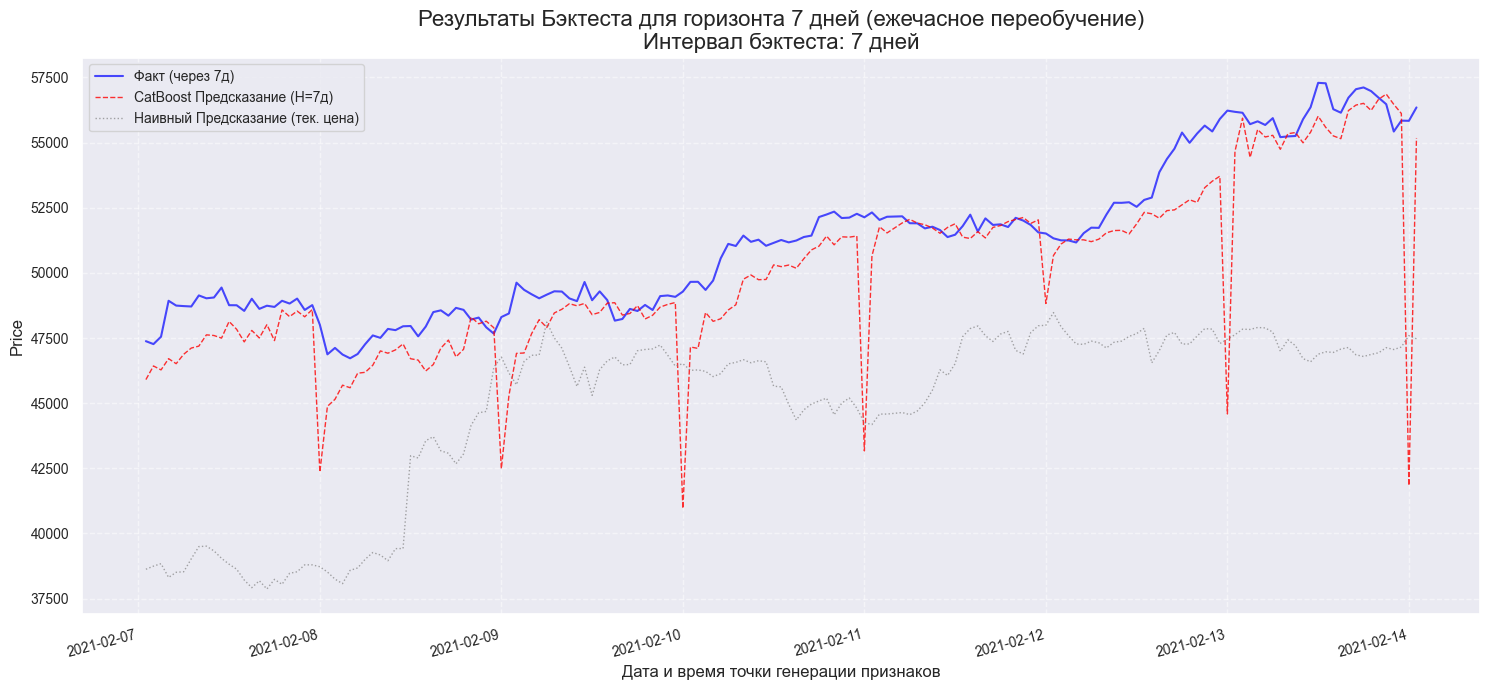


Эксперимент 4 завершен.


In [55]:
print("\nЭксперимент 4: Бэктест с ежечасным переобучением для заданного горизонта")
print("===========================================================================\n")

# --- 0. Необходимые импорты ---
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from IPython.display import HTML, display
import time # Для отслеживания времени выполнения

# --- ПРЕДПОЛОЖЕНИЯ: Эти переменные должны быть определены в вашем ноутбуке РАНЕЕ ---
# Убедитесь, что они действительно существуют и корректны перед запуском этой ячейки!
if 'data' not in locals() or not isinstance(data, pd.DataFrame) or data.empty:
    raise NameError("'data' DataFrame не определен или пуст.")
if 'TARGET' not in locals() or not isinstance(TARGET, str):
    raise NameError("'TARGET' не определен или не является строкой.")
if 'catboost_model_params' not in locals() or not isinstance(catboost_model_params, dict):
    raise NameError("'catboost_model_params' не определены или не являются словарем.")
if 'LAGS_CONFIG' not in locals() or not isinstance(LAGS_CONFIG, list) or not LAGS_CONFIG:
    # Если LAGS_CONFIG не определен, установим дефолтный, но лучше определить его явно
    print("ПРЕДУПРЕЖДЕНИЕ: 'LAGS_CONFIG' не определен. Использую дефолтный набор: [1, 24, 168]")
    LAGS_CONFIG = [1, 24, 168]
if 'mean_absolute_percentage_error' not in locals() or not callable(mean_absolute_percentage_error):
    # Определим MAPE, если ее нет
    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        non_zero_mask = y_true != 0
        if np.sum(non_zero_mask) == 0: return np.nan if len(y_true) > 0 else 0.0
        return np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])) * 100
    print("Определена функция mean_absolute_percentage_error.")
if 'code_mean' not in locals() or not callable(code_mean):
    # Определим code_mean, если ее нет
    def code_mean(data_subset, cat_feature, real_feature):
        return dict(data_subset.groupby(cat_feature)[real_feature].mean())
    print("Определена функция code_mean.")
if 'features_for_mean_encoding_exp' not in locals() or not isinstance(features_for_mean_encoding_exp, list):
    # Если features_for_mean_encoding_exp не определен, установим дефолтный
    print("ПРЕДУПРЕЖДЕНИЕ: 'features_for_mean_encoding_exp' не определен. Использую дефолтный: ['hour', 'dayofweek']")
    features_for_mean_encoding_exp = ['hour', 'dayofweek']
# ------------------------------------------------------------------------------------

# --- 1. Параметры для Бэктеста ---
TARGET_HORIZON_DAYS = 7  # !!! ЗАДАЙТЕ НУЖНЫЙ ГОРИЗОНТ В ДНЯХ !!!
TARGET_HORIZON_HOURS = TARGET_HORIZON_DAYS * 24

BACKTEST_INTERVAL_DAYS = 7 # !!! УМЕНЬШИЛ ДЛЯ ТЕСТА, ВЕРНИТЕ НУЖНОЕ ЗНАЧЕНИЕ (например, 7) !!!
BACKTEST_INTERVAL_HOURS = BACKTEST_INTERVAL_DAYS * 24

# Минимальный начальный размер обучающей выборки перед началом бэктеста
# Должен быть больше, чем max(LAGS_CONFIG) + TARGET_HORIZON_HOURS + запас на обучение
# Пример: если max_lag=169, horizon=168, запас=24*10=240. Итого ~577
# Устанавливаем в днях для удобства
MIN_INITIAL_TRAIN_DAYS = max(max(LAGS_CONFIG), TARGET_HORIZON_HOURS)//24 + 15 # (max_lag или horizon)/24 + 15 дней запаса
if MIN_INITIAL_TRAIN_DAYS < 30: MIN_INITIAL_TRAIN_DAYS = 30 # Но не меньше 30 дней
MIN_INITIAL_TRAIN_HOURS = MIN_INITIAL_TRAIN_DAYS * 24

print(f"Параметры Бэктеста:")
print(f"  Целевой горизонт прогнозирования: {TARGET_HORIZON_DAYS} дней ({TARGET_HORIZON_HOURS} часов)")
print(f"  Длительность интервала бэктестинга: {BACKTEST_INTERVAL_DAYS} дней ({BACKTEST_INTERVAL_HOURS} часов)")
print(f"  Минимальный начальный размер данных ДО dropna: {MIN_INITIAL_TRAIN_DAYS} дней ({MIN_INITIAL_TRAIN_HOURS} часов)")
print(f"  (Это означает, что первая обучающая выборка будет меньше из-за сдвигов и лагов)\n")

y_true_backtest_list = []
y_pred_catboost_backtest_list = []
y_pred_naive_backtest_list = []
timestamps_backtest_list = [] # Для графика

# --- 2. Подготовка общего датасета для бэктеста ---
data_backtest_full = data.copy()
data_backtest_full['y_model_future'] = data_backtest_full[TARGET].shift(-TARGET_HORIZON_HOURS)
data_backtest_full['y_pred_naive_source'] = data_backtest_full[TARGET]

for lag in LAGS_CONFIG:
    data_backtest_full[f'{TARGET}_lag_{lag}h'] = data_backtest_full[TARGET].shift(lag)

data_backtest_full['hour'] = data_backtest_full.index.hour
data_backtest_full['dayofweek'] = data_backtest_full.index.dayofweek
data_backtest_full['dayofmonth'] = data_backtest_full.index.day
data_backtest_full['month'] = data_backtest_full.index.month
news_cols = ['avg_overall_sentiment', 'avg_btc_specific_sentiment', 'sum_news_count', 'Change %']
for nc in news_cols:
    if nc not in data_backtest_full.columns and nc in data.columns: data_backtest_full[nc] = data[nc]
    elif nc not in data_backtest_full.columns: data_backtest_full[nc] = 0

cols_to_drop_from_X_backtest = [TARGET, 'y_model_future', 'y_pred_naive_source', 'Open', 'High', 'Low']
cols_present_in_df_backtest = [col for col in cols_to_drop_from_X_backtest if col in data_backtest_full.columns]

# Определяем колонки, NaN в которых приведут к удалению строки
# Это y_model_future (из-за сдвига на -TARGET_HORIZON_HOURS) и самый большой лаг
# Фактически, самый большой сдвиг вниз (потеря данных в начале) - это max(LAGS_CONFIG)
# Самый большой сдвиг вверх (потеря данных в конце) - это TARGET_HORIZON_HOURS
initial_data_len = len(data_backtest_full)
cols_for_dropna_backtest = ['y_model_future'] + [f'{TARGET}_lag_{max(LAGS_CONFIG)}h'] # Достаточно проверить y_model_future и самый большой лаг
data_backtest_full.dropna(subset=cols_for_dropna_backtest, inplace=True)
print(f"Подготовка данных: Исходный размер data = {initial_data_len}, после создания признаков и dropna = {len(data_backtest_full)}")


# Определяем точку, С КОТОРОЙ НАЧНЕТСЯ БЭКТЕСТ (т.е. первая точка, для которой делается прогноз)
# До этой точки все данные используются для САМОГО ПЕРВОГО обучения.
# Эта точка должна быть такой, чтобы `data_backtest_full.iloc[:first_prediction_point_idx]`
# было достаточно для обучения.
# `MIN_INITIAL_TRAIN_HOURS` теперь относится к размеру `data_backtest_full` ПОСЛЕ dropna.
first_prediction_point_idx = MIN_INITIAL_TRAIN_HOURS

if len(data_backtest_full) < first_prediction_point_idx + BACKTEST_INTERVAL_HOURS:
    print("Ошибка: Недостаточно данных в `data_backtest_full` для проведения бэктеста с заданными параметрами.")
    print(f"  Требуется как минимум {first_prediction_point_idx + BACKTEST_INTERVAL_HOURS} обработанных точек, доступно {len(data_backtest_full)}")
    raise ValueError("Недостаточно данных для бэктеста после начальной подготовки.")

# --- 3. Цикл Бэктестинга (симуляция почасовой работы) ---
total_backtest_steps = BACKTEST_INTERVAL_HOURS
start_time_backtest = time.time()

# MIN_SAMPLES_FOR_TRAIN - минимальное количество сэмплов в обучающей выборке для одного шага
MIN_SAMPLES_FOR_TRAIN = max(LAGS_CONFIG) + 50 # Запас в 50 точек сверх максимального лага

for i_step in range(total_backtest_steps):
    # Индекс точки в data_backtest_full, для которой мы сейчас генерируем признаки и ДЕЛАЕМ ПРОГНОЗ.
    # Обучение будет на данных ДО этой точки.
    current_prediction_target_idx = first_prediction_point_idx + i_step

    if current_prediction_target_idx >= len(data_backtest_full):
        print(f"Достигнут конец данных на шаге {i_step + 1}. Бэктест завершен досрочно.")
        break
    
    current_timestamp = data_backtest_full.index[current_prediction_target_idx]
    print(f"\nБэктест шаг {i_step + 1}/{total_backtest_steps} (Прогноз для {current_timestamp})")
    
    # --- 3.1 Формирование обучающей выборки для текущего шага ---
    # Обучающая выборка: все данные до current_prediction_target_idx (не включая ее)
    current_train_df = data_backtest_full.iloc[:current_prediction_target_idx]

    if len(current_train_df) < MIN_SAMPLES_FOR_TRAIN:
        print(f"  Слишком мало данных для обучения ({len(current_train_df)} < {MIN_SAMPLES_FOR_TRAIN}). Пропуск шага.")
        # Записываем NaN, чтобы сохранить длину списков для анализа, если нужно
        y_true_backtest_list.append(data_backtest_full.iloc[current_prediction_target_idx]['y_model_future'])
        y_pred_catboost_backtest_list.append(np.nan)
        y_pred_naive_backtest_list.append(data_backtest_full.iloc[current_prediction_target_idx]['y_pred_naive_source'])
        timestamps_backtest_list.append(current_timestamp)
        continue
    
    # --- 3.2 Формирование тестовой точки (одна строка признаков) ---
    current_test_point_features_raw = data_backtest_full.iloc[[current_prediction_target_idx]].drop(columns=cols_present_in_df_backtest)
    y_true_current_step = data_backtest_full.iloc[current_prediction_target_idx]['y_model_future']
    y_pred_naive_current_step = data_backtest_full.iloc[current_prediction_target_idx]['y_pred_naive_source']

    # --- 3.3 Подготовка X_train, y_train, X_test_point ---
    y_train_backtest = current_train_df['y_model_future']
    X_train_backtest_raw = current_train_df.drop(columns=cols_present_in_df_backtest)

    X_train_backtest_encoded = X_train_backtest_raw.copy()
    X_test_point_encoded = current_test_point_features_raw.copy()

    train_df_for_encoding_step = X_train_backtest_raw.copy() # Используем raw X_train для получения means
    train_df_for_encoding_step['__target_for_encoding__'] = y_train_backtest
    global_mean_target_train_step = y_train_backtest.mean()
    
    for feat_cat in features_for_mean_encoding_exp: 
        if feat_cat in X_train_backtest_encoded.columns: # Проверяем наличие в X_train_backtest_encoded
            means_step = code_mean(train_df_for_encoding_step, feat_cat, '__target_for_encoding__')
            
            X_train_backtest_encoded[f'{feat_cat}_avg_target_bt'] = X_train_backtest_encoded[feat_cat].map(means_step).fillna(global_mean_target_train_step)
            # Для тестовой точки также проверяем наличие колонки перед map
            if feat_cat in X_test_point_encoded.columns:
                 X_test_point_encoded[f'{feat_cat}_avg_target_bt'] = X_test_point_encoded[feat_cat].map(means_step).fillna(global_mean_target_train_step)
            else: # Если в тестовой точке нет этой категориальной колонки (маловероятно для 1 строки, но для полноты)
                 X_test_point_encoded[f'{feat_cat}_avg_target_bt'] = global_mean_target_train_step

            X_train_backtest_encoded.drop(feat_cat, axis=1, inplace=True)
            if feat_cat in X_test_point_encoded.columns: # Удаляем, только если она там была
                X_test_point_encoded.drop(feat_cat, axis=1, inplace=True)


    # Выравнивание колонок X_test_point_encoded по X_train_backtest_encoded
    train_cols_bt = X_train_backtest_encoded.columns.tolist() # Сохраняем порядок колонок
    X_test_point_aligned = pd.DataFrame(columns=train_cols_bt, index=X_test_point_encoded.index)
    for col in train_cols_bt:
        if col in X_test_point_encoded.columns:
            X_test_point_aligned[col] = X_test_point_encoded[col]
        else: # Если колонка из трейна отсутствует в тестовой точке (после кодирования)
            X_test_point_aligned[col] = global_mean_target_train_step # или другое подходящее значение
    X_test_point_encoded = X_test_point_aligned[train_cols_bt] # Гарантируем порядок и наличие всех колонок
    
    if X_test_point_encoded.isnull().any().any(): # Дополнительная проверка на NaN
         print(f"    Обнаружены NaN в X_test_point_encoded ПОСЛЕ выравнивания на шаге {i_step + 1}. Заполняю средним.")
         X_test_point_encoded.fillna(global_mean_target_train_step, inplace=True)


    # --- 3.4 Переобучение модели CatBoost и предсказание ---
    model_backtest = CatBoostRegressor(**catboost_model_params)
    try:
        # print(f"  Обучение модели на {len(X_train_backtest_encoded)} точках...")
        model_backtest.fit(X_train_backtest_encoded, y_train_backtest, verbose=0)
        y_pred_catboost_current_step = model_backtest.predict(X_test_point_encoded)[0]
        
        y_true_backtest_list.append(y_true_current_step)
        y_pred_catboost_backtest_list.append(y_pred_catboost_current_step)
        y_pred_naive_backtest_list.append(y_pred_naive_current_step)
        timestamps_backtest_list.append(current_timestamp)
        # print(f"  Предсказано CatBoost: {y_pred_catboost_current_step:.2f}, Наивный: {y_pred_naive_current_step:.2f}, Факт через {TARGET_HORIZON_DAYS}д: {y_true_current_step:.2f}")

    except Exception as e:
        print(f"  ОШИБКА на шаге {i_step + 1} при обучении/предсказании CatBoost: {e}")
        y_true_backtest_list.append(y_true_current_step)
        y_pred_catboost_backtest_list.append(np.nan)
        y_pred_naive_backtest_list.append(y_pred_naive_current_step)
        timestamps_backtest_list.append(current_timestamp)


end_time_backtest = time.time()
print(f"\nБэктест завершен. Затраченное время: {(end_time_backtest - start_time_backtest)/60:.2f} минут для {len(y_true_backtest_list)} шагов.")

# --- 4. Расчет итоговых метрик по результатам бэктеста ---
if y_true_backtest_list and len(y_true_backtest_list) > 0:
    y_true_arr = np.array(y_true_backtest_list)
    y_pred_cb_arr = np.array(y_pred_catboost_backtest_list)
    y_pred_naive_arr = np.array(y_pred_naive_backtest_list)

    valid_indices_cb = ~np.isnan(y_pred_cb_arr) & ~np.isnan(y_true_arr) # Также проверяем y_true на NaN
    valid_indices_naive = ~np.isnan(y_pred_naive_arr) & ~np.isnan(y_true_arr)
    
    if np.sum(valid_indices_cb) > 0:
        mae_cb_final = mean_absolute_error(y_true_arr[valid_indices_cb], y_pred_cb_arr[valid_indices_cb])
        rmse_cb_final = np.sqrt(mean_squared_error(y_true_arr[valid_indices_cb], y_pred_cb_arr[valid_indices_cb]))
        mape_cb_final = mean_absolute_percentage_error(y_true_arr[valid_indices_cb], y_pred_cb_arr[valid_indices_cb])
    else:
        mae_cb_final, rmse_cb_final, mape_cb_final = np.nan, np.nan, np.nan

    if np.sum(valid_indices_naive) > 0:
        mae_naive_final = mean_absolute_error(y_true_arr[valid_indices_naive], y_pred_naive_arr[valid_indices_naive])
        rmse_naive_final = np.sqrt(mean_squared_error(y_true_arr[valid_indices_naive], y_pred_naive_arr[valid_indices_naive]))
        mape_naive_final = mean_absolute_percentage_error(y_true_arr[valid_indices_naive], y_pred_naive_arr[valid_indices_naive])
    else:
        mae_naive_final, rmse_naive_final, mape_naive_final = np.nan, np.nan, np.nan


    mae_improvement_final = (mae_naive_final - mae_cb_final) / mae_naive_final * 100 if mae_naive_final != 0 and not np.isnan(mae_naive_final) and not np.isnan(mae_cb_final) else np.nan
    mape_improvement_final = (mape_naive_final - mape_cb_final) / mape_naive_final * 100 if mape_naive_final != 0 and not np.isnan(mape_naive_final) and not np.isnan(mape_cb_final) else np.nan

    final_metrics_data = {
        'Горизонт (дни)': [TARGET_HORIZON_DAYS],
        'MAE': [mae_cb_final], 'RMSE': [rmse_cb_final], 'MAPE': [mape_cb_final],
        'MAE_baseline': [mae_naive_final], 'RMSE_baseline': [rmse_naive_final], 'MAPE_baseline': [mape_naive_final],
        'MAE_Improvement (%)': [mae_improvement_final], 'MAPE_Improvement (%)': [mape_improvement_final]
    }
    final_metrics_df = pd.DataFrame(final_metrics_data)

    print("\nИтоговые метрики по результатам Бэктеста (ежечасное переобучение):")
    # ... (код стилизации таблицы остается тем же) ...
    styled_final_metrics_df = final_metrics_df.style.set_caption(f"Таблица 4. Метрики Бэктеста для горизонта {TARGET_HORIZON_DAYS} дней") \
        .format({
            "MAE": "{:.2f}", "RMSE": "{:.2f}", "MAPE": "{:.2f}%",
            "MAE_baseline": "{:.2f}", "RMSE_baseline": "{:.2f}", "MAPE_baseline": "{:.2f}%",
            "MAE_Improvement (%)": "{:.1f}%", "MAPE_Improvement (%)": "{:.1f}%"
        }) \
        .set_table_styles([
            {'selector': 'th', 'props': [('background-color', '#E8E8E8'), ('color', 'black'), ('font-weight', 'bold'), ('text-align', 'center'), ('border', '1px solid #B0B0B0')]},
            {'selector': 'caption', 'props': [('caption-side', 'top'), ('font-size', '1.1em'), ('font-weight', 'bold'), ('color', 'black'), ('margin-bottom', '10px')]},
            {'selector': 'td', 'props': [('background-color', 'white'), ('color', 'black'), ('text-align', 'center'), ('border', '1px solid #D0D0D0')]},
            {'selector': 'tr:hover td', 'props': [('background-color', '#f0f0f0')]}
        ]) \
        .set_properties(**{'border-collapse': 'collapse', 'border': '1px solid black', 'width': 'auto', 'margin': '0 auto', 'font-family': 'Arial, sans-serif'}) \
        .hide(axis="index") \
        .background_gradient(subset=['MAE_Improvement (%)', 'MAPE_Improvement (%)'], cmap='RdYlGn', vmin=-100, vmax=100)
    display(HTML(styled_final_metrics_df.to_html()))


    # График предсказаний vs факта
    if timestamps_backtest_list and len(timestamps_backtest_list) == len(y_true_backtest_list):
        plt.figure(figsize=(15, 7))
        plt.plot(pd.to_datetime(timestamps_backtest_list), y_true_backtest_list, label=f'Факт (через {TARGET_HORIZON_DAYS}д)', color='blue', alpha=0.7, linewidth=1.5)
        plt.plot(pd.to_datetime(timestamps_backtest_list), y_pred_catboost_backtest_list, label=f'CatBoost Предсказание (H={TARGET_HORIZON_DAYS}д)', color='red', linestyle='--', alpha=0.8)
        plt.plot(pd.to_datetime(timestamps_backtest_list), y_pred_naive_backtest_list, label=f'Наивный Предсказание (тек. цена)', color='gray', linestyle=':', alpha=0.7)
        
        plt.title(f'Результаты Бэктеста для горизонта {TARGET_HORIZON_DAYS} дней (ежечасное переобучение)\nИнтервал бэктеста: {BACKTEST_INTERVAL_DAYS} дней', fontsize=16)
        plt.xlabel('Дата и время точки генерации признаков', fontsize=12)
        plt.ylabel(TARGET, fontsize=12)
        plt.legend(fontsize=10)
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.xticks(rotation=15, ha="right") # Улучшаем читаемость дат
        plt.tight_layout()
        plt.show()
else:
    print("Бэктест не дал результатов (возможно, все шаги были пропущены или завершились с ошибкой).")

print("\n==========================================================================")
print("Эксперимент 4 завершен.")

In [59]:
print("\nЭксперимент 4: Walk-Forward Бэктест с ежечасным переобучением на заданном целевом периоде оценки")
print("==================================================================================================\n")

# --- 0. Необходимые импорты ---
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from IPython.display import HTML, display
import time

# --- ПРЕДПОЛОЖЕНИЯ: Глобальные переменные должны быть определены РАНЕЕ ---
# data, TARGET, catboost_model_params, LAGS_CONFIG,
# mean_absolute_percentage_error, code_mean, features_for_mean_encoding_exp
# (блок проверки наличия переменных опущен для краткости)
# ---

# --- 1. Параметры для Бэктеста ---
TARGET_HORIZON_DAYS = 7
TARGET_HORIZON_HOURS = TARGET_HORIZON_DAYS * 24

# !!! ЗАДАЙТЕ ЦЕЛЕВОЙ ПЕРИОД ДЛЯ ОЦЕНКИ (когда мы смотрим фактические значения) !!!
EVALUATION_PERIOD_START_STR = "2025-03-01 00:00:00" # Пример
EVALUATION_PERIOD_END_STR   = "2025-03-07 23:00:00" # Пример (включительно для этого часа)

# --- Параметры диагностики (оставим их) ---
LOG_HOUR_MEAN_ENCODING = True
HOURS_TO_LOG_MEAN_ENCODING_FOR = [21, 22, 23, 0, 1, 2]
USE_MEAN_ENCODING_FOR_HOUR = True
# -----------------------------

print(f"Параметры Бэктеста:")
print(f"  Целевой горизонт прогнозирования: {TARGET_HORIZON_DAYS} дней ({TARGET_HORIZON_HOURS} часов)")
print(f"  Начало ЦЕЛЕВОГО периода оценки: {EVALUATION_PERIOD_START_STR}")
print(f"  Конец ЦЕЛЕВОГО периода оценки: {EVALUATION_PERIOD_END_STR}")
# ... (остальные параметры диагностики) ...

y_true_evaluation_list = []         # Фактические значения из EVALUATION_PERIOD
y_pred_catboost_evaluation_list = [] # Предсказания CatBoost для EVALUATION_PERIOD
y_pred_naive_evaluation_list = []    # Наивные предсказания для EVALUATION_PERIOD
feature_generation_timestamps = []   # Временные метки из FEATURE_GENERATION_PERIOD

# --- 2. Подготовка общего датасета ---
# (та же, что и раньше, создаем y_model_future и все признаки)
data_processed_full = data.copy()
# y_model_future - это y(t + TARGET_HORIZON_HOURS) относительно индекса t
data_processed_full['y_model_future'] = data_processed_full[TARGET].shift(-TARGET_HORIZON_HOURS)
# y_pred_naive_source - это y(t), которое будет наивным предсказанием для y(t + TARGET_HORIZON_HOURS)
data_processed_full['y_pred_naive_source'] = data_processed_full[TARGET]

for lag in LAGS_CONFIG:
    data_processed_full[f'{TARGET}_lag_{lag}h'] = data_processed_full[TARGET].shift(lag)

# ... (остальные признаки: hour_raw, dayofweek_raw, hour, dayofweek, month, news_cols) ...
data_processed_full['hour_raw'] = data_processed_full.index.hour
data_processed_full['dayofweek_raw'] = data_processed_full.index.dayofweek
data_processed_full['hour'] = data_processed_full.index.hour
data_processed_full['dayofweek'] = data_processed_full.index.dayofweek
data_processed_full['dayofmonth'] = data_processed_full.index.day
data_processed_full['month'] = data_processed_full.index.month
news_cols = ['avg_overall_sentiment', 'avg_btc_specific_sentiment', 'sum_news_count', 'Change %']
for nc in news_cols:
    if nc not in data_processed_full.columns and nc in data.columns: data_processed_full[nc] = data[nc]
    elif nc not in data_processed_full.columns: data_processed_full[nc] = 0

cols_to_drop_from_X = [TARGET, 'y_model_future', 'y_pred_naive_source', 'Open', 'High', 'Low']
if USE_MEAN_ENCODING_FOR_HOUR and 'hour' not in features_for_mean_encoding_exp: pass
elif not USE_MEAN_ENCODING_FOR_HOUR and 'hour' in features_for_mean_encoding_exp:
    if 'hour' in cols_to_drop_from_X: pass
    else: cols_to_drop_from_X.append('hour')

initial_data_len = len(data_processed_full)
cols_for_dropna = ['y_model_future'] + [f'{TARGET}_lag_{max(LAGS_CONFIG)}h']
data_processed_full.dropna(subset=cols_for_dropna, inplace=True)
print(f"Подготовка данных: Исходный размер data = {initial_data_len}, после создания признаков и dropna = {len(data_processed_full)}")

# --- 3. Определение периодов для генерации признаков и оценки ---
try:
    eval_start_dt = pd.to_datetime(EVALUATION_PERIOD_START_STR)
    eval_end_dt = pd.to_datetime(EVALUATION_PERIOD_END_STR)
except ValueError:
    raise ValueError("Неверный формат дат для EVALUATION_PERIOD_START_STR или EVALUATION_PERIOD_END_STR.")

# Период, когда мы берем признаки и делаем предсказания
feat_gen_start_dt = eval_start_dt - pd.Timedelta(hours=TARGET_HORIZON_HOURS)
feat_gen_end_dt = eval_end_dt - pd.Timedelta(hours=TARGET_HORIZON_HOURS)

print(f"\nПериод генерации признаков (FEATURE_GENERATION_PERIOD):")
print(f"  Начало: {feat_gen_start_dt}")
print(f"  Конец:  {feat_gen_end_dt}")

# Находим индексы в data_processed_full для этих периодов
try:
    # Для FEATURE_GENERATION_PERIOD
    feat_gen_start_idx_loc = data_processed_full.index.get_indexer([feat_gen_start_dt], method='bfill')[0]
    feat_gen_end_idx_loc = data_processed_full.index.get_indexer([feat_gen_end_dt], method='ffill')[0]

    if feat_gen_start_idx_loc == -1 or feat_gen_end_idx_loc == -1 or \
       data_processed_full.index[feat_gen_start_idx_loc] > feat_gen_end_dt or \
       data_processed_full.index[feat_gen_end_idx_loc] < feat_gen_start_dt:
        raise IndexError("Не удалось найти FEATURE_GENERATION_PERIOD в данных.")
    
    actual_feat_gen_start_dt = data_processed_full.index[feat_gen_start_idx_loc]
    actual_feat_gen_end_dt = data_processed_full.index[feat_gen_end_idx_loc]
    
    print(f"Фактический FEATURE_GENERATION_PERIOD:")
    print(f"  Начало: {actual_feat_gen_start_dt} (индекс {feat_gen_start_idx_loc})")
    print(f"  Конец:  {actual_feat_gen_end_dt} (индекс {feat_gen_end_idx_loc})")

    # Для TARGET_EVALUATION_PERIOD (чтобы убедиться, что y_model_future для него есть)
    eval_start_check_idx_loc = data_processed_full.index.get_indexer([eval_start_dt], method='bfill')[0]
    eval_end_check_idx_loc = data_processed_full.index.get_indexer([eval_end_dt], method='ffill')[0]

    if eval_start_check_idx_loc == -1 or eval_end_check_idx_loc == -1:
         raise IndexError(f"Целевой период оценки {eval_start_dt} - {eval_end_dt} не полностью покрыт в data_processed_full.y_model_future")
    
    # Проверка, что для feat_gen_start_idx_loc у нас есть y_model_future, соответствующее eval_start_dt
    # Это косвенно проверяется тем, что data_processed_full.dropna() уже сделан
    # и y_model_future для feat_gen_start_idx_loc должно быть не NaN.
    # Также проверим, что y_model_future для feat_gen_end_idx_loc не выходит за пределы данных.
    idx_of_last_y_true_needed = feat_gen_end_idx_loc # Индекс X, для которого y_true это y_model_future[feat_gen_end_idx_loc]
    if idx_of_last_y_true_needed >= len(data_processed_full) or pd.isna(data_processed_full.iloc[idx_of_last_y_true_needed]['y_model_future']):
        raise IndexError("Недостаточно данных для получения всех y_true для заданного FEATURE_GENERATION_PERIOD и горизонта.")


except (IndexError, KeyError) as e:
    print(f"Ошибка при определении границ бэктеста: {e}")
    print("Убедитесь, что заданные даты и горизонт позволяют сформировать оба периода в `data_processed_full`.")
    raise

MIN_SAMPLES_FOR_FIRST_TRAIN = max(LAGS_CONFIG) + 50
if feat_gen_start_idx_loc < MIN_SAMPLES_FOR_FIRST_TRAIN:
    print(f"Ошибка: Недостаточно данных ({feat_gen_start_idx_loc}) для обучения первой модели перед началом FEATURE_GENERATION_PERIOD (требуется {MIN_SAMPLES_FOR_FIRST_TRAIN}).")
    raise ValueError("Недостаточно данных для первоначального обучения.")

# --- 4. Цикл Бэктестинга ---
start_time_backtest = time.time()
cols_to_drop_from_X_runtime = [col for col in cols_to_drop_from_X if col in data_processed_full.columns]

# Итерация по FEATURE_GENERATION_PERIOD
for current_feat_gen_idx_loc in range(feat_gen_start_idx_loc, feat_gen_end_idx_loc + 1):
    current_feat_gen_timestamp = data_processed_full.index[current_feat_gen_idx_loc]
    step_num = current_feat_gen_idx_loc - feat_gen_start_idx_loc + 1
    total_steps = feat_gen_end_idx_loc - feat_gen_start_idx_loc + 1

    if step_num % 24 == 1 or step_num == total_steps: # Логирование
         print(f"\nБэктест шаг {step_num}/{total_steps} (Признаки из {current_feat_gen_timestamp}, цель для {current_feat_gen_timestamp + pd.Timedelta(hours=TARGET_HORIZON_HOURS)})")
    
    # Обучающая выборка: все данные до current_feat_gen_idx_loc (не включая)
    current_train_df = data_processed_full.iloc[:current_feat_gen_idx_loc]

    # Пропускаем, если трейн слишком мал (хотя основная проверка была ранее)
    if len(current_train_df) < MIN_SAMPLES_FOR_FIRST_TRAIN: continue 
        
    # Признаки для текущей точки предсказания
    current_test_point_features_raw = data_processed_full.iloc[[current_feat_gen_idx_loc]].drop(columns=cols_to_drop_from_X_runtime, errors='ignore')
    
    # Фактическое значение, которое мы пытаемся предсказать (из y_model_future ТЕКУЩЕЙ строки feat_gen)
    y_true_for_this_pred = data_processed_full.iloc[current_feat_gen_idx_loc]['y_model_future']
    
    # Наивный прогноз (из y_pred_naive_source ТЕКУЩЕЙ строки feat_gen)
    y_pred_naive_for_this_pred = data_processed_full.iloc[current_feat_gen_idx_loc]['y_pred_naive_source']

    y_train_backtest = current_train_df['y_model_future']
    X_train_backtest_raw = current_train_df.drop(columns=cols_to_drop_from_X_runtime, errors='ignore')

    # --- Кодирование и подготовка признаков ---
    # (код кодирования и выравнивания колонок точно такой же, как в вашем предыдущем полном коде)
    X_train_backtest_encoded = X_train_backtest_raw.copy()
    X_test_point_encoded = current_test_point_features_raw.copy()
    cat_features_for_model = []
    train_df_for_encoding_step = X_train_backtest_raw.copy()
    train_df_for_encoding_step['__target_for_encoding__'] = y_train_backtest
    global_mean_target_train_step = y_train_backtest.mean()
    for feat_cat in features_for_mean_encoding_exp:
        if feat_cat == 'hour' and not USE_MEAN_ENCODING_FOR_HOUR:
            if 'hour' in X_train_backtest_encoded.columns: X_train_backtest_encoded.drop('hour', axis=1, inplace=True)
            if 'hour' in X_test_point_encoded.columns: X_test_point_encoded.drop('hour', axis=1, inplace=True)
            if 'hour_raw' in X_train_backtest_encoded.columns: cat_features_for_model.append('hour_raw')
            continue
        if feat_cat in X_train_backtest_encoded.columns:
            means_step = code_mean(train_df_for_encoding_step, feat_cat, '__target_for_encoding__')
            if feat_cat == 'hour' and LOG_HOUR_MEAN_ENCODING and (X_train_backtest_encoded.iloc[-1]['hour_raw'] in HOURS_TO_LOG_MEAN_ENCODING_FOR or step_num == 1) :
                if step_num % 24 == 1: print(f"    Шаг {step_num}, means_step для '{feat_cat}' (первые 5): {dict(list(means_step.items())[:5])}")
            encoded_col_name = f'{feat_cat}_avg_target_bt'
            X_train_backtest_encoded[encoded_col_name] = X_train_backtest_encoded[feat_cat].map(means_step).fillna(global_mean_target_train_step)
            if feat_cat in X_test_point_encoded.columns:
                 X_test_point_encoded[encoded_col_name] = X_test_point_encoded[feat_cat].map(means_step).fillna(global_mean_target_train_step)
            else: 
                 X_test_point_encoded[encoded_col_name] = global_mean_target_train_step
            X_train_backtest_encoded.drop(feat_cat, axis=1, inplace=True)
            if feat_cat in X_test_point_encoded.columns: X_test_point_encoded.drop(feat_cat, axis=1, inplace=True)
        elif feat_cat not in X_train_backtest_encoded.columns and f'{feat_cat}_raw' in X_train_backtest_encoded.columns:
            if f'{feat_cat}_raw' not in cat_features_for_model : cat_features_for_model.append(f'{feat_cat}_raw')
    train_cols_bt = X_train_backtest_encoded.columns.tolist()
    X_test_point_aligned = pd.DataFrame(columns=train_cols_bt, index=X_test_point_encoded.index)
    for col in train_cols_bt:
        if col in X_test_point_encoded.columns: X_test_point_aligned[col] = X_test_point_encoded[col]
        else: X_test_point_aligned[col] = global_mean_target_train_step
    X_test_point_encoded = X_test_point_aligned[train_cols_bt]
    if X_test_point_encoded.isnull().any().any():
         X_test_point_encoded.fillna(global_mean_target_train_step, inplace=True)
    # --- Конец подготовки признаков ---

    model_backtest = CatBoostRegressor(**catboost_model_params)
    try:
        current_cat_features_indices = [X_train_backtest_encoded.columns.get_loc(col) for col in cat_features_for_model if col in X_train_backtest_encoded.columns]
        model_backtest.fit(X_train_backtest_encoded, y_train_backtest, 
                           cat_features=current_cat_features_indices if current_cat_features_indices else None, 
                           verbose=0)
        y_pred_catboost_current_step = model_backtest.predict(X_test_point_encoded)[0]
        
        # Сохраняем результаты: фактическое значение, предсказание CatBoost, наивный прогноз
        y_true_evaluation_list.append(y_true_for_this_pred)
        y_pred_catboost_evaluation_list.append(y_pred_catboost_current_step)
        y_pred_naive_evaluation_list.append(y_pred_naive_for_this_pred)
        feature_generation_timestamps.append(current_feat_gen_timestamp) # Метка времени, КОГДА были взяты признаки
    except Exception as e:
        print(f"  ОШИБКА на шаге {step_num} при обучении/предсказании CatBoost: {e}")
        y_true_evaluation_list.append(y_true_for_this_pred)
        y_pred_catboost_evaluation_list.append(np.nan)
        y_pred_naive_evaluation_list.append(y_pred_naive_for_this_pred)
        feature_generation_timestamps.append(current_feat_gen_timestamp)


# --- 5. Сохранение последней модели и важности признаков ---
# (код как в предыдущем ответе)
if 'model_backtest' in locals() and hasattr(model_backtest, 'get_feature_importance') and 'X_train_backtest_encoded' in locals() and not X_train_backtest_encoded.empty :
    print("\nВажность признаков для последней обученной модели в бэктесте:")
    feature_importance_df = pd.DataFrame({
        'feature': X_train_backtest_encoded.columns,
        'importance': model_backtest.get_feature_importance()
    })
    feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)
    with pd.option_context('display.max_rows', 20):
        display(feature_importance_df.head(20))

end_time_backtest = time.time()
print(f"\nБэктест завершен. Затраченное время: {(end_time_backtest - start_time_backtest)/60:.2f} минут для {len(y_true_evaluation_list)} шагов.")

# --- 6. Расчет итоговых метрик и вывод ---
if y_true_evaluation_list:
    y_true_arr = np.array(y_true_evaluation_list)
    y_pred_cb_arr = np.array(y_pred_catboost_evaluation_list)
    y_pred_naive_arr = np.array(y_pred_naive_evaluation_list)
    
    # ... (блок расчета финальных метрик и стилизации таблицы - такой же, как в предыдущем вашем рабочем коде)
    # Убедитесь, что он использует y_true_arr, y_pred_cb_arr, y_pred_naive_arr
    valid_indices_cb = ~np.isnan(y_pred_cb_arr) & ~np.isnan(y_true_arr)
    valid_indices_naive = ~np.isnan(y_pred_naive_arr) & ~np.isnan(y_true_arr)
    if np.sum(valid_indices_cb) > 0:
        mae_cb_final = mean_absolute_error(y_true_arr[valid_indices_cb], y_pred_cb_arr[valid_indices_cb])
        rmse_cb_final = np.sqrt(mean_squared_error(y_true_arr[valid_indices_cb], y_pred_cb_arr[valid_indices_cb]))
        mape_cb_final = mean_absolute_percentage_error(y_true_arr[valid_indices_cb], y_pred_cb_arr[valid_indices_cb])
    else: mae_cb_final, rmse_cb_final, mape_cb_final = np.nan, np.nan, np.nan
    if np.sum(valid_indices_naive) > 0:
        mae_naive_final = mean_absolute_error(y_true_arr[valid_indices_naive], y_pred_naive_arr[valid_indices_naive])
        rmse_naive_final = np.sqrt(mean_squared_error(y_true_arr[valid_indices_naive], y_pred_naive_arr[valid_indices_naive]))
        mape_naive_final = mean_absolute_percentage_error(y_true_arr[valid_indices_naive], y_pred_naive_arr[valid_indices_naive])
    else: mae_naive_final, rmse_naive_final, mape_naive_final = np.nan, np.nan, np.nan
    mae_improvement_final = (mae_naive_final - mae_cb_final) / mae_naive_final * 100 if mae_naive_final != 0 and not np.isnan(mae_naive_final) and not np.isnan(mae_cb_final) else np.nan
    mape_improvement_final = (mape_naive_final - mape_cb_final) / mape_naive_final * 100 if mape_naive_final != 0 and not np.isnan(mape_naive_final) and not np.isnan(mape_cb_final) else np.nan
    final_metrics_data = {
        'Горизонт (дни)': [TARGET_HORIZON_DAYS], 'MAE': [mae_cb_final], 'RMSE': [rmse_cb_final], 'MAPE': [mape_cb_final],
        'MAE_baseline': [mae_naive_final], 'RMSE_baseline': [rmse_naive_final], 'MAPE_baseline': [mape_naive_final],
        'MAE_Improvement (%)': [mae_improvement_final], 'MAPE_Improvement (%)': [mape_improvement_final]
    }
    final_metrics_df = pd.DataFrame(final_metrics_data)
    print("\nИтоговые метрики по результатам Бэктеста (ежечасное переобучение):")
    # ... (код стилизации таблицы ...)
    styled_final_metrics_df = final_metrics_df.style.set_caption(f"Таблица. Метрики Бэктеста для горизонта {TARGET_HORIZON_DAYS} дней") \
        .format({ "MAE": "{:.2f}", "RMSE": "{:.2f}", "MAPE": "{:.2f}%", "MAE_baseline": "{:.2f}", "RMSE_baseline": "{:.2f}", "MAPE_baseline": "{:.2f}%", "MAE_Improvement (%)": "{:.1f}%", "MAPE_Improvement (%)": "{:.1f}%" }) \
        .set_table_styles([ {'selector': 'th', 'props': [...]},{'selector': 'caption', 'props': [...]},{'selector': 'td', 'props': [...]},{'selector': 'tr:hover td', 'props': [...]} ]) \
        .set_properties(**{'border-collapse': 'collapse', 'border': '1px solid black', 'width': 'auto', 'margin': '0 auto', 'font-family': 'Arial, sans-serif'}) \
        .hide(axis="index").background_gradient(subset=['MAE_Improvement (%)', 'MAPE_Improvement (%)'], cmap='RdYlGn', vmin=-100, vmax=100) # стили скопируйте из предыдущего
    display(HTML(styled_final_metrics_df.to_html()))


    # График результатов
    if feature_generation_timestamps and len(feature_generation_timestamps) == len(y_true_evaluation_list):
        # Ось X графика - это feature_generation_timestamps
        # Ось Y - это y_true_evaluation_list, y_pred_catboost_evaluation_list, y_pred_naive_evaluation_list
        # НО! y_true_evaluation_list на самом деле соответствует датам feature_generation_timestamps + TARGET_HORIZON_HOURS
        
        plot_df = pd.DataFrame({
            'FeatureGenTimestamp': pd.to_datetime(feature_generation_timestamps),
            'Actual_Target_Value_at_Future_Time': y_true_evaluation_list, # Это y(t_feat_gen + H)
            'CatBoost_Prediction_for_Future_Time': y_pred_catboost_evaluation_list, # Это предсказание для y(t_feat_gen + H)
            'Naive_Prediction_for_Future_Time': y_pred_naive_evaluation_list # Это y(t_feat_gen)
        })
        plot_df.set_index('FeatureGenTimestamp', inplace=True)

        plt.figure(figsize=(15, 7))
        # Для "Факта" на графике, мы хотим показать его в привязке к моменту, КОГДА БЫЛО СДЕЛАНО ПРЕДСКАЗАНИЕ.
        # Но само значение факта - это будущее. Легенда должна это отражать.
        plt.plot(plot_df.index, plot_df['Actual_Target_Value_at_Future_Time'], label=f'Факт (значение через {TARGET_HORIZON_DAYS}д)', color='blue', alpha=0.7, linewidth=1.5)
        
        valid_cb_plot = ~plot_df['CatBoost_Prediction_for_Future_Time'].isnull()
        plt.plot(plot_df.index[valid_cb_plot], plot_df['CatBoost_Prediction_for_Future_Time'][valid_cb_plot], label=f'CatBoost Предсказание (на {TARGET_HORIZON_DAYS}д вперед)', color='red', linestyle='--', alpha=0.8)
        
        # Наивный прогноз - это текущая цена на момент генерации признаков, используемая как прогноз на H вперед
        plt.plot(plot_df.index, plot_df['Naive_Prediction_for_Future_Time'], label=f'Наивный Предсказание (тек. цена в момент t_{{feat_gen}})', color='gray', linestyle=':', alpha=0.7)
        
        eval_period_display_start = plot_df.index[0].date()
        eval_period_display_end = plot_df.index[-1].date()

        plt.title(f'Результаты Бэктеста для горизонта {TARGET_HORIZON_DAYS}д (ежечасное переобучение)\nПериод генерации признаков: {eval_period_display_start} - {eval_period_display_end}', fontsize=16)
        plt.xlabel('Дата и время точки генерации признаков (когда делался прогноз)', fontsize=12)
        plt.ylabel(TARGET, fontsize=12)
        plt.legend(fontsize=10)
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.xticks(rotation=15, ha="right")
        plt.tight_layout()
        plt.show()
else:
    print("Бэктест не дал результатов для финального анализа.")

print("\n==================================================================================================")
print("Эксперимент 4 завершен.")


Эксперимент 4: Walk-Forward Бэктест с ежечасным переобучением на заданном целевом периоде оценки

Параметры Бэктеста:
  Целевой горизонт прогнозирования: 7 дней (168 часов)
  Начало ЦЕЛЕВОГО периода оценки: 2025-03-01 00:00:00
  Конец ЦЕЛЕВОГО периода оценки: 2025-03-07 23:00:00
Подготовка данных: Исходный размер data = 38153, после создания признаков и dropna = 37816

Период генерации признаков (FEATURE_GENERATION_PERIOD):
  Начало: 2025-02-22 00:00:00
  Конец:  2025-02-28 23:00:00
Фактический FEATURE_GENERATION_PERIOD:
  Начало: 2025-02-22 00:00:00 (индекс 36129)
  Конец:  2025-02-28 23:00:00 (индекс 36296)

Бэктест шаг 1/168 (Признаки из 2025-02-22 00:00:00, цель для 2025-03-01 00:00:00)
    Шаг 1, means_step для 'hour' (первые 5): {0: np.float64(44819.85755481728), 1: np.float64(44806.18940903054), 2: np.float64(44783.618443113766), 3: np.float64(44789.8807180851), 4: np.float64(44788.461336436165)}

Бэктест шаг 25/168 (Признаки из 2025-02-23 00:00:00, цель для 2025-03-02 00:00:00

,feature,importance
23,month_avg_target_bt,25.982818
9,Price_lag_23h,9.317543
6,Price_lag_3h,8.016925
10,Price_lag_24h,7.800141
13,Price_lag_48h,7.242656
7,Price_lag_6h,6.429913
4,Price_lag_1h,6.277769
16,Price_lag_168h,4.560967
12,Price_lag_47h,4.558147
5,Price_lag_2h,4.305160



Бэктест завершен. Затраченное время: 10.36 минут для 168 шагов.

Итоговые метрики по результатам Бэктеста (ежечасное переобучение):


TypeError: cannot unpack non-iterable ellipsis object

In [60]:
# ... (код расчета final_metrics_df) ...
print("\nИтоговые метрики по результатам Бэктеста (ежечасное переобучение):")

styled_final_metrics_df = final_metrics_df.style.set_caption(f"Таблица. Метрики Бэктеста для горизонта {TARGET_HORIZON_DAYS} дней") \
    .format({
        "MAE": "{:.2f}", "RMSE": "{:.2f}", "MAPE": "{:.2f}%",
        "MAE_baseline": "{:.2f}", "RMSE_baseline": "{:.2f}", "MAPE_baseline": "{:.2f}%",
        "MAE_Improvement (%)": "{:.1f}%", "MAPE_Improvement (%)": "{:.1f}%"
    }) \
    .set_table_styles([
        # Стили для заголовков таблицы (th)
        {'selector': 'th', 'props': [
            ('background-color', '#E8E8E8'), 
            ('color', 'black'),             
            ('font-weight', 'bold'),
            ('text-align', 'center'),
            ('border', '1px solid #B0B0B0') 
        ]},
        # Стили для подписи таблицы (caption)
        {'selector': 'caption', 'props': [
            ('caption-side', 'top'),
            ('font-size', '1.1em'),
            ('font-weight', 'bold'),
            ('color', 'black'),             
            ('margin-bottom', '10px')
        ]},
        # Стили для ячеек данных (td)
        {'selector': 'td', 'props': [
            ('background-color', 'white'),  
            ('color', 'black'),             
            ('text-align', 'center'),
            ('border', '1px solid #D0D0D0') 
        ]},
        # Стиль для строки при наведении
        {'selector': 'tr:hover td', 'props': [
            ('background-color', '#f0f0f0')   
        ]}
    ]) \
    .set_properties(**{
        'border-collapse': 'collapse',
        'border': '1px solid black',  
        'width': 'auto',
        'margin': '0 auto',
        'font-family': 'Arial, sans-serif'
     }) \
    .hide(axis="index") \
    .background_gradient(subset=['MAE_Improvement (%)', 'MAPE_Improvement (%)'], cmap='RdYlGn', vmin=-100, vmax=100)

display(HTML(styled_final_metrics_df.to_html()))


Итоговые метрики по результатам Бэктеста (ежечасное переобучение):


Горизонт (дни),MAE,RMSE,MAPE,MAE_baseline,RMSE_baseline,MAPE_baseline,MAE_Improvement (%),MAPE_Improvement (%)
7,5354.28,6453.82,6.20%,5938.10,6887.42,6.82%,9.8%,9.1%


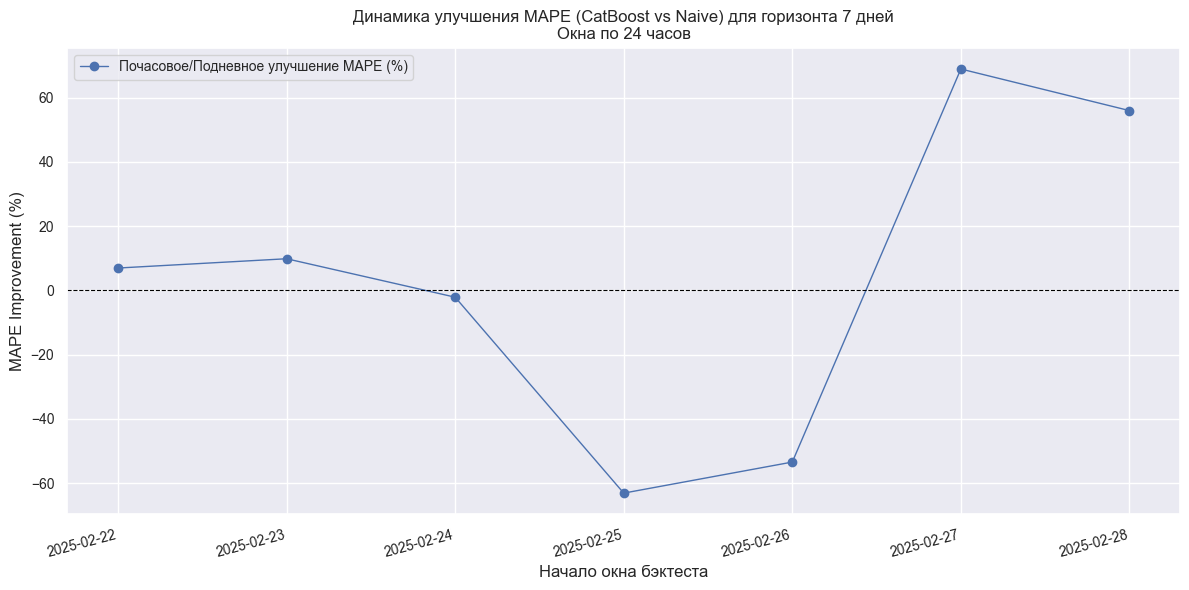

In [65]:
# ... после расчета final_metrics_df ...

# --- Дополнительный анализ: Стабильность улучшения MAPE ---
if y_true_evaluation_list and len(y_true_evaluation_list) > 1: # Нужно хотя бы 2 точки
    daily_mape_cb = []
    daily_mape_naive = []
    daily_timestamps = []

    # Рассчитаем MAPE по дням (или по другим блокам) бэктеста
    # Для простоты, если шагов много, можно брать окна, например, по 24 часа
    window_size = 24 
    num_windows = len(y_true_evaluation_list) // window_size

    for i in range(num_windows):
        start = i * window_size
        end = (i + 1) * window_size
        
        y_true_window = np.array(y_true_evaluation_list[start:end])
        y_pred_cb_window = np.array(y_pred_catboost_evaluation_list[start:end])
        y_pred_naive_window = np.array(y_pred_naive_evaluation_list[start:end])
        
        valid_cb_w = ~np.isnan(y_pred_cb_window) & ~np.isnan(y_true_window)
        
        if np.sum(valid_cb_w) > 0 :
            mape_cb_w = mean_absolute_percentage_error(y_true_window[valid_cb_w], y_pred_cb_window[valid_cb_w])
        else:
            mape_cb_w = np.nan
            
        mape_naive_w = mean_absolute_percentage_error(y_true_window, y_pred_naive_window)
        
        daily_mape_cb.append(mape_cb_w)
        daily_mape_naive.append(mape_naive_w)
        daily_timestamps.append(pd.to_datetime(feature_generation_timestamps[start])) # Берем начало окна

    if daily_timestamps:
        improvement_daily_mape = (np.array(daily_mape_naive) - np.array(daily_mape_cb)) / np.array(daily_mape_naive) * 100
        
        plt.figure(figsize=(12, 6))
        plt.plot(daily_timestamps, improvement_daily_mape, marker='o', linestyle='-', label='Почасовое/Подневное улучшение MAPE (%)')
        plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
        plt.title(f'Динамика улучшения MAPE (CatBoost vs Naive) для горизонта {TARGET_HORIZON_DAYS} дней\nОкна по {window_size} часов')
        plt.xlabel('Начало окна бэктеста')
        plt.ylabel('MAPE Improvement (%)')
        plt.xticks(rotation=15, ha="right")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

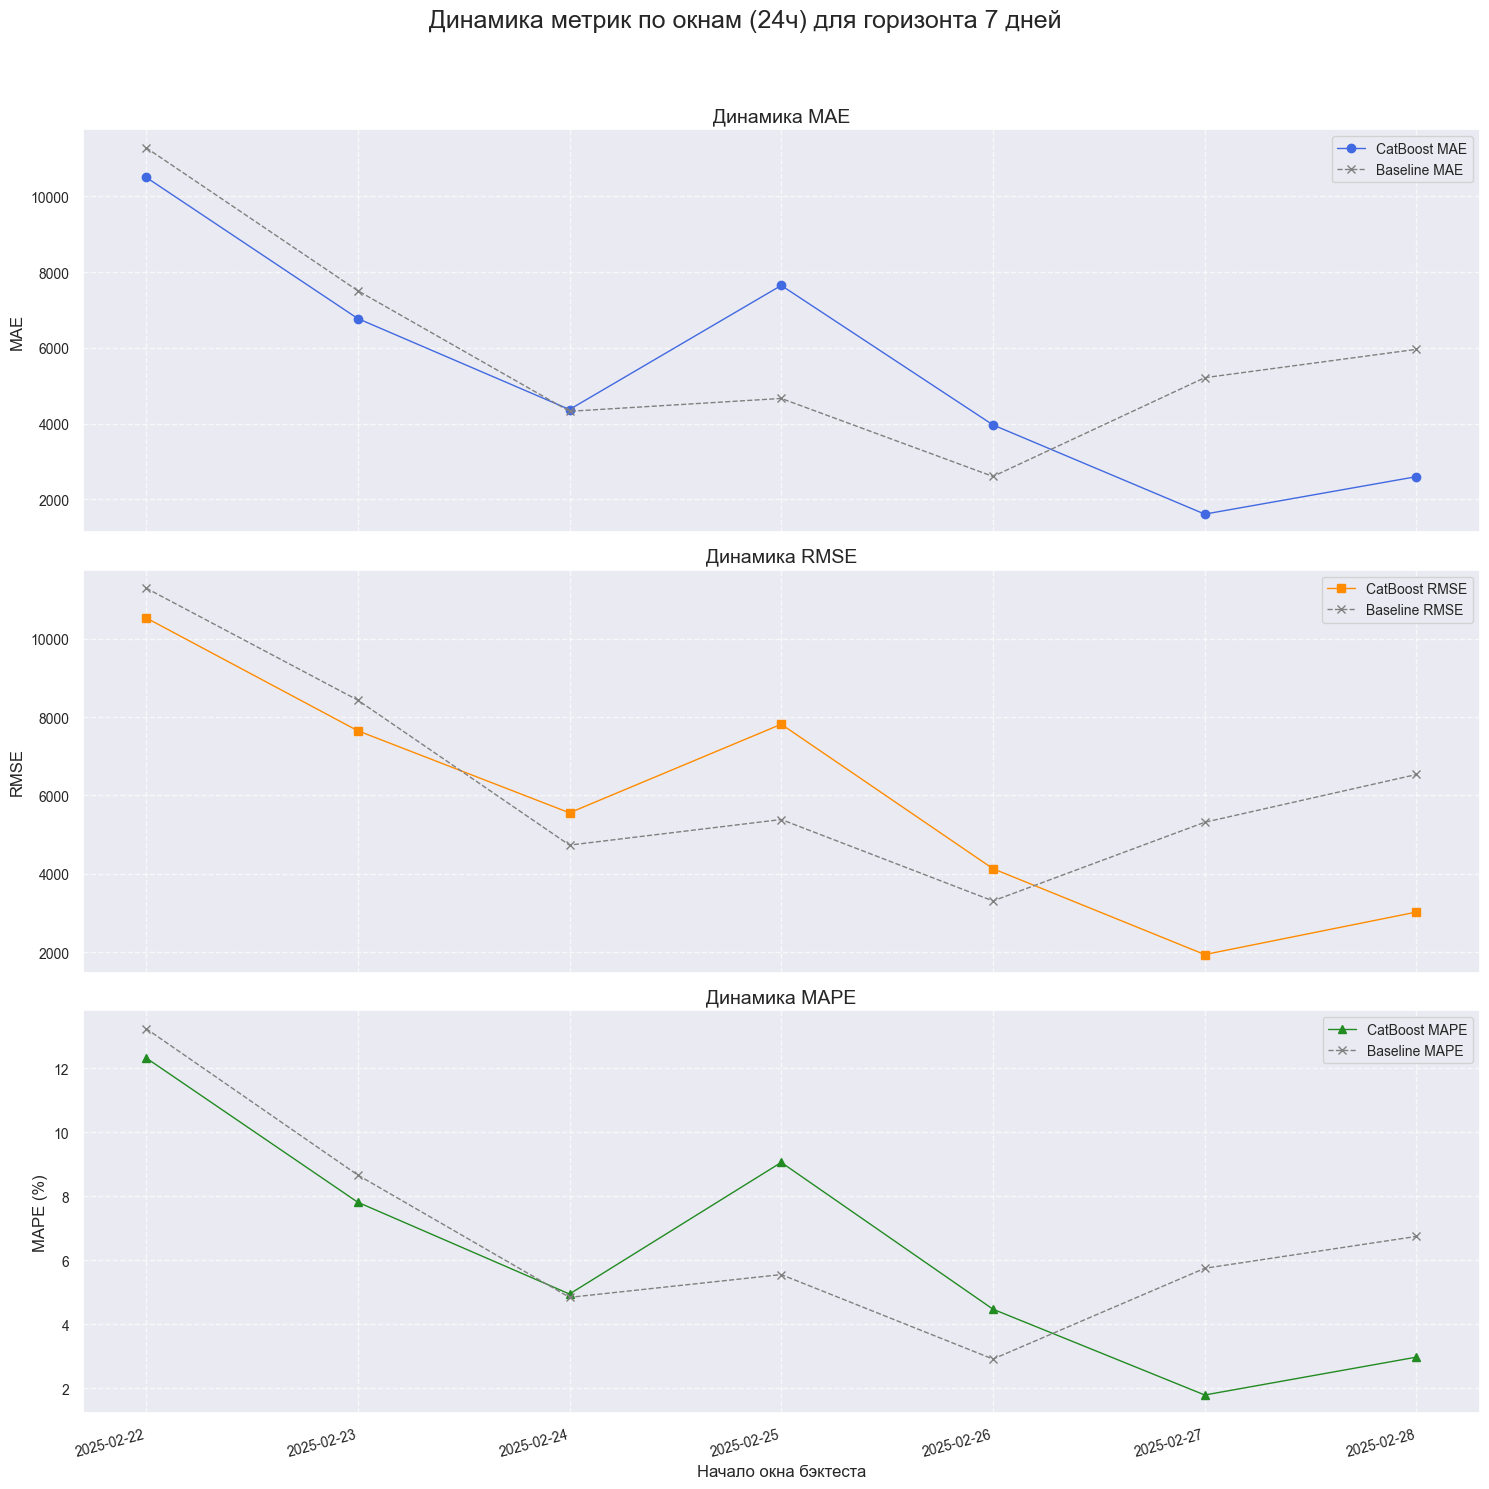

In [62]:
# ... (код до конца Эксперимента 4, после вывода таблицы и графика улучшения MAPE) ...

# --- Дополнительный анализ: Динамика основных метрик по окнам бэктеста ---
if y_true_evaluation_list and len(y_true_evaluation_list) > 1:
    window_metrics_list = []
    window_size = 24  # Размер окна в часах (например, 1 день)
    num_windows = len(y_true_evaluation_list) // window_size

    if num_windows == 0 and len(y_true_evaluation_list) > 0: # Если данных меньше чем на одно полное окно, возьмем все
        num_windows = 1
        window_size = len(y_true_evaluation_list)

    for i in range(num_windows):
        start = i * window_size
        end = (i + 1) * window_size if i < num_windows -1 else len(y_true_evaluation_list) # Последнее окно берет все до конца
        
        y_true_w = np.array(y_true_evaluation_list[start:end])
        y_pred_cb_w = np.array(y_pred_catboost_evaluation_list[start:end])
        y_pred_naive_w = np.array(y_pred_naive_evaluation_list[start:end])
        
        # Метрики для CatBoost
        valid_cb_w = ~np.isnan(y_pred_cb_w) & ~np.isnan(y_true_w)
        mae_cb_w, rmse_cb_w, mape_cb_w = np.nan, np.nan, np.nan
        if np.sum(valid_cb_w) > 0:
            mae_cb_w = mean_absolute_error(y_true_w[valid_cb_w], y_pred_cb_w[valid_cb_w])
            rmse_cb_w = np.sqrt(mean_squared_error(y_true_w[valid_cb_w], y_pred_cb_w[valid_cb_w]))
            mape_cb_w = mean_absolute_percentage_error(y_true_w[valid_cb_w], y_pred_cb_w[valid_cb_w])
            
        # Метрики для Наивного прогноза
        valid_naive_w = ~np.isnan(y_pred_naive_w) & ~np.isnan(y_true_w) # Хотя для наивного NaN в предсказаниях быть не должно
        mae_naive_w, rmse_naive_w, mape_naive_w = np.nan, np.nan, np.nan
        if np.sum(valid_naive_w) > 0:
            mae_naive_w = mean_absolute_error(y_true_w[valid_naive_w], y_pred_naive_w[valid_naive_w])
            rmse_naive_w = np.sqrt(mean_squared_error(y_true_w[valid_naive_w], y_pred_naive_w[valid_naive_w]))
            mape_naive_w = mean_absolute_percentage_error(y_true_w[valid_naive_w], y_pred_naive_w[valid_naive_w])
            
        window_metrics_list.append({
            'Timestamp_start': pd.to_datetime(feature_generation_timestamps[start]),
            'MAE_CatBoost': mae_cb_w, 'RMSE_CatBoost': rmse_cb_w, 'MAPE_CatBoost': mape_cb_w,
            'MAE_Baseline': mae_naive_w, 'RMSE_Baseline': rmse_naive_w, 'MAPE_Baseline': mape_naive_w
        })

    if window_metrics_list:
        window_metrics_df = pd.DataFrame(window_metrics_list)

        fig, axes = plt.subplots(3, 1, figsize=(15, 15), sharex=True)
        fig.suptitle(f'Динамика метрик по окнам ({window_size}ч) для горизонта {TARGET_HORIZON_DAYS} дней', fontsize=18, y=0.99)

        # MAE
        axes[0].plot(window_metrics_df['Timestamp_start'], window_metrics_df['MAE_CatBoost'], marker='o', linestyle='-', color='royalblue', label='CatBoost MAE')
        axes[0].plot(window_metrics_df['Timestamp_start'], window_metrics_df['MAE_Baseline'], marker='x', linestyle='--', color='gray', label='Baseline MAE')
        axes[0].set_ylabel('MAE', fontsize=12)
        axes[0].legend(fontsize=10)
        axes[0].grid(True, linestyle='--', alpha=0.7)
        axes[0].set_title('Динамика MAE', fontsize=14)

        # RMSE
        axes[1].plot(window_metrics_df['Timestamp_start'], window_metrics_df['RMSE_CatBoost'], marker='s', linestyle='-', color='darkorange', label='CatBoost RMSE')
        axes[1].plot(window_metrics_df['Timestamp_start'], window_metrics_df['RMSE_Baseline'], marker='x', linestyle='--', color='gray', label='Baseline RMSE')
        axes[1].set_ylabel('RMSE', fontsize=12)
        axes[1].legend(fontsize=10)
        axes[1].grid(True, linestyle='--', alpha=0.7)
        axes[1].set_title('Динамика RMSE', fontsize=14)
        
        # MAPE
        axes[2].plot(window_metrics_df['Timestamp_start'], window_metrics_df['MAPE_CatBoost'], marker='^', linestyle='-', color='forestgreen', label='CatBoost MAPE')
        axes[2].plot(window_metrics_df['Timestamp_start'], window_metrics_df['MAPE_Baseline'], marker='x', linestyle='--', color='gray', label='Baseline MAPE')
        axes[2].set_ylabel('MAPE (%)', fontsize=12)
        axes[2].legend(fontsize=10)
        axes[2].grid(True, linestyle='--', alpha=0.7)
        axes[2].set_title('Динамика MAPE', fontsize=14)

        axes[2].set_xlabel('Начало окна бэктеста', fontsize=12)
        plt.xticks(rotation=15, ha="right")
        fig.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()
    else:
        print("Недостаточно данных для построения графика динамики метрик по окнам.")

# ... (остальной код завершения Эксперимента 4) ...

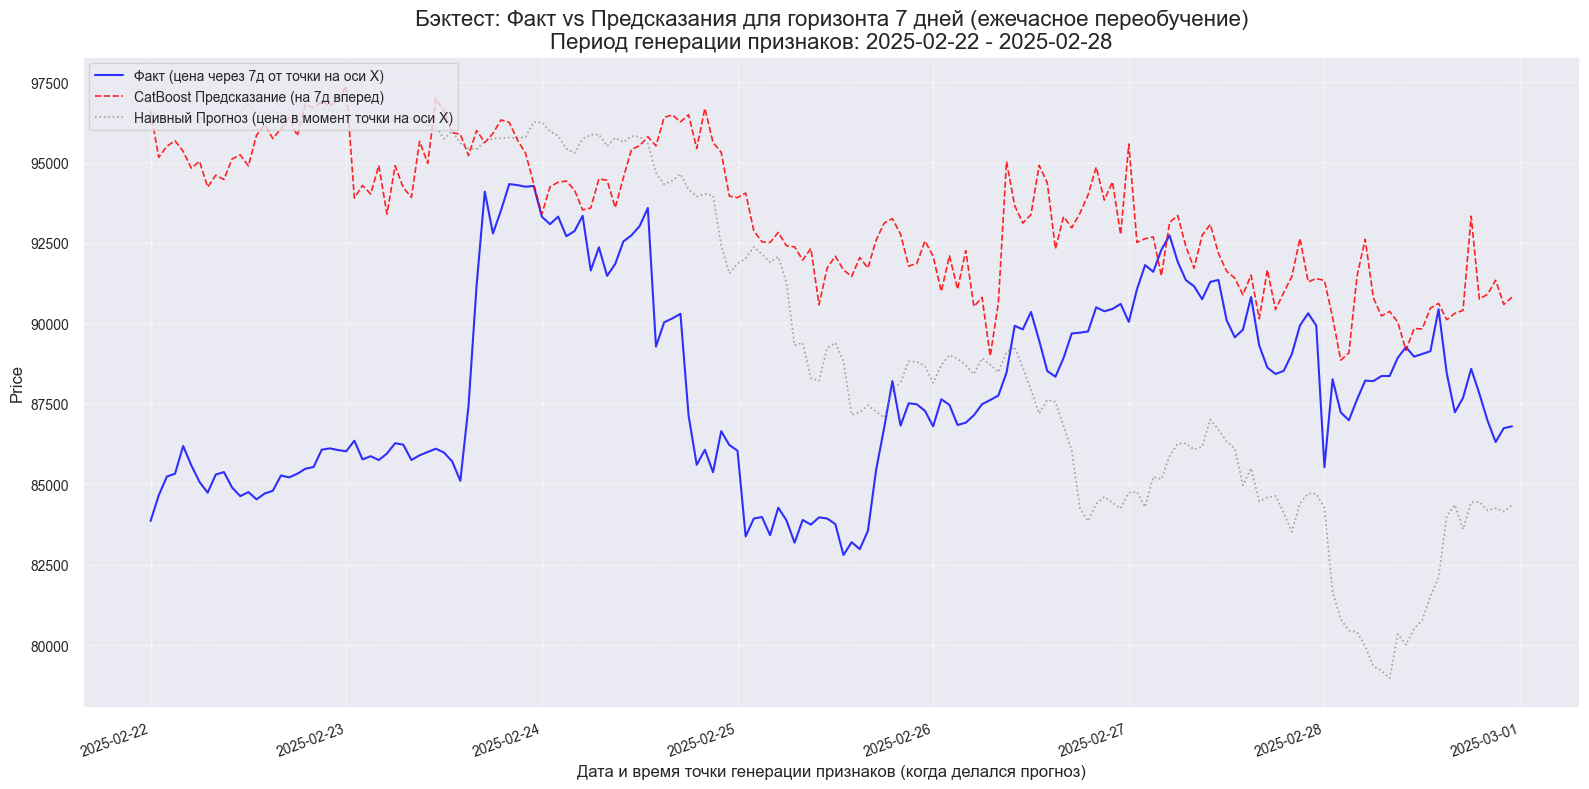

In [67]:
# ... (код до конца Эксперимента 4, после вывода таблицы final_metrics_df) ...

# --- График: Динамика фактических и предсказанных значений ---
if feature_generation_timestamps and \
   len(feature_generation_timestamps) == len(y_true_evaluation_list) and \
   len(y_true_evaluation_list) > 0:

    plot_df = pd.DataFrame({
        'Timestamp_FeatureGen': pd.to_datetime(feature_generation_timestamps),
        'Actual_Future_Price': y_true_evaluation_list, # Это y(t_feat_gen + H)
        'CatBoost_Predicted_Future_Price': y_pred_catboost_evaluation_list, # Это предсказание для y(t_feat_gen + H)
        'Naive_Prediction_as_Current_Price': y_pred_naive_evaluation_list # Это y(t_feat_gen), используемое как прогноз для y(t_feat_gen + H)
    })
    # plot_df.set_index('Timestamp_FeatureGen', inplace=True) # Можно установить индекс, если удобнее

    plt.figure(figsize=(16, 8)) # Увеличил немного размер для наглядности
    
    # 1. Фактические значения (целевая переменная, наступившая через H дней)
    # Ось X - это момент, КОГДА БЫЛИ ВЗЯТЫ ПРИЗНАКИ для этого будущего значения
    plt.plot(plot_df['Timestamp_FeatureGen'], plot_df['Actual_Future_Price'], 
             label=f'Факт (цена через {TARGET_HORIZON_DAYS}д от точки на оси X)', 
             color='blue', alpha=0.8, linewidth=1.5)
    
    # 2. Предсказания CatBoost
    # valid_cb_plot нужна, если в y_pred_catboost_evaluation_list могут быть NaN из-за ошибок на шагах
    valid_cb_plot_indices = ~plot_df['CatBoost_Predicted_Future_Price'].isnull()
    plt.plot(plot_df['Timestamp_FeatureGen'][valid_cb_plot_indices], 
             plot_df['CatBoost_Predicted_Future_Price'][valid_cb_plot_indices], 
             label=f'CatBoost Предсказание (на {TARGET_HORIZON_DAYS}д вперед)', 
             color='red', linestyle='--', alpha=0.85, linewidth=1.2)
    
    # 3. Наивные предсказания (текущая цена на момент генерации признаков)
    plt.plot(plot_df['Timestamp_FeatureGen'], plot_df['Naive_Prediction_as_Current_Price'], 
             label='Наивный Прогноз (цена в момент точки на оси X)', 
             color='gray', linestyle=':', alpha=0.7, linewidth=1.2)
    
    # Определение фактических дат для заголовка
    # Используем даты из feature_generation_timestamps, так как это ось X
    actual_plot_start_dt_display = plot_df['Timestamp_FeatureGen'].min().date()
    actual_plot_end_dt_display = plot_df['Timestamp_FeatureGen'].max().date()

    plt.title(f'Бэктест: Факт vs Предсказания для горизонта {TARGET_HORIZON_DAYS} дней (ежечасное переобучение)\nПериод генерации признаков: {actual_plot_start_dt_display} - {actual_plot_end_dt_display}', fontsize=16)
    plt.xlabel('Дата и время точки генерации признаков (когда делался прогноз)', fontsize=12)
    plt.ylabel(TARGET, fontsize=12)
    plt.legend(fontsize=10, loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xticks(rotation=20, ha="right") # Улучшаем читаемость дат
    plt.tight_layout()
    plt.show()
else:
    if not feature_generation_timestamps:
        print("Список feature_generation_timestamps пуст, график не будет построен.")
    elif len(feature_generation_timestamps) != len(y_true_evaluation_list):
        print("Размеры списков feature_generation_timestamps и y_true_evaluation_list не совпадают, график не будет построен.")
    else:
        print("Список y_true_evaluation_list пуст, график не будет построен.")

# ... (код завершения Эксперимента 4) ...